## **Lab 2 | Handwritten Digit Recognition System**

Problem Statement
- Developing a handwritten digital recognition system by creating a neural network model trained on MNIST dataset "handwritten digits from 0 to 9"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

### **Step 1: [Loading MNIST dataset](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)**

In [7]:
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test.csv")

print(train_data.head())

print("\nTrain Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]

Train Data Shape: (60000, 785)
Test Data Shape: (10000, 785)


**Dataset description:**
 - The MNIST dataset contains grayscale images of digits along with their corresponding labels.
 - Each image is 28x28 pixels, flattened into a vector of size 784.
 - The labels range from 0 to 9.

#### *Checking dataset distribution*

In [4]:
print("\nTrain Data Distribution:")
print(train_data.iloc[:, 0].value_counts())

print("\nTest Data Distribution:")
print(test_data.iloc[:, 0].value_counts())


Train Data Distribution:
label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

Test Data Distribution:
label
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: count, dtype: int64


**Conclusion**: the distribution is well balanced, no label is significantly overrepresented, or underrepresented, which minimizes bias towards a specific label

### **Step 2: Data Splitting**

In [12]:
X_temp = train_data.iloc[:,1:].values
y_temp = train_data.iloc[:, 0].values

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=10000, stratify=y_temp, random_state=42)

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [6]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 50000
Validation set size: 10000
Test set size: 10000


#### *Normalization*
 dividing by 255, so that ranges are [0,1], ensuring numerical stability during training

In [13]:
X_test = X_test / 255.0
X_train = X_train / 255.0
X_val = X_val / 255.0

Visual representation of a random sample

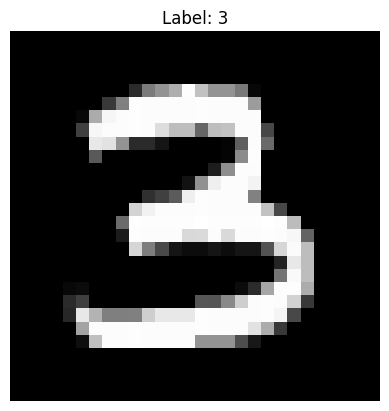

In [8]:
sample_image = X_train[10]
sample_label = y_train[10]
sample_image = sample_image.reshape(28, 28)

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

### **Step 3: Converting Data to Tensors**

In [14]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


### **Step 4: Data Loaders** to facilitate batch processing

In [15]:
batch_size = 32

# Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### **Step 5: Neural Network Design**
Fully connected feedforward neural network with:
- Input layer: 784 neurons, one for each pixel
- 2 hidden layers: 128 neurons in the first, and 64 neurons in the second
- Output layer: 10 neurons, one for each class
- activation function: ReLU

In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


- Loss function: Cross-Entropy Loss
- Optimization technique: Stochastic Gradient Descent (SGD)
- Learning Rate: 0.01

In [ ]:
model = FeedforwardNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### **Step 6: Training the model**

In [11]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
  train_losses = []
  train_accuracies = []

  val_losses = []
  val_accuracies = []

  for epoch in range(epochs):

      # Training Loss and Accuracy
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct / total

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Validation Loss and Accuracy
      model.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      for inputs, labels in val_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

      val_loss = val_loss / len(val_loader)
      val_accuracy = 100 * val_correct / val_total

      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f'Epoch [{epoch+1}/{epochs}]')
      print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
      print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

  # Plot the training loss
  plt.figure(figsize=(12, 10))

  # Plot loss
  plt.subplot(2, 2, 1)  # Training Loss
  plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.subplot(2, 2, 2)  # Validation Loss
  plt.plot(range(1, epochs + 1), val_losses, marker='o', color='blue')
  plt.title('Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  # Plot accuracy
  plt.subplot(2, 2, 3)  # Training Accuracy
  plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='green')
  plt.title('Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  plt.subplot(2, 2, 4)  # Validation Accuracy
  plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='green')
  plt.title('Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  # Show the plots
  plt.tight_layout()
  plt.show()

Epoch [1/10]
Training Loss: 1.3262, Accuracy: 69.68%
Validation Loss: 0.4874, Accuracy: 86.52%
Epoch [2/10]
Training Loss: 0.3903, Accuracy: 88.87%
Validation Loss: 0.3415, Accuracy: 90.40%
Epoch [3/10]
Training Loss: 0.3123, Accuracy: 91.04%
Validation Loss: 0.2905, Accuracy: 91.83%
Epoch [4/10]
Training Loss: 0.2712, Accuracy: 92.25%
Validation Loss: 0.2566, Accuracy: 92.58%
Epoch [5/10]
Training Loss: 0.2405, Accuracy: 93.06%
Validation Loss: 0.2299, Accuracy: 93.50%
Epoch [6/10]
Training Loss: 0.2164, Accuracy: 93.81%
Validation Loss: 0.2081, Accuracy: 94.05%
Epoch [7/10]
Training Loss: 0.1952, Accuracy: 94.39%
Validation Loss: 0.1896, Accuracy: 94.59%
Epoch [8/10]
Training Loss: 0.1786, Accuracy: 94.80%
Validation Loss: 0.1740, Accuracy: 95.06%
Epoch [9/10]
Training Loss: 0.1633, Accuracy: 95.26%
Validation Loss: 0.1602, Accuracy: 95.55%
Epoch [10/10]
Training Loss: 0.1502, Accuracy: 95.66%
Validation Loss: 0.1482, Accuracy: 95.88%


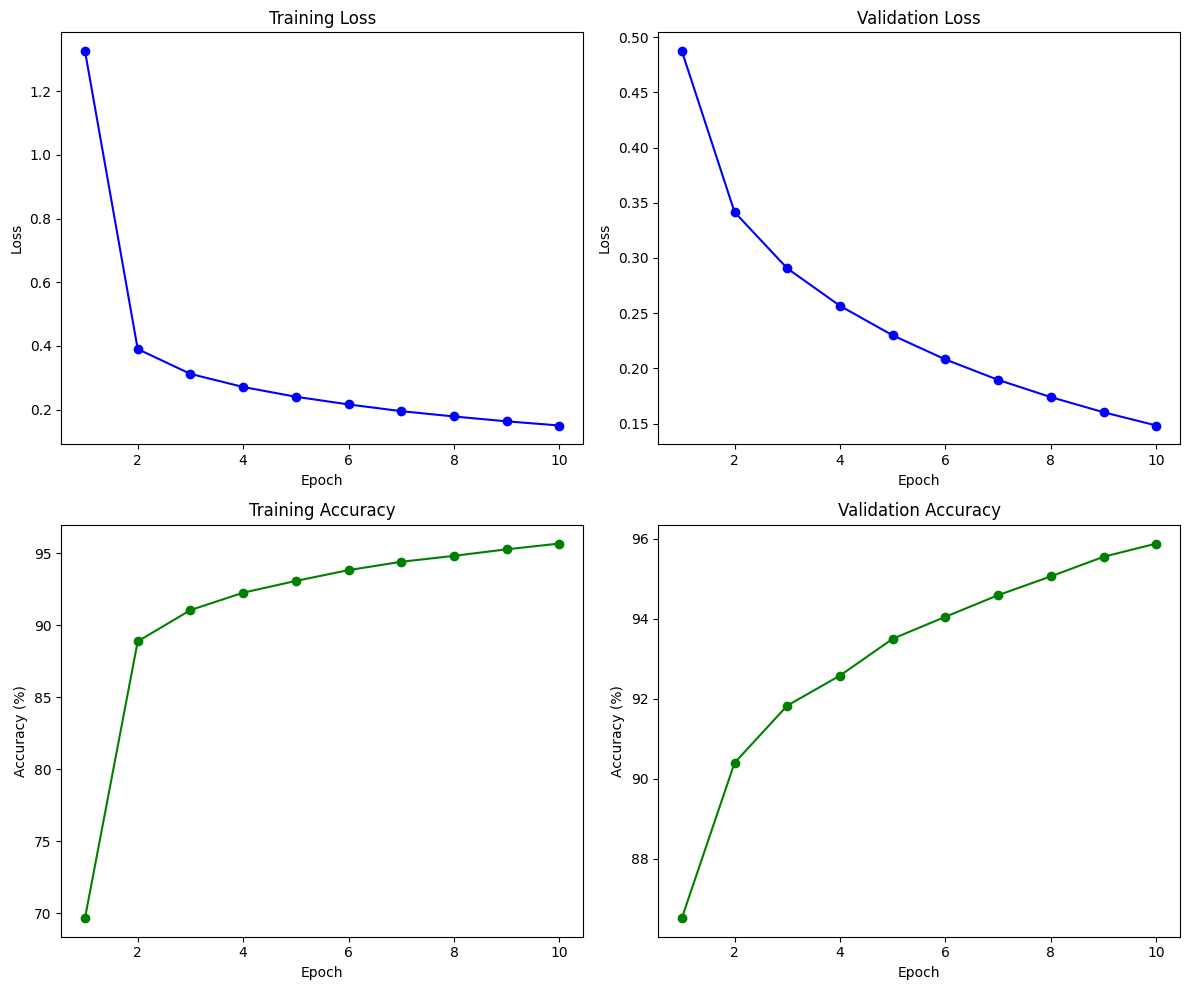

In [ ]:
train(model, train_loader, val_loader, loss_fn, optimizer, 10)

*Conclusion*
After 10 epochs:
 - Training Accuracy = 95.66%
 - Validation Accuracy = 95.88%


### **Step 7: Testing the model**

In [12]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  # Storing all predictions and true labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          # Reshaping inputs
          inputs = inputs.view(inputs.size(0), -1)  # Automatically handle batch size
          outputs = model(inputs)

          # Get predicted labels
          _, predicted = torch.max(outputs, dim=1)

          # Update metrics
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Store predictions and true labels
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calculate overall accuracy
  test_accuracy = 100 * correct / total
  print(f"Test Accuracy: {test_accuracy:.2f}%")


  cm = confusion_matrix(all_labels, all_preds)

  # Plotting the confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  ################################

  # Visualize multiple sample predictions
  sample_indices = [0,1,2,3,4,5]

  num_samples = len(sample_indices)
  plt.figure(figsize=(12, 3 * num_samples))

  for i, index in enumerate(sample_indices):
      sample_image = X_test[index]
      true_label = y_test[index]

      # Prepare the sample for the model
      sample_image = torch.tensor(sample_image).float().view(1, -1)

      with torch.no_grad():
          output = model(sample_image)
          _, predicted_label = torch.max(output, 1)

      # Plot the image
      plt.subplot(1, num_samples, i + 1)
      plt.imshow(sample_image.reshape(28, 28), cmap='gray')
      plt.title(f"True: {true_label} | Pred: {predicted_label.item()}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

Test Accuracy: 95.57%


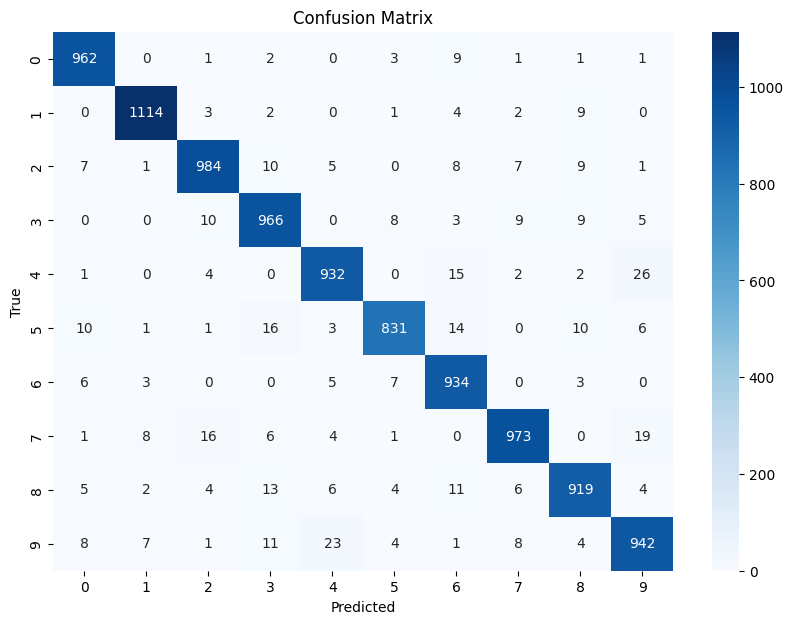

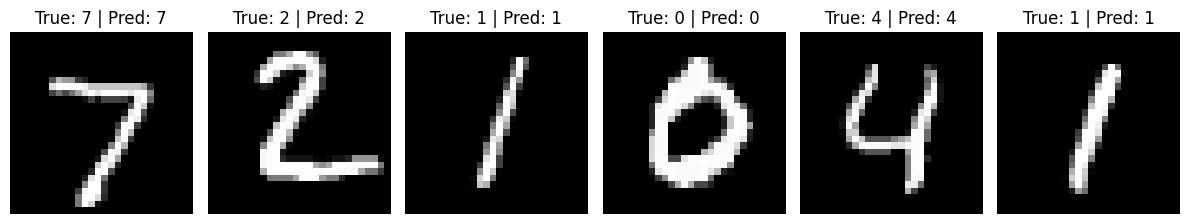

In [ ]:
test(model, test_loader)

### **Summary:**

 - Training Accuracy = 95.66%
 - Validation Accuracy = 95.88%
 - Test Accuracy = 95.57%

# **Analysis**

# Change Learning Rate [0.1, 0.05, 0.01, 0.001, 0.0001]
* Batch size = 32
* Neurons number: 128 then 64

### **At learning rate = 0.1**

Epoch [1/10]
Training Loss: 0.4155, Accuracy: 87.43%
Validation Loss: 0.1836, Accuracy: 94.26%
Epoch [2/10]
Training Loss: 0.1390, Accuracy: 95.80%
Validation Loss: 0.1098, Accuracy: 96.65%
Epoch [3/10]
Training Loss: 0.0931, Accuracy: 97.17%
Validation Loss: 0.0775, Accuracy: 97.85%
Epoch [4/10]
Training Loss: 0.0710, Accuracy: 97.79%
Validation Loss: 0.0575, Accuracy: 98.37%
Epoch [5/10]
Training Loss: 0.0554, Accuracy: 98.31%
Validation Loss: 0.0442, Accuracy: 98.86%
Epoch [6/10]
Training Loss: 0.0457, Accuracy: 98.57%
Validation Loss: 0.0363, Accuracy: 99.07%
Epoch [7/10]
Training Loss: 0.0376, Accuracy: 98.80%
Validation Loss: 0.0286, Accuracy: 99.25%
Epoch [8/10]
Training Loss: 0.0310, Accuracy: 99.02%
Validation Loss: 0.0257, Accuracy: 99.21%
Epoch [9/10]
Training Loss: 0.0244, Accuracy: 99.24%
Validation Loss: 0.0195, Accuracy: 99.50%
Epoch [10/10]
Training Loss: 0.0209, Accuracy: 99.34%
Validation Loss: 0.0151, Accuracy: 99.54%


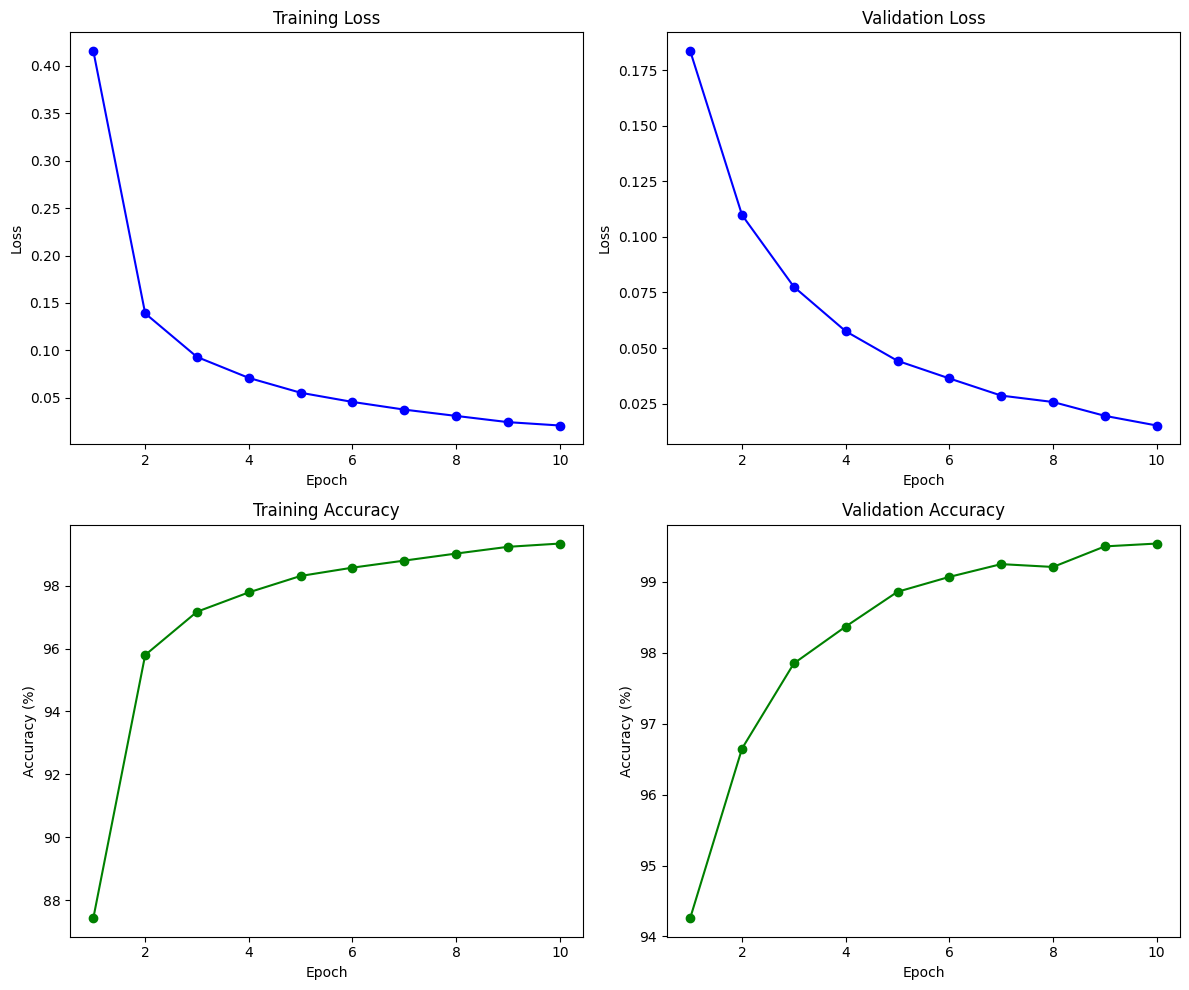

In [ ]:
model_1 = FeedforwardNN()
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.1)

train(model_1, train_loader, val_loader, loss_fn_1, optimizer_1, 10)

Test Accuracy: 97.77%


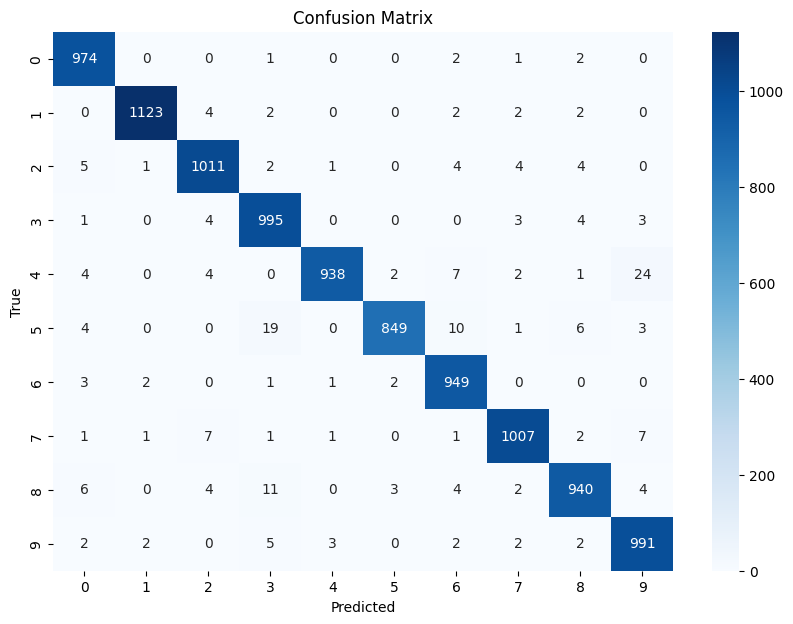

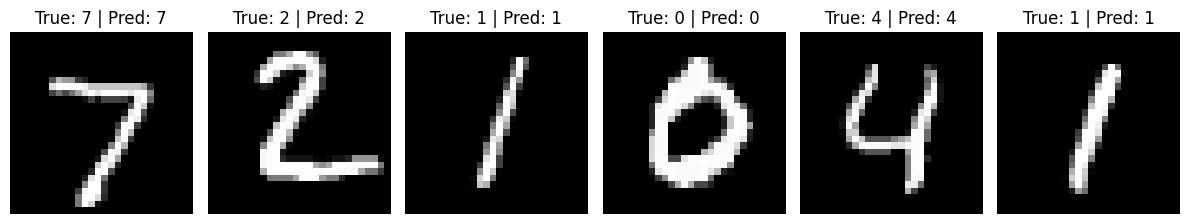

In [ ]:
test(model_1, test_loader)

### **At learning rate = 0.05**

Epoch [1/10]
Training Loss: 0.5649, Accuracy: 83.99%
Validation Loss: 0.2609, Accuracy: 92.34%
Epoch [2/10]
Training Loss: 0.2010, Accuracy: 94.02%
Validation Loss: 0.1646, Accuracy: 95.17%
Epoch [3/10]
Training Loss: 0.1348, Accuracy: 96.07%
Validation Loss: 0.1212, Accuracy: 96.46%
Epoch [4/10]
Training Loss: 0.1013, Accuracy: 97.00%
Validation Loss: 0.0935, Accuracy: 97.23%
Epoch [5/10]
Training Loss: 0.0817, Accuracy: 97.55%
Validation Loss: 0.0746, Accuracy: 97.83%
Epoch [6/10]
Training Loss: 0.0675, Accuracy: 97.96%
Validation Loss: 0.0612, Accuracy: 98.31%
Epoch [7/10]
Training Loss: 0.0570, Accuracy: 98.27%
Validation Loss: 0.0507, Accuracy: 98.69%
Epoch [8/10]
Training Loss: 0.0485, Accuracy: 98.50%
Validation Loss: 0.0429, Accuracy: 98.85%
Epoch [9/10]
Training Loss: 0.0408, Accuracy: 98.78%
Validation Loss: 0.0365, Accuracy: 99.03%
Epoch [10/10]
Training Loss: 0.0353, Accuracy: 98.93%
Validation Loss: 0.0306, Accuracy: 99.24%


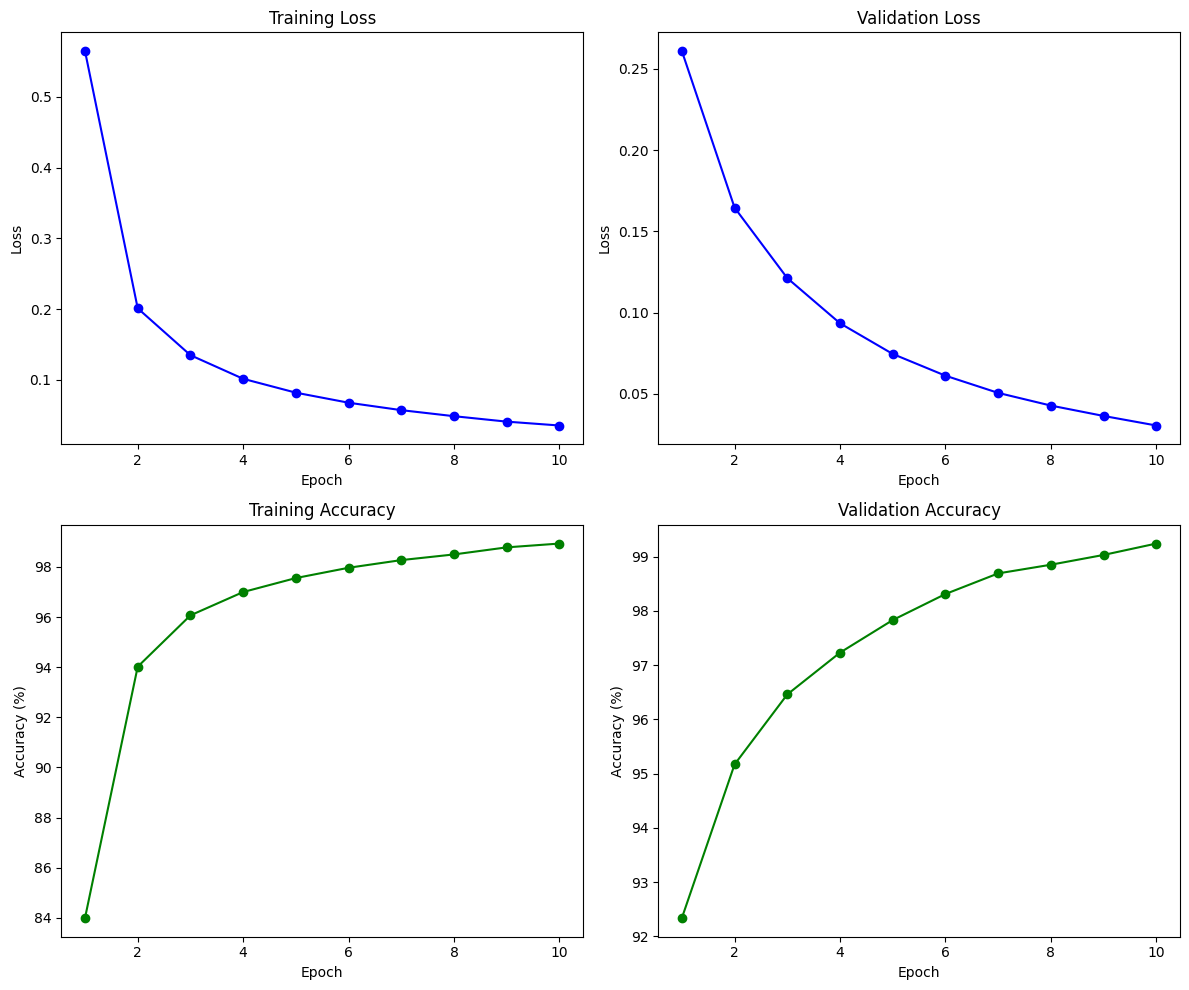

In [ ]:
model_2 = FeedforwardNN()
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.05)

train(model_2, train_loader, val_loader, loss_fn_2, optimizer_2, 10)

Test Accuracy: 97.71%


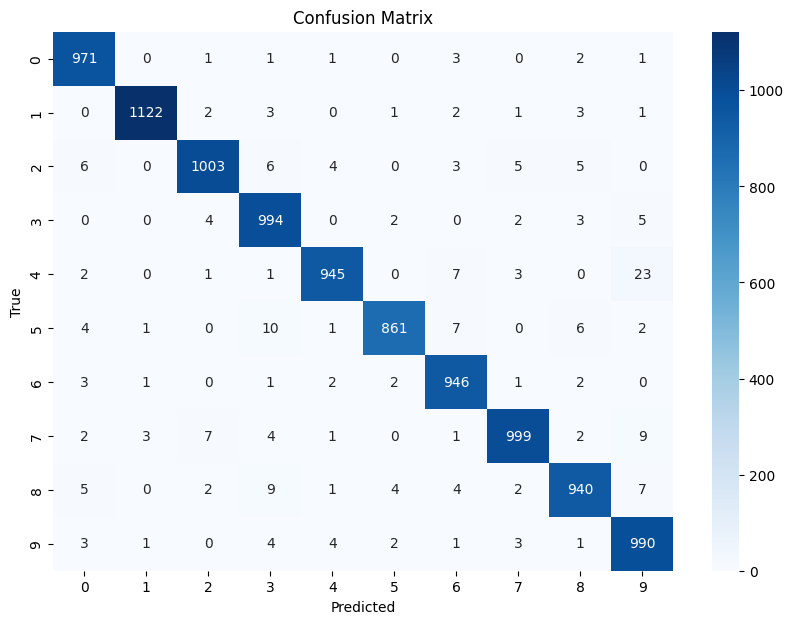

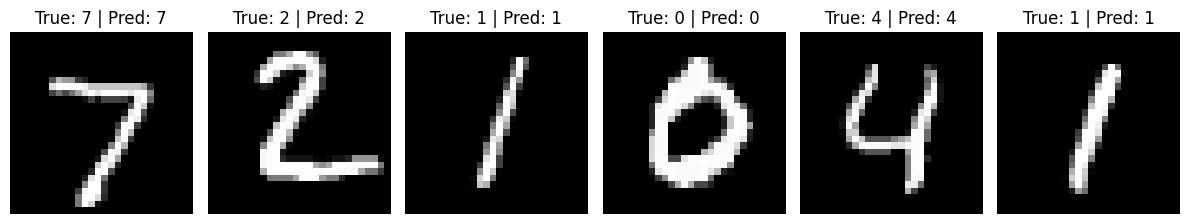

In [ ]:
test(model_2, test_loader)

### **At learning rate = 0.01**

Epoch [1/10]
Training Loss: 1.3228, Accuracy: 63.24%
Validation Loss: 0.4777, Accuracy: 86.77%
Epoch [2/10]
Training Loss: 0.3855, Accuracy: 89.09%
Validation Loss: 0.3394, Accuracy: 90.46%
Epoch [3/10]
Training Loss: 0.3118, Accuracy: 91.00%
Validation Loss: 0.2901, Accuracy: 91.84%
Epoch [4/10]
Training Loss: 0.2713, Accuracy: 92.11%
Validation Loss: 0.2570, Accuracy: 92.72%
Epoch [5/10]
Training Loss: 0.2413, Accuracy: 93.08%
Validation Loss: 0.2309, Accuracy: 93.43%
Epoch [6/10]
Training Loss: 0.2165, Accuracy: 93.82%
Validation Loss: 0.2093, Accuracy: 94.04%
Epoch [7/10]
Training Loss: 0.1959, Accuracy: 94.31%
Validation Loss: 0.1906, Accuracy: 94.62%
Epoch [8/10]
Training Loss: 0.1781, Accuracy: 94.84%
Validation Loss: 0.1747, Accuracy: 95.00%
Epoch [9/10]
Training Loss: 0.1625, Accuracy: 95.26%
Validation Loss: 0.1608, Accuracy: 95.27%
Epoch [10/10]
Training Loss: 0.1493, Accuracy: 95.69%
Validation Loss: 0.1488, Accuracy: 95.69%


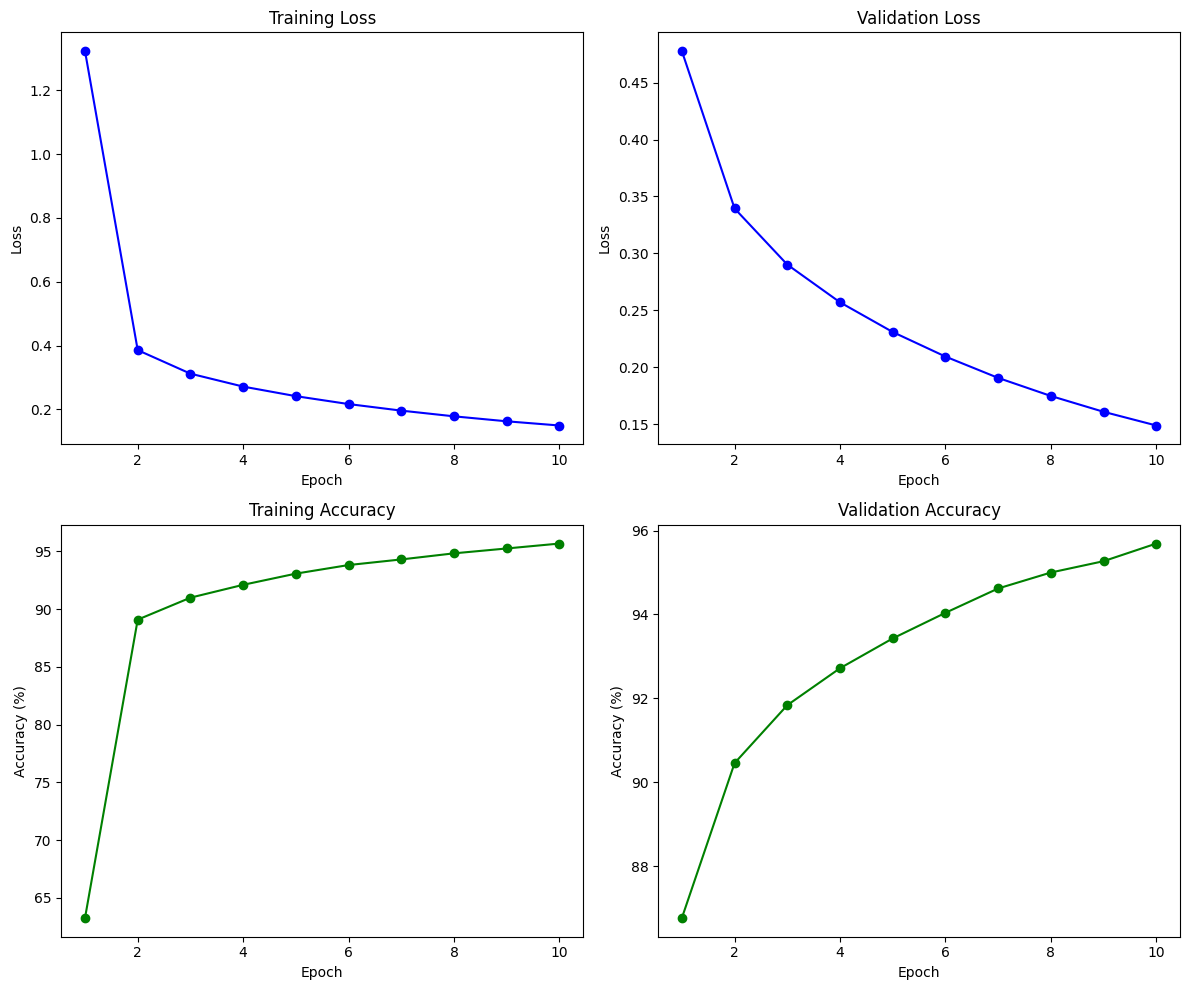

In [ ]:
model_3 = FeedforwardNN()
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_3.parameters(), lr=0.01)

train(model_3, train_loader, val_loader, loss_fn_3, optimizer_3, 10)

Test Accuracy: 95.51%


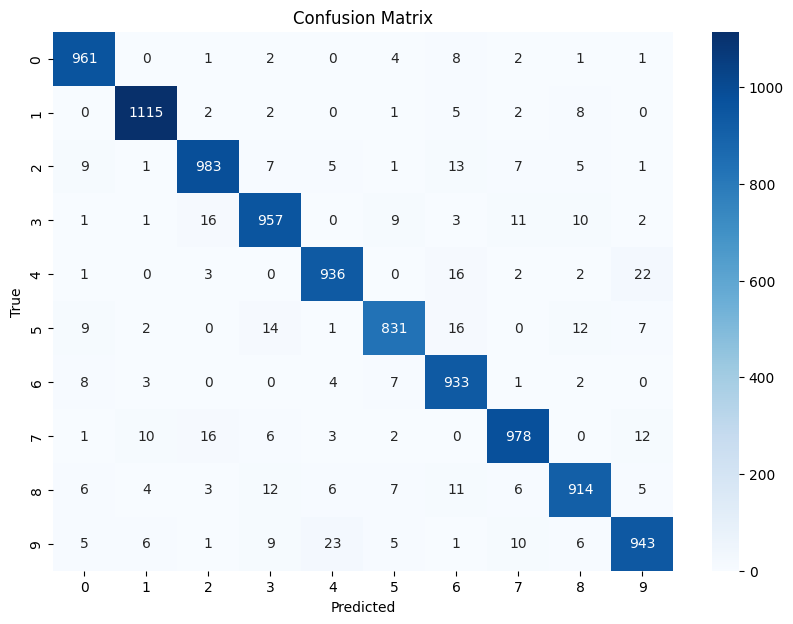

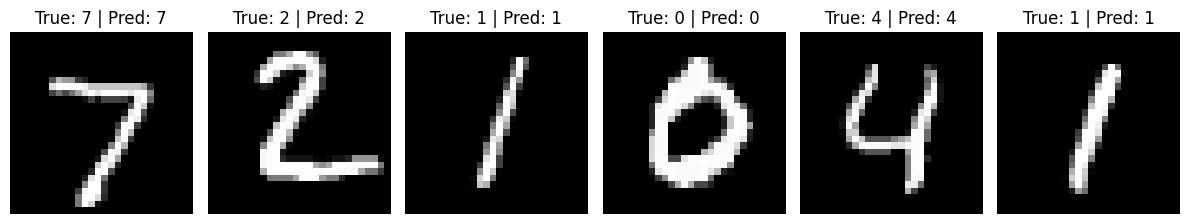

In [ ]:
test(model_3, test_loader)

### **At learning rate = 0.001**

Epoch [1/10]
Training Loss: 2.2783, Accuracy: 14.74%
Validation Loss: 2.2441, Accuracy: 34.49%
Epoch [2/10]
Training Loss: 2.1841, Accuracy: 44.59%
Validation Loss: 2.0970, Accuracy: 44.71%
Epoch [3/10]
Training Loss: 1.9518, Accuracy: 47.34%
Validation Loss: 1.7655, Accuracy: 55.07%
Epoch [4/10]
Training Loss: 1.5325, Accuracy: 65.78%
Validation Loss: 1.2905, Accuracy: 74.53%
Epoch [5/10]
Training Loss: 1.0759, Accuracy: 77.56%
Validation Loss: 0.9060, Accuracy: 80.35%
Epoch [6/10]
Training Loss: 0.7871, Accuracy: 81.29%
Validation Loss: 0.7016, Accuracy: 82.79%
Epoch [7/10]
Training Loss: 0.6361, Accuracy: 83.57%
Validation Loss: 0.5916, Accuracy: 84.39%
Epoch [8/10]
Training Loss: 0.5510, Accuracy: 85.18%
Validation Loss: 0.5259, Accuracy: 85.71%
Epoch [9/10]
Training Loss: 0.4982, Accuracy: 86.32%
Validation Loss: 0.4826, Accuracy: 86.74%
Epoch [10/10]
Training Loss: 0.4620, Accuracy: 87.21%
Validation Loss: 0.4520, Accuracy: 87.46%


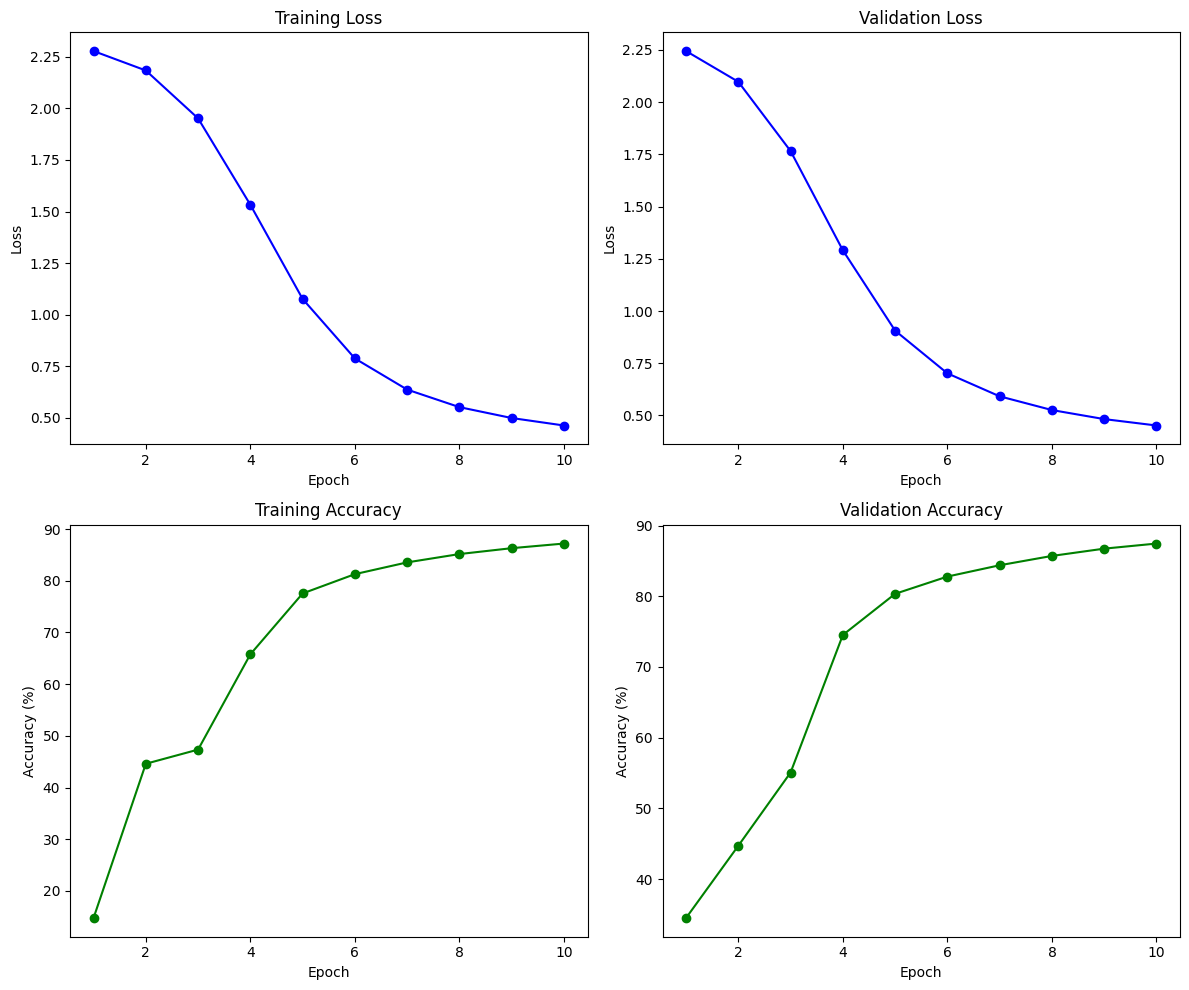

In [ ]:
model_4 = FeedforwardNN()
loss_fn_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.SGD(model_4.parameters(), lr=0.001)

train(model_4, train_loader, val_loader, loss_fn_4, optimizer_4, 10)


Test Accuracy: 87.81%


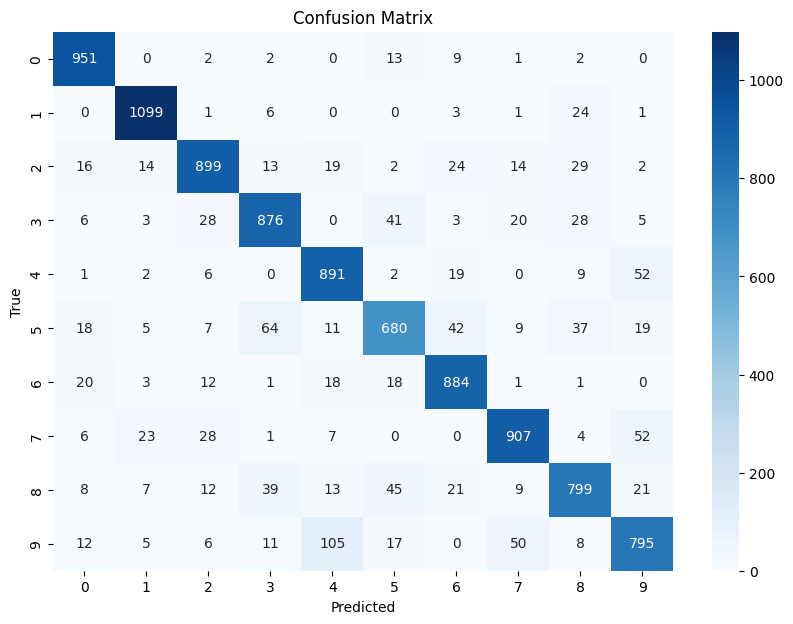

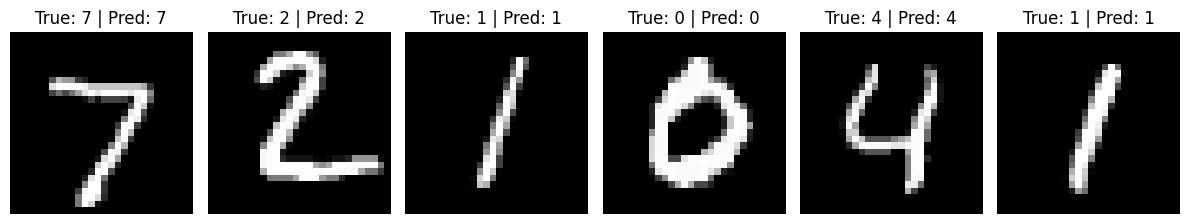

In [ ]:
test(model_4, test_loader)

### **At learning rate = 0.0001**

Epoch [1/10]
Training Loss: 1.3633, Accuracy: 65.23%
Validation Loss: 0.5109, Accuracy: 85.57%
Epoch [2/10]
Training Loss: 0.3993, Accuracy: 88.74%
Validation Loss: 0.3459, Accuracy: 90.29%
Epoch [3/10]
Training Loss: 0.3151, Accuracy: 90.95%
Validation Loss: 0.2940, Accuracy: 91.66%
Epoch [4/10]
Training Loss: 0.2743, Accuracy: 92.13%
Validation Loss: 0.2596, Accuracy: 92.55%
Epoch [5/10]
Training Loss: 0.2432, Accuracy: 93.04%
Validation Loss: 0.2318, Accuracy: 93.33%
Epoch [6/10]
Training Loss: 0.2166, Accuracy: 93.77%
Validation Loss: 0.2080, Accuracy: 94.07%
Epoch [7/10]
Training Loss: 0.1947, Accuracy: 94.45%
Validation Loss: 0.1880, Accuracy: 94.69%
Epoch [8/10]
Training Loss: 0.1758, Accuracy: 94.95%
Validation Loss: 0.1715, Accuracy: 95.08%
Epoch [9/10]
Training Loss: 0.1604, Accuracy: 95.36%
Validation Loss: 0.1574, Accuracy: 95.52%
Epoch [10/10]
Training Loss: 0.1467, Accuracy: 95.73%
Validation Loss: 0.1456, Accuracy: 95.87%


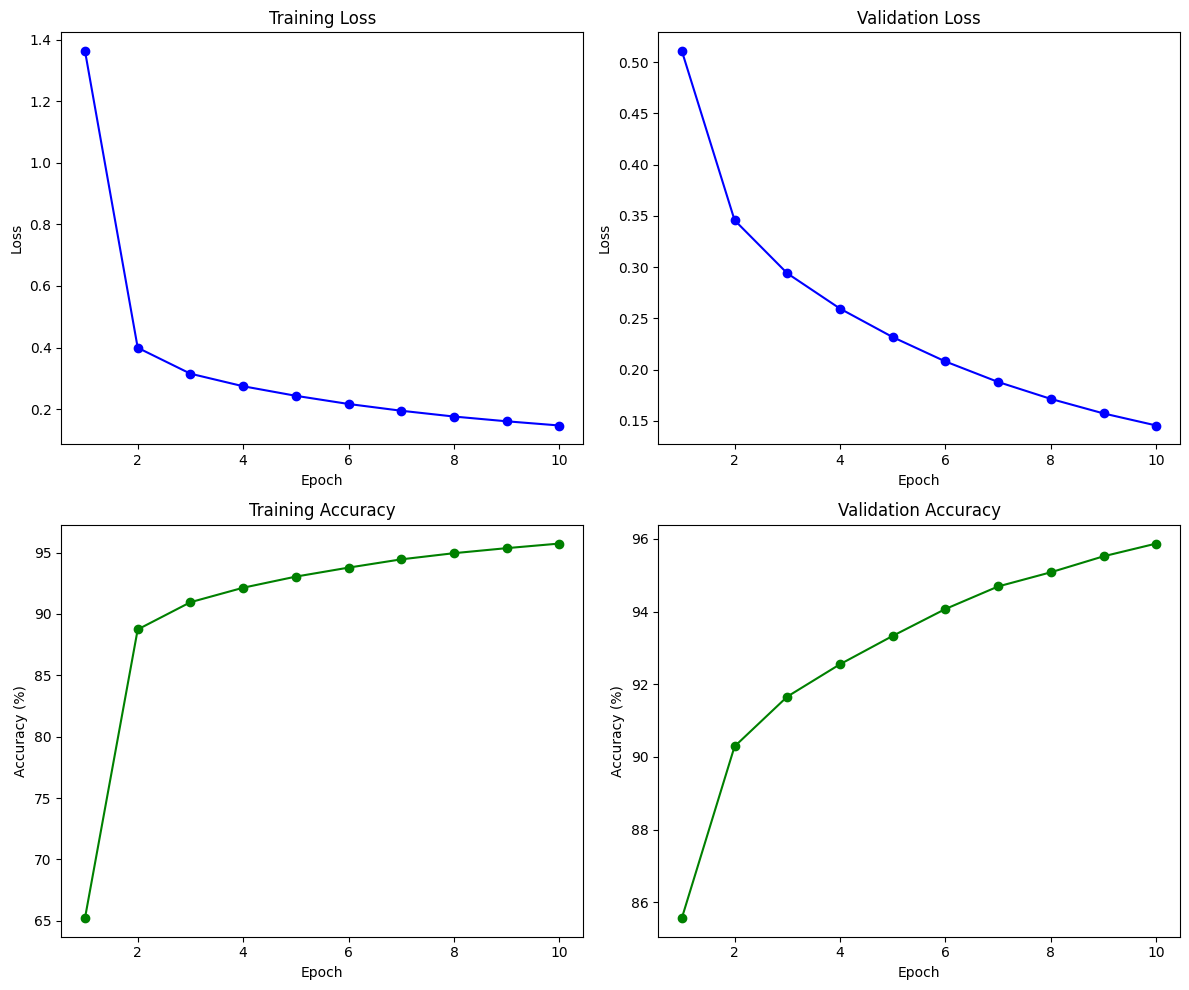

In [ ]:
model_5 = FeedforwardNN()
loss_fn_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(model_5.parameters(), lr=0.01)

train(model_5, train_loader, val_loader, loss_fn_5, optimizer_5, 10)

Test Accuracy: 95.67%


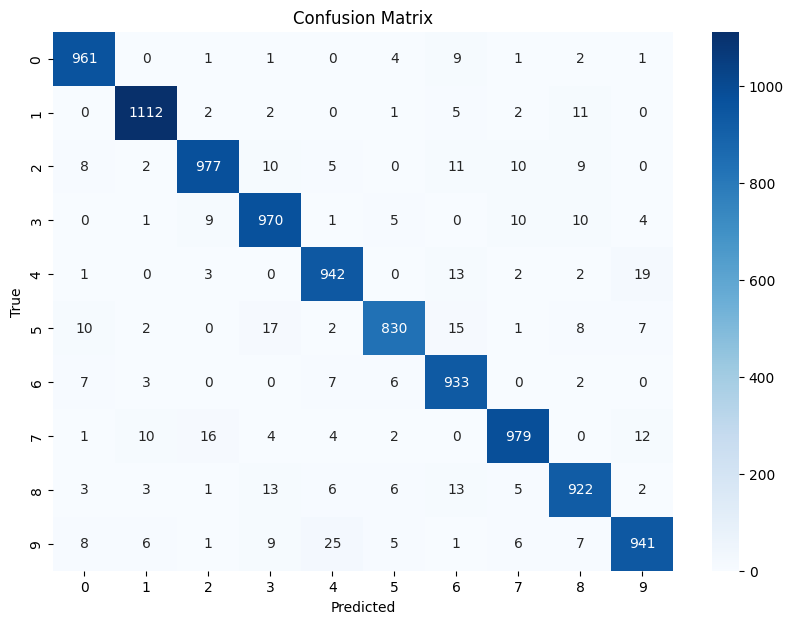

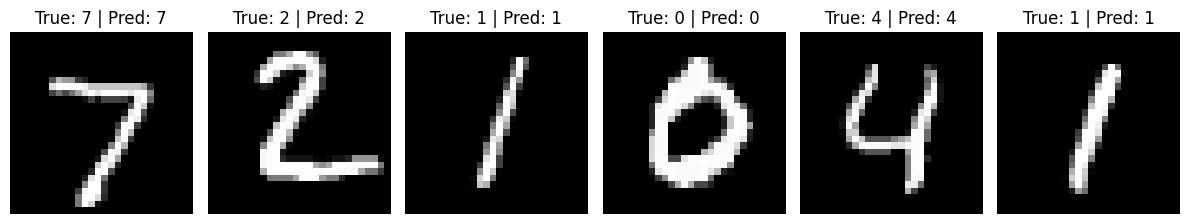

In [ ]:
test(model_5, test_loader)

* At learning rate = **0.1** --- Accuracy = **97.77%**
* At learning rate = **0.05** --- Accuracy = **97.71%**
* At learning rate = **0.01** --- Accuracy = **95.51%**
* At learning rate = **0.001** --- Accuracy = **87.81%**
* At learning rate = **0.0001** --- Accuracy = **95.67%**

Then we choose leaning rate = **0.1** which is model_1 as it gives the highest accuracy

# Change Batch size [32, 64, 128, 256, 512]
* Learning rate = 0.1
* Neurons number: 128 then 64

### **At batch size = 32**

Epoch [1/10]
Training Loss: 0.4063, Accuracy: 88.04%
Validation Loss: 0.1876, Accuracy: 94.48%
Epoch [2/10]
Training Loss: 0.1401, Accuracy: 95.82%
Validation Loss: 0.1134, Accuracy: 96.42%
Epoch [3/10]
Training Loss: 0.0960, Accuracy: 97.05%
Validation Loss: 0.0820, Accuracy: 97.45%
Epoch [4/10]
Training Loss: 0.0732, Accuracy: 97.76%
Validation Loss: 0.0607, Accuracy: 98.08%
Epoch [5/10]
Training Loss: 0.0606, Accuracy: 98.07%
Validation Loss: 0.0465, Accuracy: 98.50%
Epoch [6/10]
Training Loss: 0.0478, Accuracy: 98.49%
Validation Loss: 0.0346, Accuracy: 99.04%
Epoch [7/10]
Training Loss: 0.0399, Accuracy: 98.75%
Validation Loss: 0.0277, Accuracy: 99.31%
Epoch [8/10]
Training Loss: 0.0320, Accuracy: 98.96%
Validation Loss: 0.0263, Accuracy: 99.19%
Epoch [9/10]
Training Loss: 0.0277, Accuracy: 99.08%
Validation Loss: 0.0201, Accuracy: 99.46%
Epoch [10/10]
Training Loss: 0.0214, Accuracy: 99.31%
Validation Loss: 0.0177, Accuracy: 99.49%


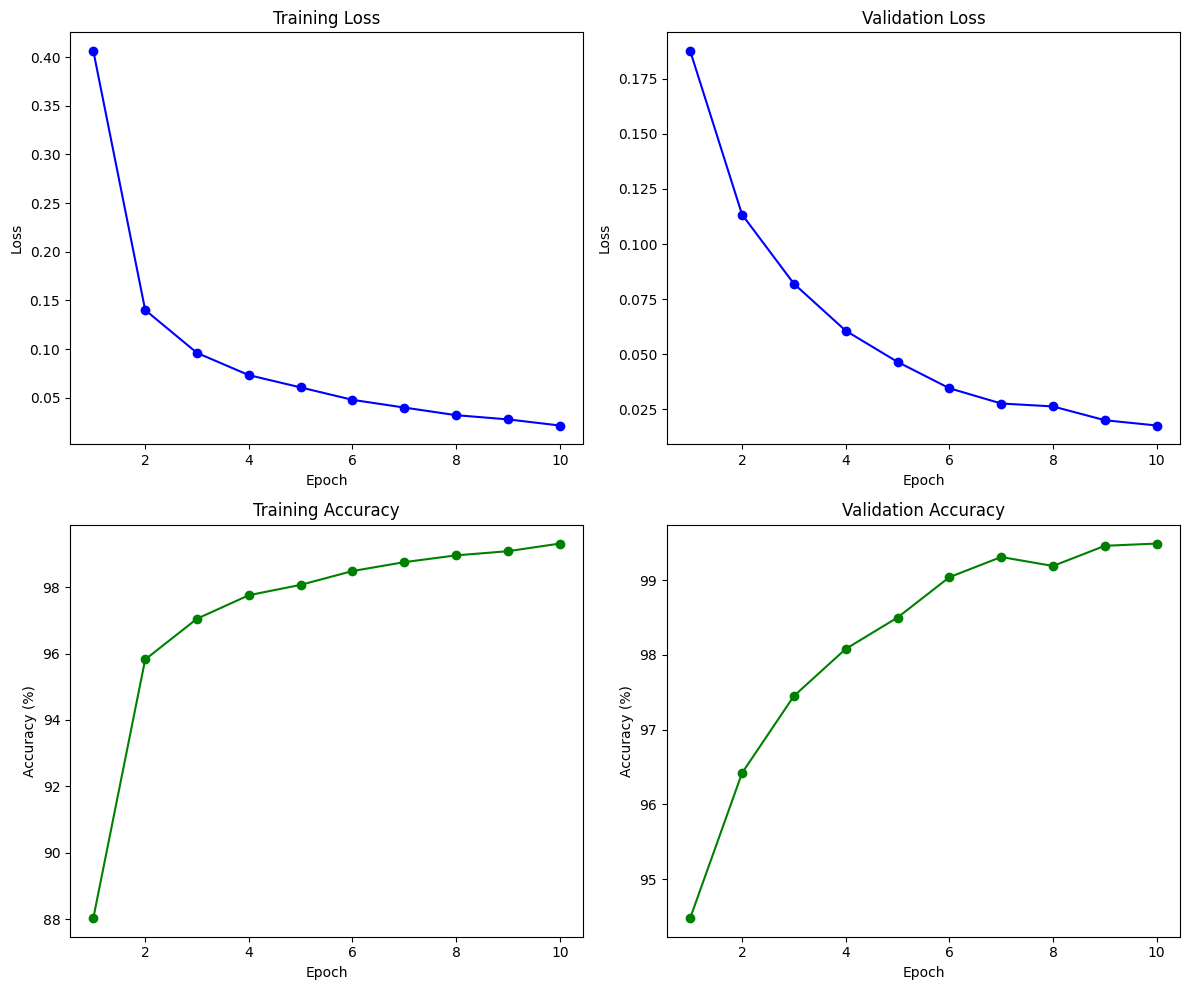

In [ ]:
batch_size = 32

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_6 = FeedforwardNN()
loss_fn_6 = nn.CrossEntropyLoss()
optimizer_6 = optim.SGD(model_6.parameters(), lr=0.1)

train(model_6, train_loader, val_loader, loss_fn_6, optimizer_6, 10)

Test Accuracy: 97.56%


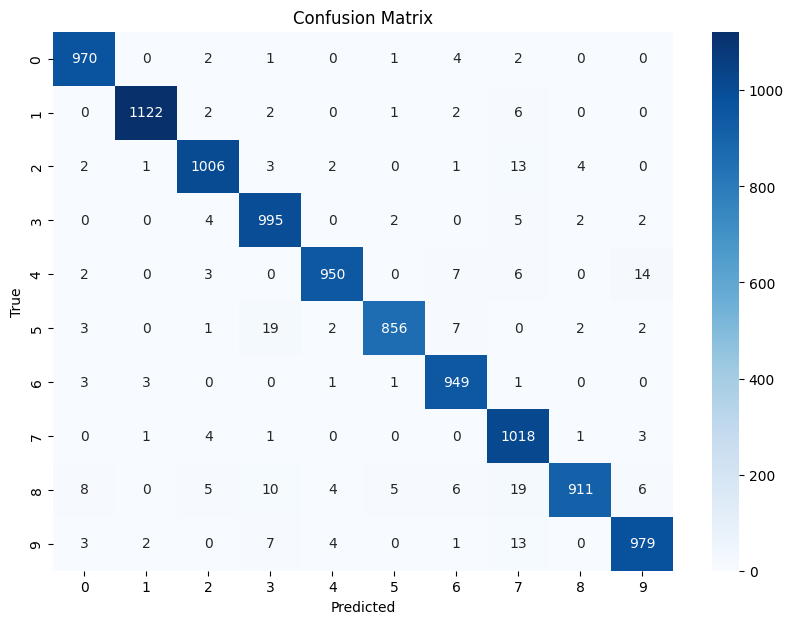

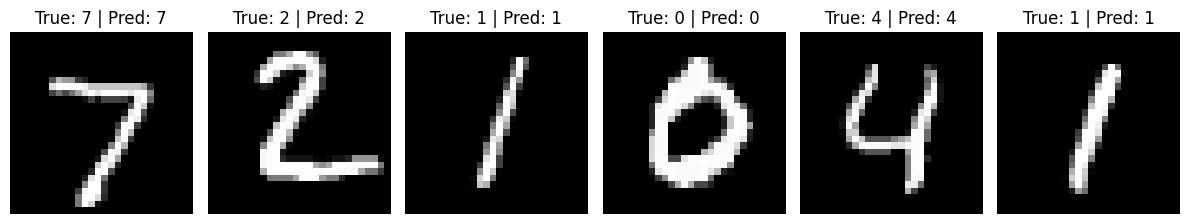

In [ ]:
test(model_6, test_loader)

### **At batch size = 64**

Epoch [1/10]
Training Loss: 0.5441, Accuracy: 84.84%
Validation Loss: 0.2530, Accuracy: 92.74%
Epoch [2/10]
Training Loss: 0.1969, Accuracy: 94.25%
Validation Loss: 0.1635, Accuracy: 94.98%
Epoch [3/10]
Training Loss: 0.1347, Accuracy: 96.07%
Validation Loss: 0.1198, Accuracy: 96.38%
Epoch [4/10]
Training Loss: 0.1045, Accuracy: 96.83%
Validation Loss: 0.0930, Accuracy: 97.15%
Epoch [5/10]
Training Loss: 0.0824, Accuracy: 97.51%
Validation Loss: 0.0749, Accuracy: 97.74%
Epoch [6/10]
Training Loss: 0.0688, Accuracy: 97.90%
Validation Loss: 0.0608, Accuracy: 98.23%
Epoch [7/10]
Training Loss: 0.0561, Accuracy: 98.34%
Validation Loss: 0.0490, Accuracy: 98.69%
Epoch [8/10]
Training Loss: 0.0484, Accuracy: 98.51%
Validation Loss: 0.0423, Accuracy: 98.84%
Epoch [9/10]
Training Loss: 0.0414, Accuracy: 98.73%
Validation Loss: 0.0344, Accuracy: 99.16%
Epoch [10/10]
Training Loss: 0.0345, Accuracy: 98.97%
Validation Loss: 0.0287, Accuracy: 99.28%


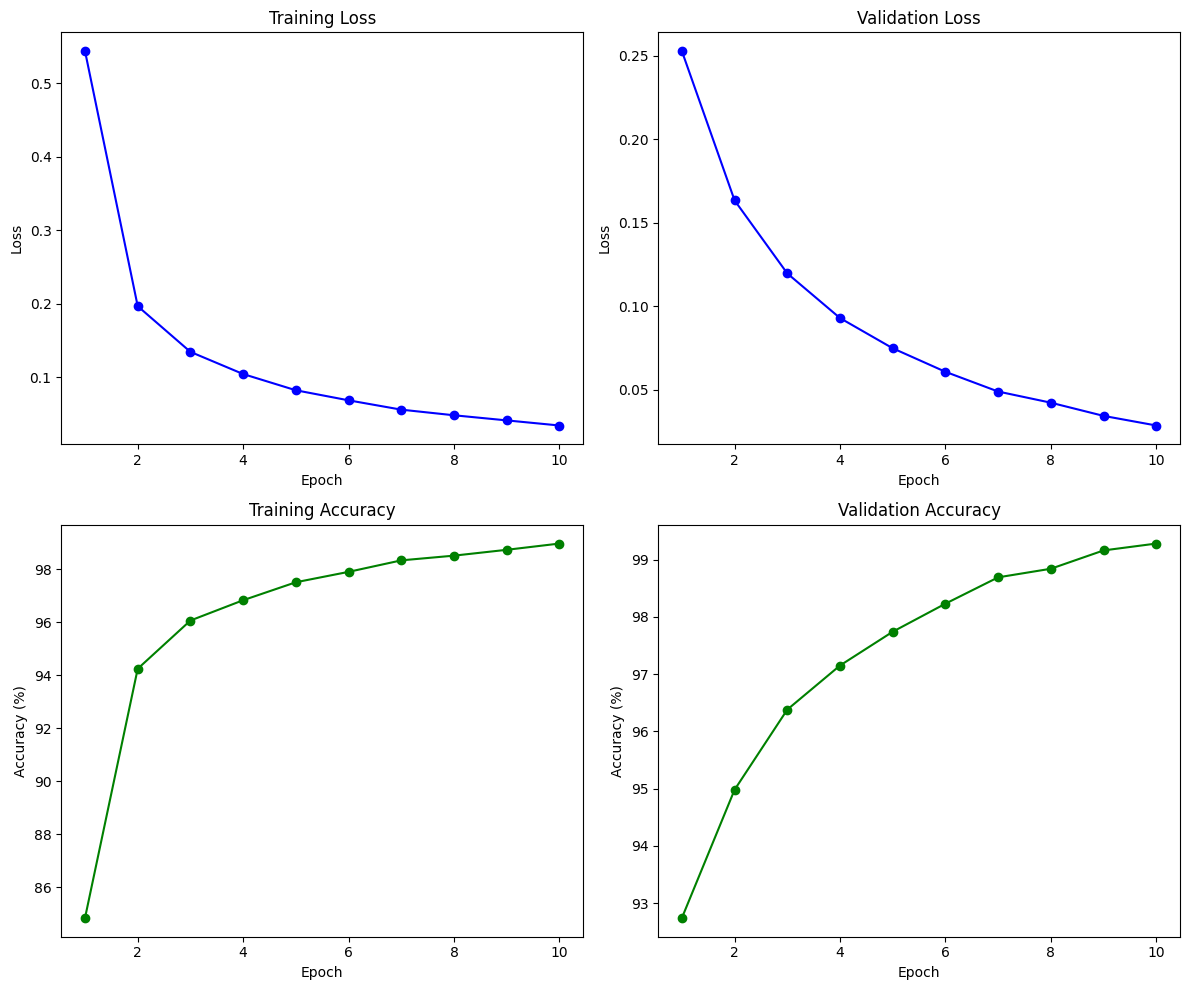

In [ ]:
batch_size = 64

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_7 = FeedforwardNN()
loss_fn_7 = nn.CrossEntropyLoss()
optimizer_7 = optim.SGD(model_7.parameters(), lr=0.1)

train(model_7, train_loader, val_loader, loss_fn_7, optimizer_7, 10)

Test Accuracy: 97.87%


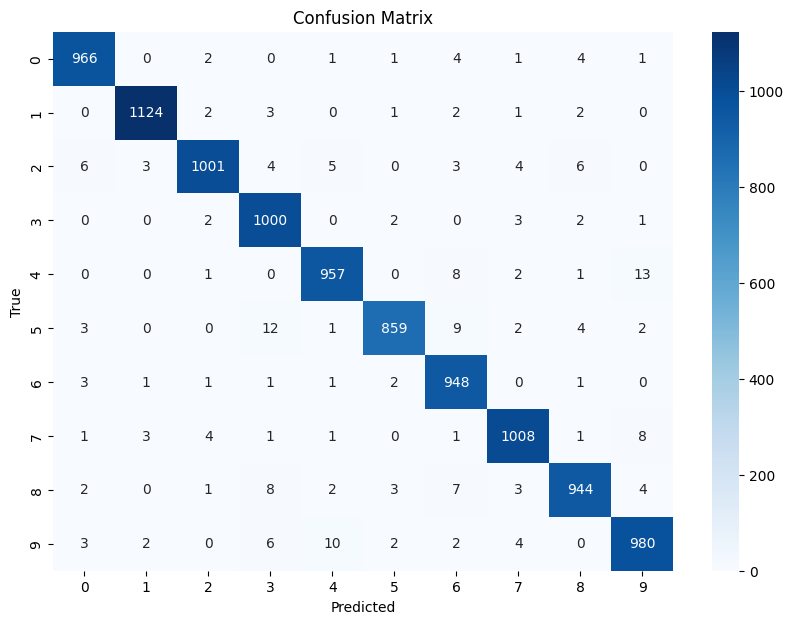

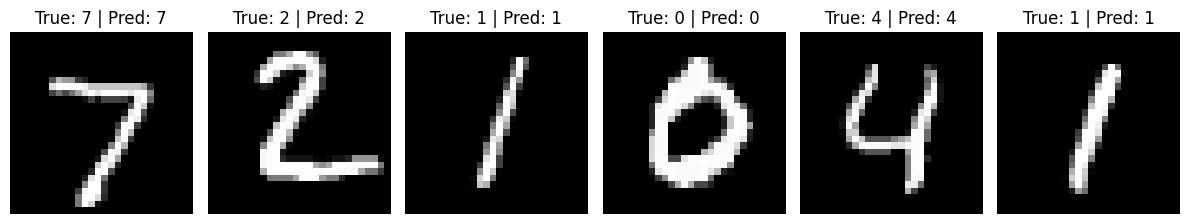

In [ ]:
test(model_7, test_loader)

### **At batch size = 128**

Epoch [1/10]
Training Loss: 0.7892, Accuracy: 77.90%
Validation Loss: 0.3426, Accuracy: 90.05%
Epoch [2/10]
Training Loss: 0.2855, Accuracy: 91.65%
Validation Loss: 0.2387, Accuracy: 92.99%
Epoch [3/10]
Training Loss: 0.2071, Accuracy: 93.93%
Validation Loss: 0.1817, Accuracy: 94.56%
Epoch [4/10]
Training Loss: 0.1619, Accuracy: 95.24%
Validation Loss: 0.1472, Accuracy: 95.60%
Epoch [5/10]
Training Loss: 0.1316, Accuracy: 96.17%
Validation Loss: 0.1227, Accuracy: 96.30%
Epoch [6/10]
Training Loss: 0.1101, Accuracy: 96.82%
Validation Loss: 0.1036, Accuracy: 96.99%
Epoch [7/10]
Training Loss: 0.0944, Accuracy: 97.24%
Validation Loss: 0.0892, Accuracy: 97.36%
Epoch [8/10]
Training Loss: 0.0826, Accuracy: 97.57%
Validation Loss: 0.0776, Accuracy: 97.71%
Epoch [9/10]
Training Loss: 0.0729, Accuracy: 97.80%
Validation Loss: 0.0679, Accuracy: 98.13%
Epoch [10/10]
Training Loss: 0.0656, Accuracy: 98.09%
Validation Loss: 0.0609, Accuracy: 98.23%


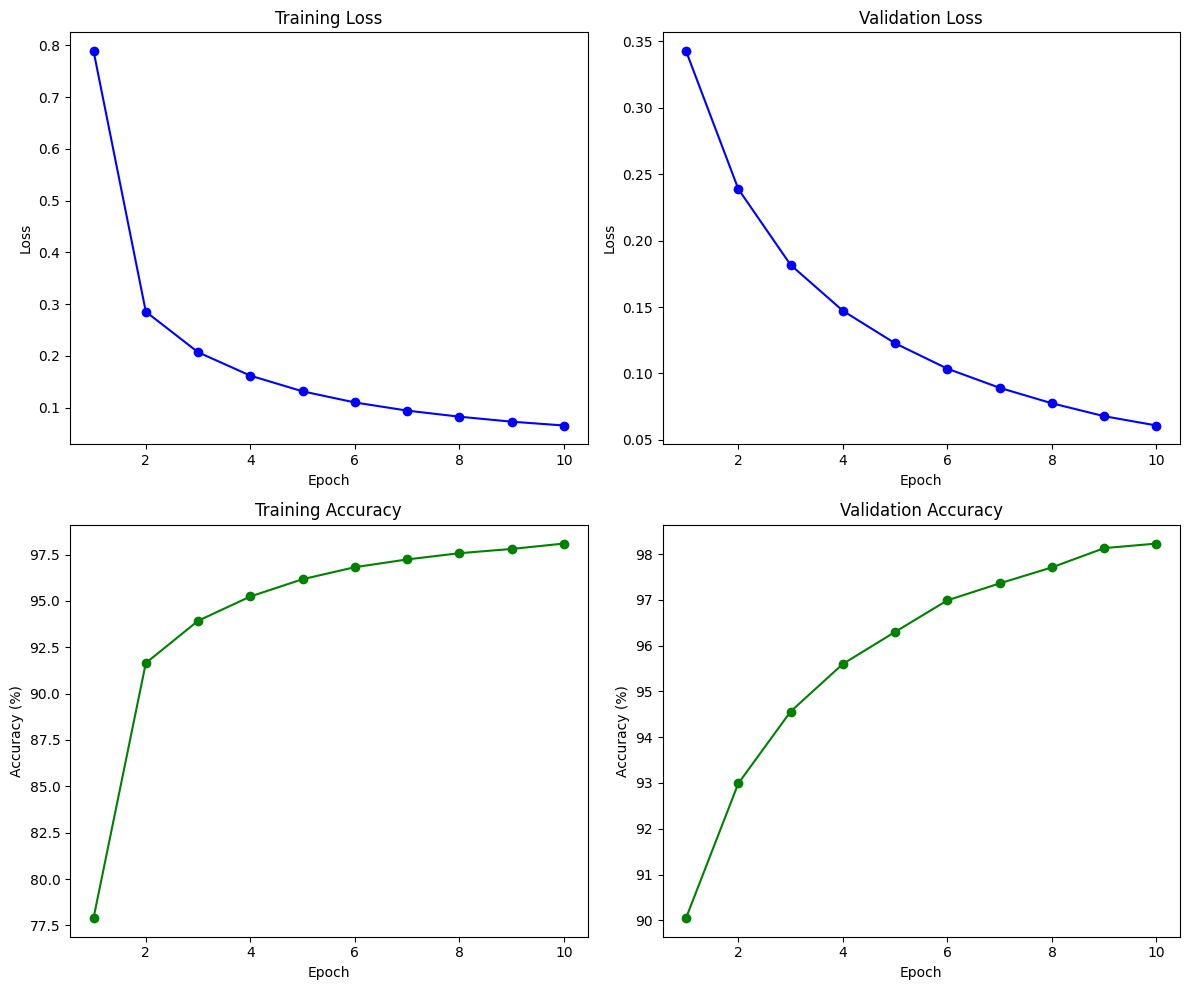

In [ ]:
batch_size = 128

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_8 = FeedforwardNN()
loss_fn_8 = nn.CrossEntropyLoss()
optimizer_8 = optim.SGD(model_8.parameters(), lr=0.1)

train(model_8, train_loader, val_loader, loss_fn_8, optimizer_8, 10)

Test Accuracy: 97.47%


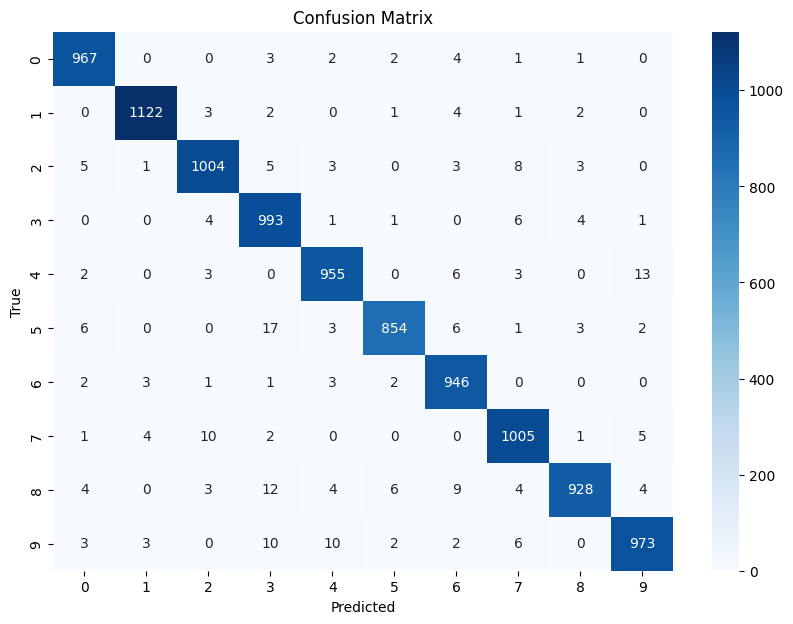

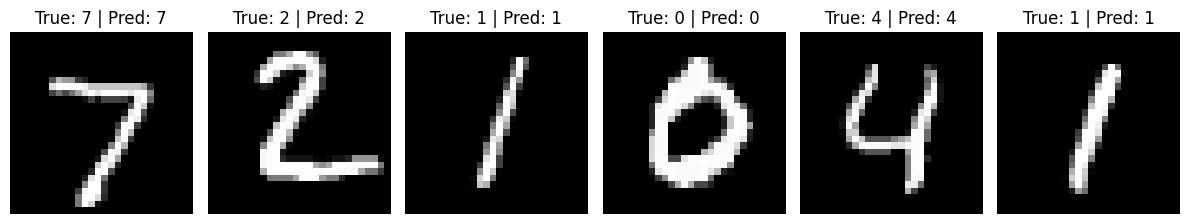

In [ ]:
test(model_8, test_loader)

### **At batch size = 256**

Epoch [1/10]
Training Loss: 1.1587, Accuracy: 67.50%
Validation Loss: 0.4378, Accuracy: 87.48%
Epoch [2/10]
Training Loss: 0.3725, Accuracy: 89.24%
Validation Loss: 0.3222, Accuracy: 90.95%
Epoch [3/10]
Training Loss: 0.3003, Accuracy: 91.38%
Validation Loss: 0.2726, Accuracy: 91.97%
Epoch [4/10]
Training Loss: 0.2539, Accuracy: 92.68%
Validation Loss: 0.2331, Accuracy: 93.14%
Epoch [5/10]
Training Loss: 0.2183, Accuracy: 93.80%
Validation Loss: 0.2029, Accuracy: 93.87%
Epoch [6/10]
Training Loss: 0.1899, Accuracy: 94.53%
Validation Loss: 0.1794, Accuracy: 94.59%
Epoch [7/10]
Training Loss: 0.1669, Accuracy: 95.21%
Validation Loss: 0.1598, Accuracy: 95.31%
Epoch [8/10]
Training Loss: 0.1499, Accuracy: 95.68%
Validation Loss: 0.1440, Accuracy: 95.77%
Epoch [9/10]
Training Loss: 0.1360, Accuracy: 96.11%
Validation Loss: 0.1311, Accuracy: 96.10%
Epoch [10/10]
Training Loss: 0.1225, Accuracy: 96.55%
Validation Loss: 0.1199, Accuracy: 96.50%


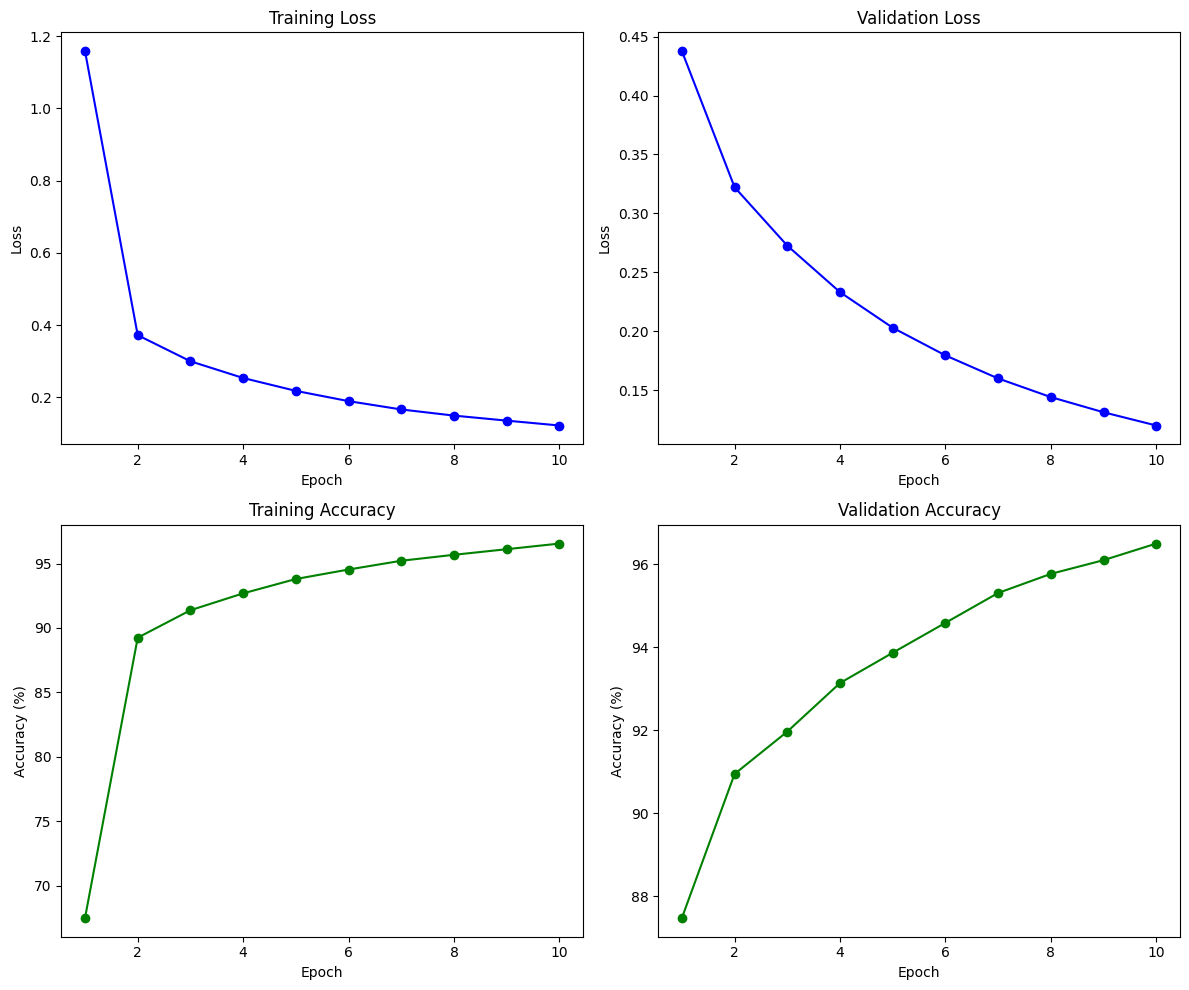

In [ ]:
batch_size = 256

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_9 = FeedforwardNN()
loss_fn_9 = nn.CrossEntropyLoss()
optimizer_9 = optim.SGD(model_9.parameters(), lr=0.1)

train(model_9, train_loader, val_loader, loss_fn_9, optimizer_9, 10)

Test Accuracy: 96.40%


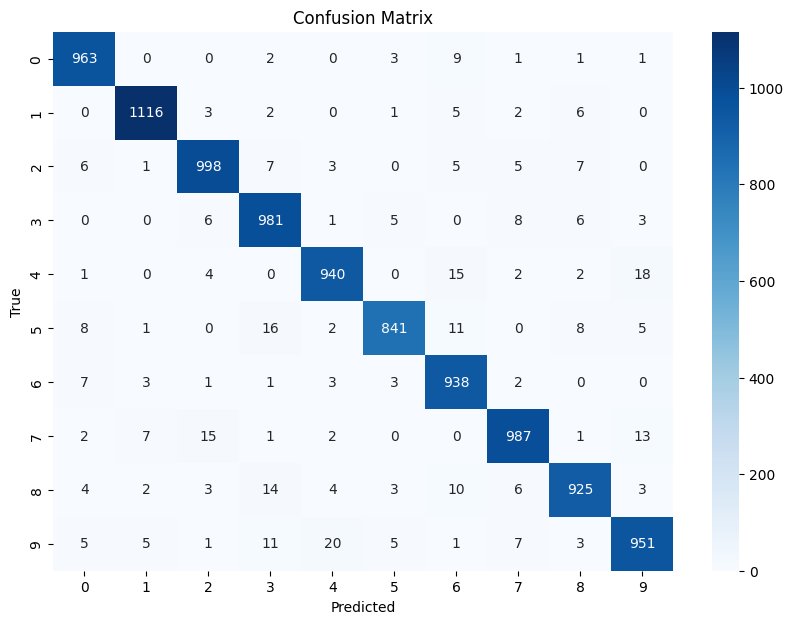

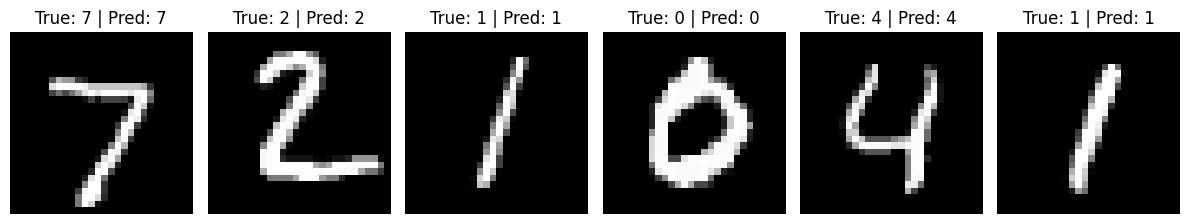

In [ ]:
test(model_9, test_loader)

### **At batch size = 512**

Epoch [1/10]
Training Loss: 1.8173, Accuracy: 51.44%
Validation Loss: 0.8217, Accuracy: 78.26%
Epoch [2/10]
Training Loss: 0.5391, Accuracy: 85.21%
Validation Loss: 0.4269, Accuracy: 88.17%
Epoch [3/10]
Training Loss: 0.3874, Accuracy: 88.94%
Validation Loss: 0.3554, Accuracy: 90.16%
Epoch [4/10]
Training Loss: 0.3352, Accuracy: 90.35%
Validation Loss: 0.3173, Accuracy: 91.03%
Epoch [5/10]
Training Loss: 0.3022, Accuracy: 91.23%
Validation Loss: 0.2885, Accuracy: 91.80%
Epoch [6/10]
Training Loss: 0.2767, Accuracy: 91.97%
Validation Loss: 0.2670, Accuracy: 92.33%
Epoch [7/10]
Training Loss: 0.2559, Accuracy: 92.68%
Validation Loss: 0.2477, Accuracy: 93.01%
Epoch [8/10]
Training Loss: 0.2379, Accuracy: 93.23%
Validation Loss: 0.2314, Accuracy: 93.44%
Epoch [9/10]
Training Loss: 0.2224, Accuracy: 93.66%
Validation Loss: 0.2178, Accuracy: 93.86%
Epoch [10/10]
Training Loss: 0.2077, Accuracy: 94.03%
Validation Loss: 0.2046, Accuracy: 94.33%


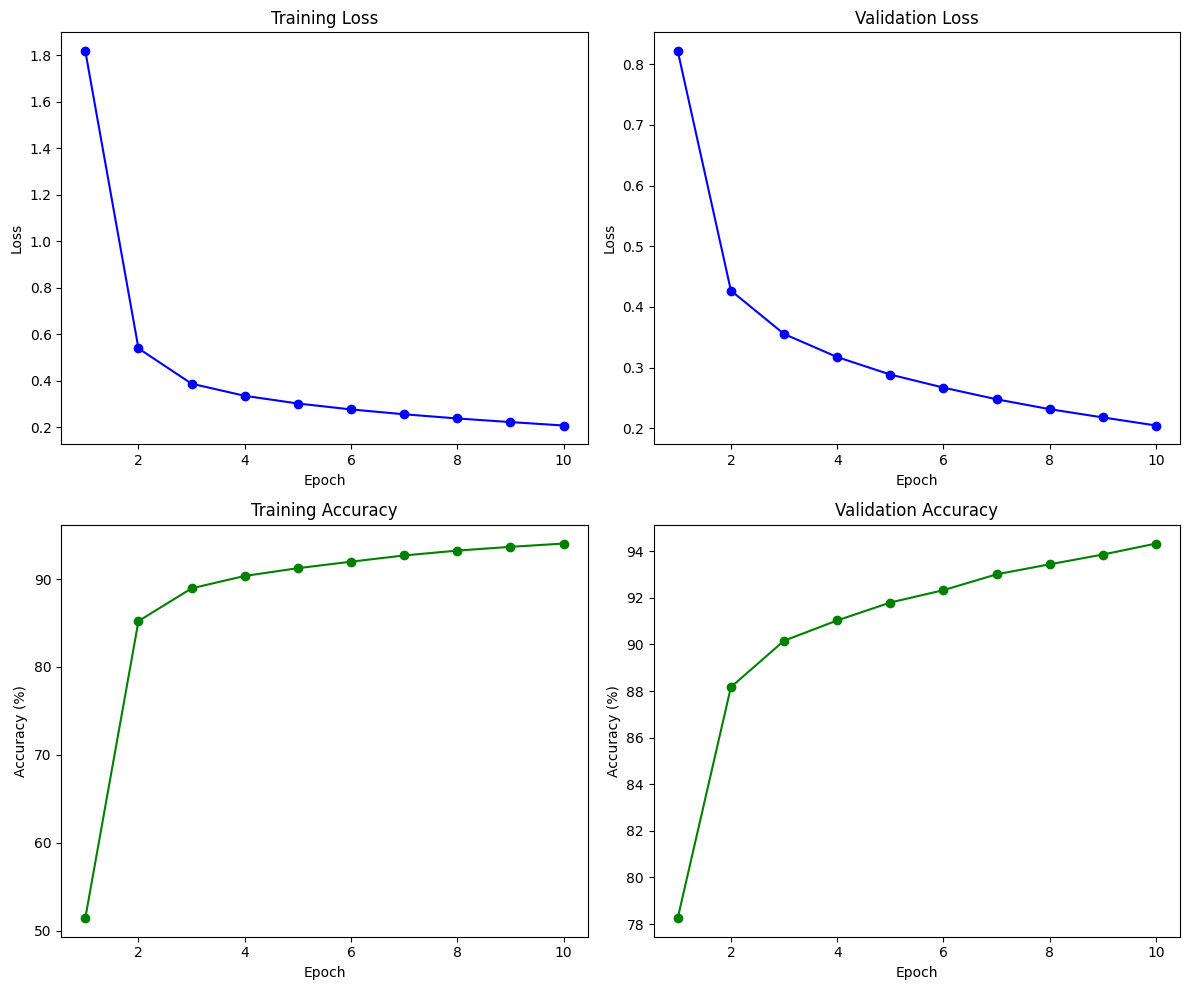

In [ ]:
batch_size = 512

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_10 = FeedforwardNN()
loss_fn_10 = nn.CrossEntropyLoss()
optimizer_10 = optim.SGD(model_10.parameters(), lr=0.1)

train(model_10, train_loader, val_loader, loss_fn_10, optimizer_10, 10)

Test Accuracy: 94.28%


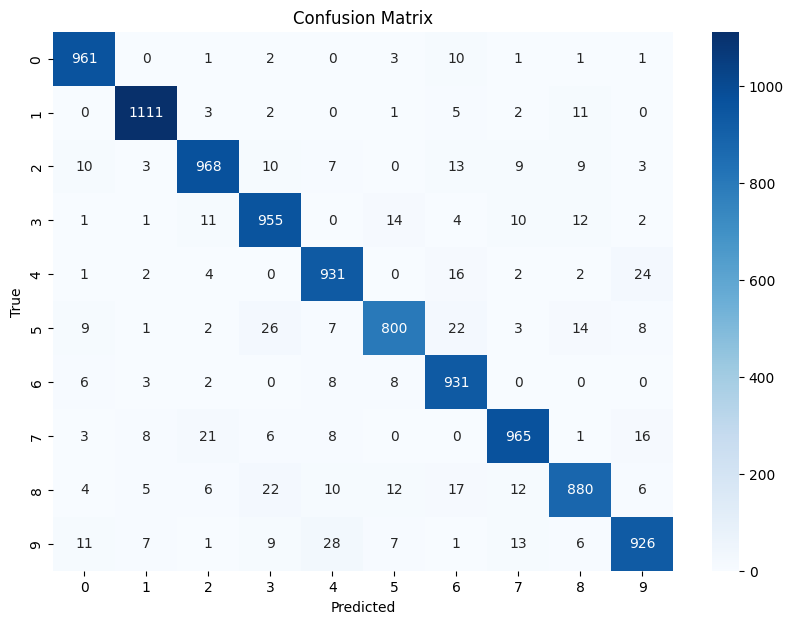

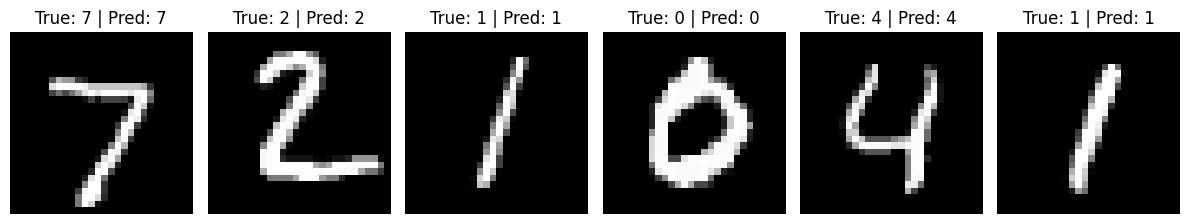

In [ ]:
test(model_10, test_loader)

* At batch size = **32** --- Accuracy = **97.56%**
* At batch size = **64** --- Accuracy = **97.87%**
* At batch size = **128** --- Accuracy = **97.47%**
* At batch size = **256** --- Accuracy = **96.40%**
* At batch size = **512** --- Accuracy = **94.28%**

Then we choose batch size = **64** which is model_7 as it gives the highest accuracy

# Change number of neurons and layers  
* Learning rate = 0.1
* Batch size = 64

In [13]:
batch_size = 64

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Changing Neurons Only
* Three layers

### **Neurons - 64 and 32**

Epoch [1/10]
Training Loss: 0.5768, Accuracy: 83.19%
Validation Loss: 0.2624, Accuracy: 92.50%
Epoch [2/10]
Training Loss: 0.2049, Accuracy: 93.97%
Validation Loss: 0.1701, Accuracy: 95.10%
Epoch [3/10]
Training Loss: 0.1458, Accuracy: 95.70%
Validation Loss: 0.1289, Accuracy: 96.07%
Epoch [4/10]
Training Loss: 0.1161, Accuracy: 96.61%
Validation Loss: 0.1067, Accuracy: 96.75%
Epoch [5/10]
Training Loss: 0.0965, Accuracy: 97.18%
Validation Loss: 0.0891, Accuracy: 97.29%
Epoch [6/10]
Training Loss: 0.0822, Accuracy: 97.52%
Validation Loss: 0.0769, Accuracy: 97.94%
Epoch [7/10]
Training Loss: 0.0726, Accuracy: 97.79%
Validation Loss: 0.0684, Accuracy: 98.14%
Epoch [8/10]
Training Loss: 0.0644, Accuracy: 97.98%
Validation Loss: 0.0596, Accuracy: 98.39%
Epoch [9/10]
Training Loss: 0.0588, Accuracy: 98.18%
Validation Loss: 0.0553, Accuracy: 98.56%
Epoch [10/10]
Training Loss: 0.0514, Accuracy: 98.41%
Validation Loss: 0.0492, Accuracy: 98.69%


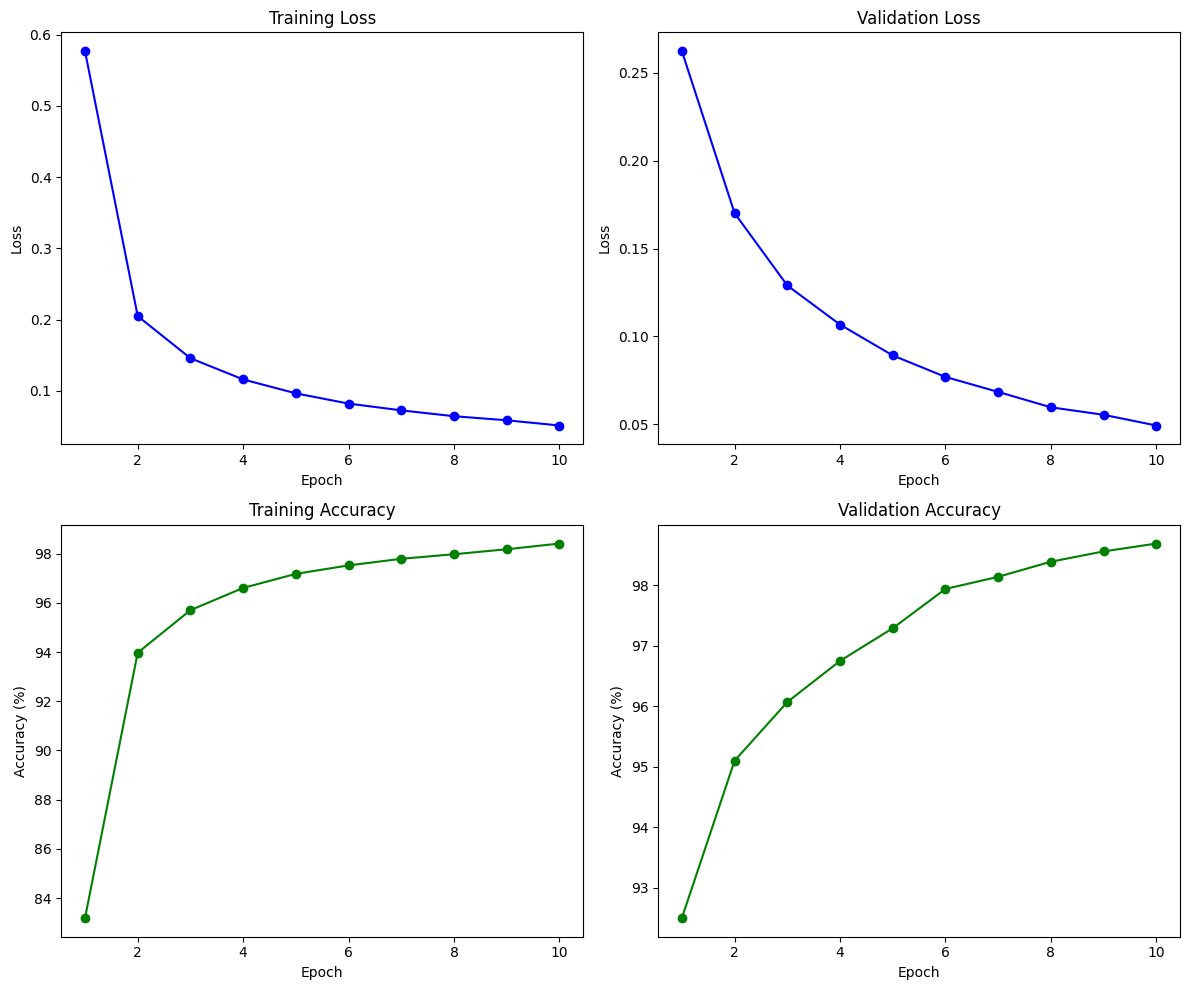

In [14]:
class FeedforwardNN_1(nn.Module):
    def __init__(self):
        super(FeedforwardNN_1, self).__init__()

        self.l1 = nn.Linear(784, 64)
        self.l2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x

model_11 = FeedforwardNN_1()
loss_fn_11 = nn.CrossEntropyLoss()
optimizer_11 = optim.SGD(model_11.parameters(), lr=0.1)

train(model_11, train_loader, val_loader, loss_fn_11, optimizer_11, 10)

Test Accuracy: 97.53%


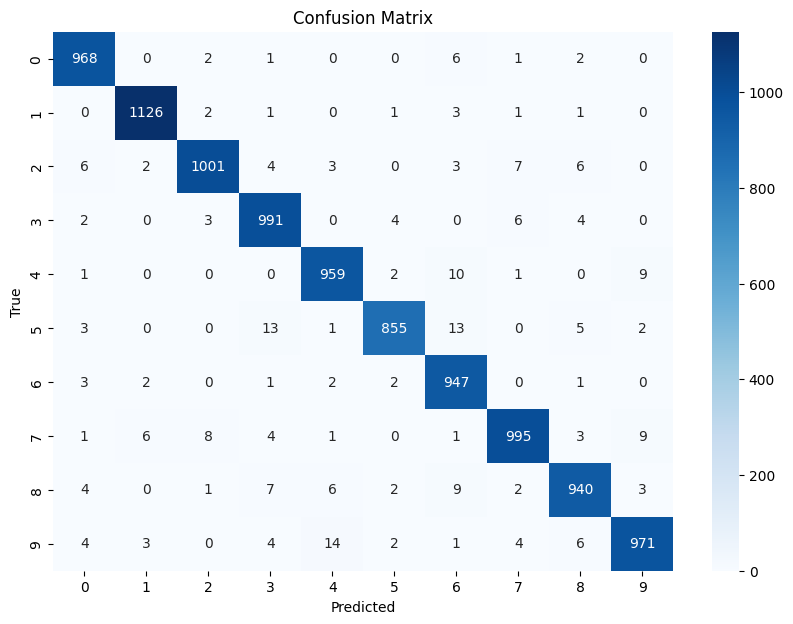

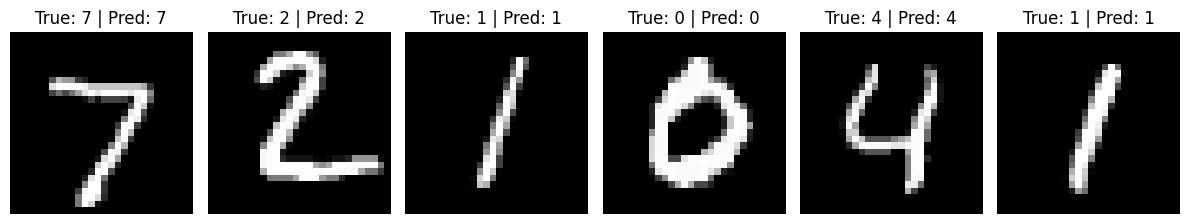

In [15]:
test(model_11, test_loader)

### **Neurons - 512 and 256**



Epoch [1/10]
Training Loss: 0.5122, Accuracy: 85.50%
Validation Loss: 0.2400, Accuracy: 92.97%
Epoch [2/10]
Training Loss: 0.1804, Accuracy: 94.71%
Validation Loss: 0.1465, Accuracy: 95.61%
Epoch [3/10]
Training Loss: 0.1169, Accuracy: 96.52%
Validation Loss: 0.1035, Accuracy: 97.03%
Epoch [4/10]
Training Loss: 0.0869, Accuracy: 97.41%
Validation Loss: 0.0778, Accuracy: 97.79%
Epoch [5/10]
Training Loss: 0.0668, Accuracy: 97.98%
Validation Loss: 0.0597, Accuracy: 98.31%
Epoch [6/10]
Training Loss: 0.0532, Accuracy: 98.40%
Validation Loss: 0.0474, Accuracy: 98.73%
Epoch [7/10]
Training Loss: 0.0438, Accuracy: 98.70%
Validation Loss: 0.0366, Accuracy: 99.15%
Epoch [8/10]
Training Loss: 0.0355, Accuracy: 98.98%
Validation Loss: 0.0295, Accuracy: 99.34%
Epoch [9/10]
Training Loss: 0.0285, Accuracy: 99.21%
Validation Loss: 0.0248, Accuracy: 99.42%
Epoch [10/10]
Training Loss: 0.0239, Accuracy: 99.38%
Validation Loss: 0.0182, Accuracy: 99.63%


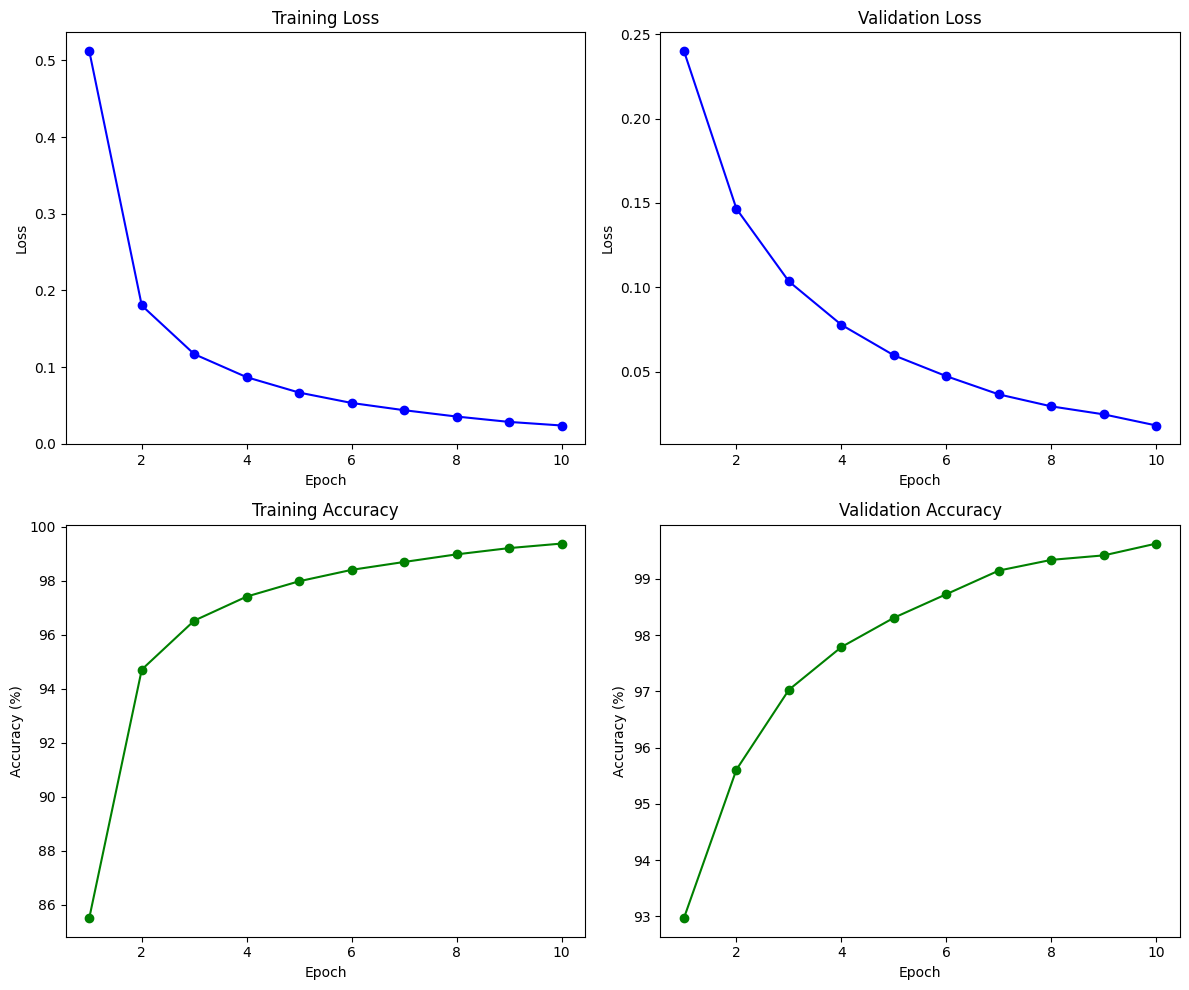

In [16]:
class FeedforwardNN_2(nn.Module):
    def __init__(self):
        super(FeedforwardNN_2, self).__init__()

        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 256)
        self.output = nn.Linear(256, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x

model_12 = FeedforwardNN_2()
loss_fn_12 = nn.CrossEntropyLoss()
optimizer_12 = optim.SGD(model_12.parameters(), lr=0.1)

train(model_12, train_loader, val_loader, loss_fn_12, optimizer_12, 10)

Test Accuracy: 98.22%


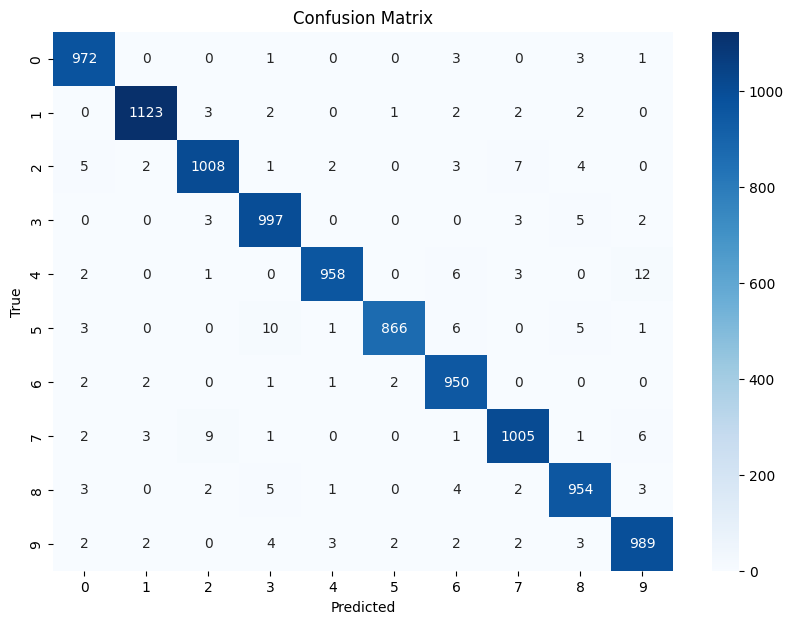

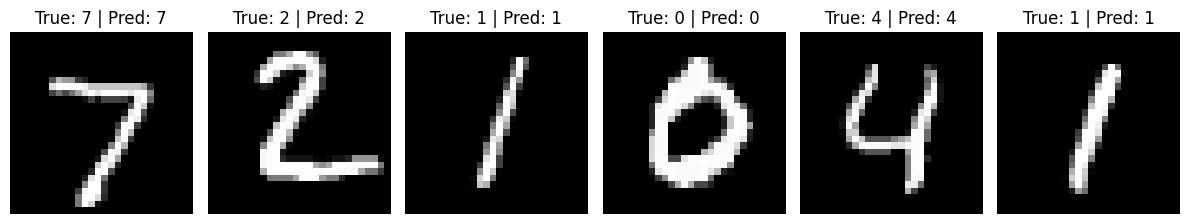

In [17]:
test(model_12, test_loader)

  ### **Neurons - 128 and 128**

Epoch [1/10]
Training Loss: 0.5681, Accuracy: 83.18%
Validation Loss: 0.2601, Accuracy: 92.17%
Epoch [2/10]
Training Loss: 0.2041, Accuracy: 93.97%
Validation Loss: 0.1682, Accuracy: 95.00%
Epoch [3/10]
Training Loss: 0.1379, Accuracy: 95.87%
Validation Loss: 0.1192, Accuracy: 96.37%
Epoch [4/10]
Training Loss: 0.1031, Accuracy: 96.94%
Validation Loss: 0.0919, Accuracy: 97.26%
Epoch [5/10]
Training Loss: 0.0825, Accuracy: 97.53%
Validation Loss: 0.0739, Accuracy: 97.88%
Epoch [6/10]
Training Loss: 0.0677, Accuracy: 97.96%
Validation Loss: 0.0608, Accuracy: 98.34%
Epoch [7/10]
Training Loss: 0.0575, Accuracy: 98.20%
Validation Loss: 0.0498, Accuracy: 98.55%
Epoch [8/10]
Training Loss: 0.0487, Accuracy: 98.56%
Validation Loss: 0.0422, Accuracy: 98.92%
Epoch [9/10]
Training Loss: 0.0412, Accuracy: 98.77%
Validation Loss: 0.0355, Accuracy: 99.07%
Epoch [10/10]
Training Loss: 0.0356, Accuracy: 98.95%
Validation Loss: 0.0310, Accuracy: 99.20%


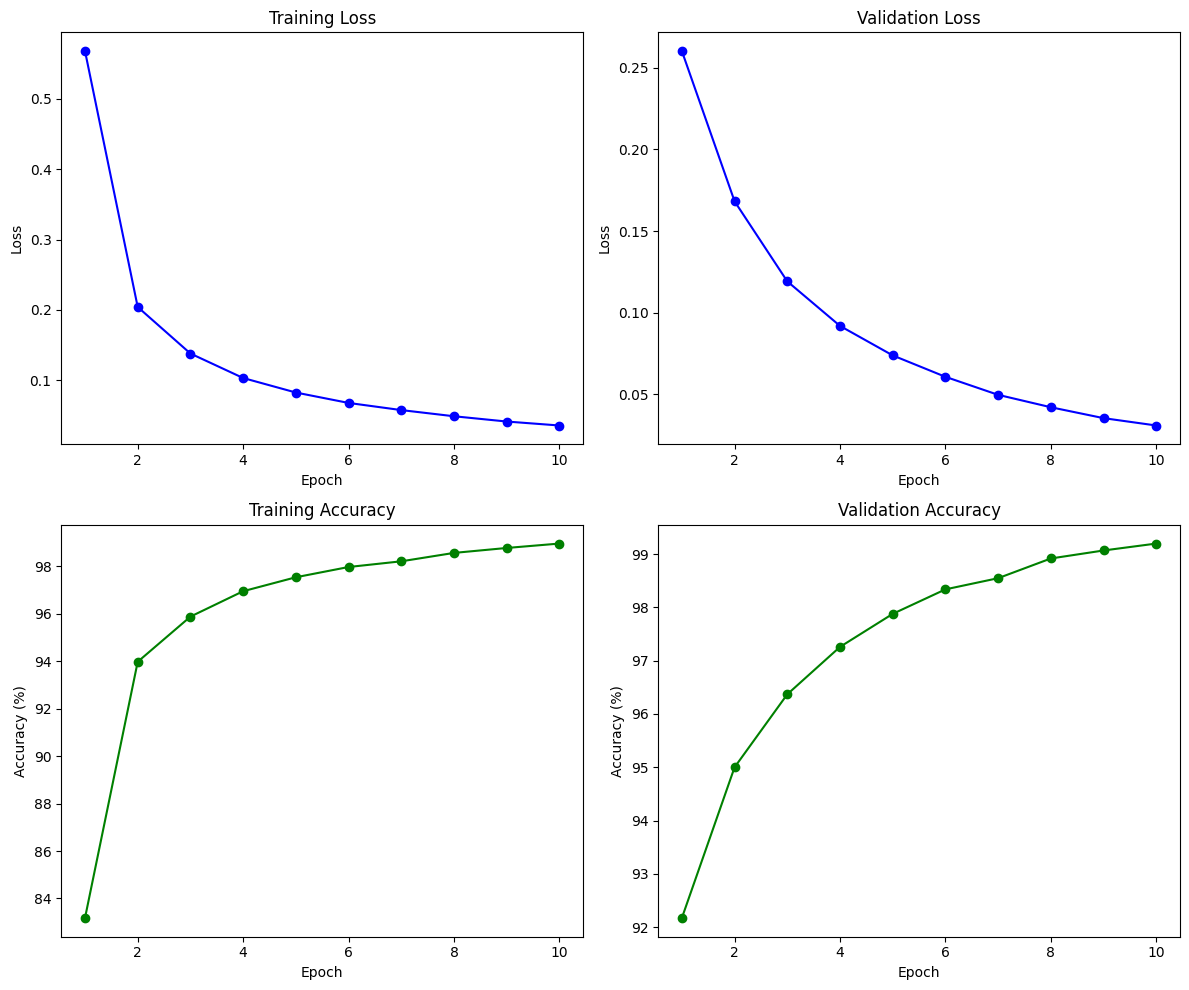

In [18]:
class FeedforwardNN_3(nn.Module):
    def __init__(self):
        super(FeedforwardNN_3, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


model_13 = FeedforwardNN_3()
loss_fn_13 = nn.CrossEntropyLoss()
optimizer_13 = optim.SGD(model_13.parameters(), lr=0.1)

train(model_13, train_loader, val_loader, loss_fn_13, optimizer_13, 10)

Test Accuracy: 97.90%


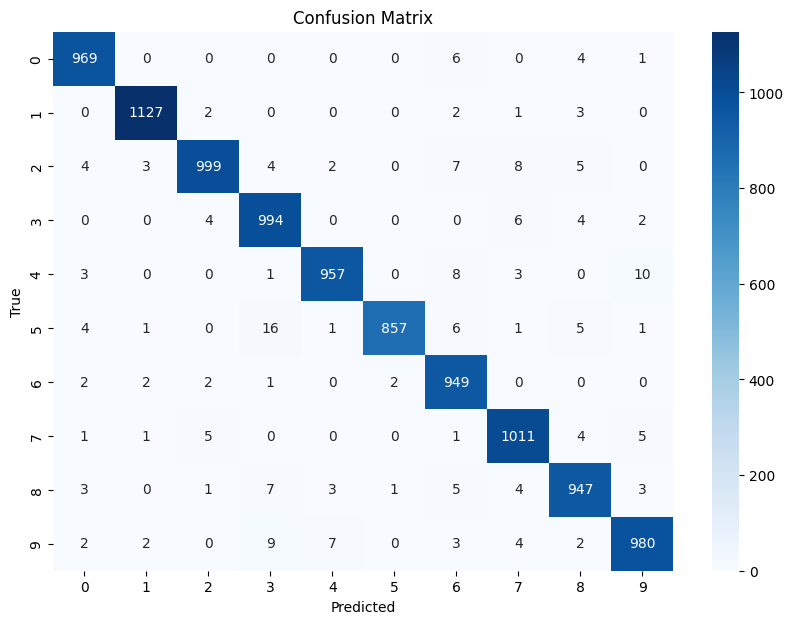

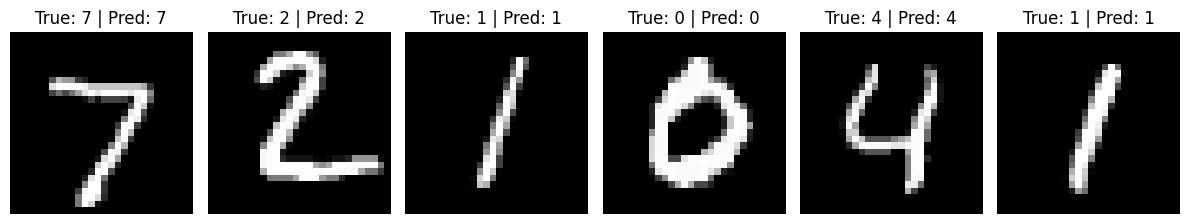

In [19]:
test(model_13, test_loader)

### **Neurons - 256 and 128**

Epoch [1/10]
Training Loss: 0.5411, Accuracy: 84.33%
Validation Loss: 0.2478, Accuracy: 92.86%
Epoch [2/10]
Training Loss: 0.1872, Accuracy: 94.56%
Validation Loss: 0.1513, Accuracy: 95.40%
Epoch [3/10]
Training Loss: 0.1244, Accuracy: 96.29%
Validation Loss: 0.1063, Accuracy: 96.89%
Epoch [4/10]
Training Loss: 0.0926, Accuracy: 97.26%
Validation Loss: 0.0817, Accuracy: 97.61%
Epoch [5/10]
Training Loss: 0.0733, Accuracy: 97.80%
Validation Loss: 0.0641, Accuracy: 98.21%
Epoch [6/10]
Training Loss: 0.0594, Accuracy: 98.24%
Validation Loss: 0.0528, Accuracy: 98.62%
Epoch [7/10]
Training Loss: 0.0487, Accuracy: 98.53%
Validation Loss: 0.0422, Accuracy: 98.99%
Epoch [8/10]
Training Loss: 0.0409, Accuracy: 98.79%
Validation Loss: 0.0339, Accuracy: 99.25%
Epoch [9/10]
Training Loss: 0.0336, Accuracy: 99.04%
Validation Loss: 0.0287, Accuracy: 99.34%
Epoch [10/10]
Training Loss: 0.0270, Accuracy: 99.24%
Validation Loss: 0.0235, Accuracy: 99.50%


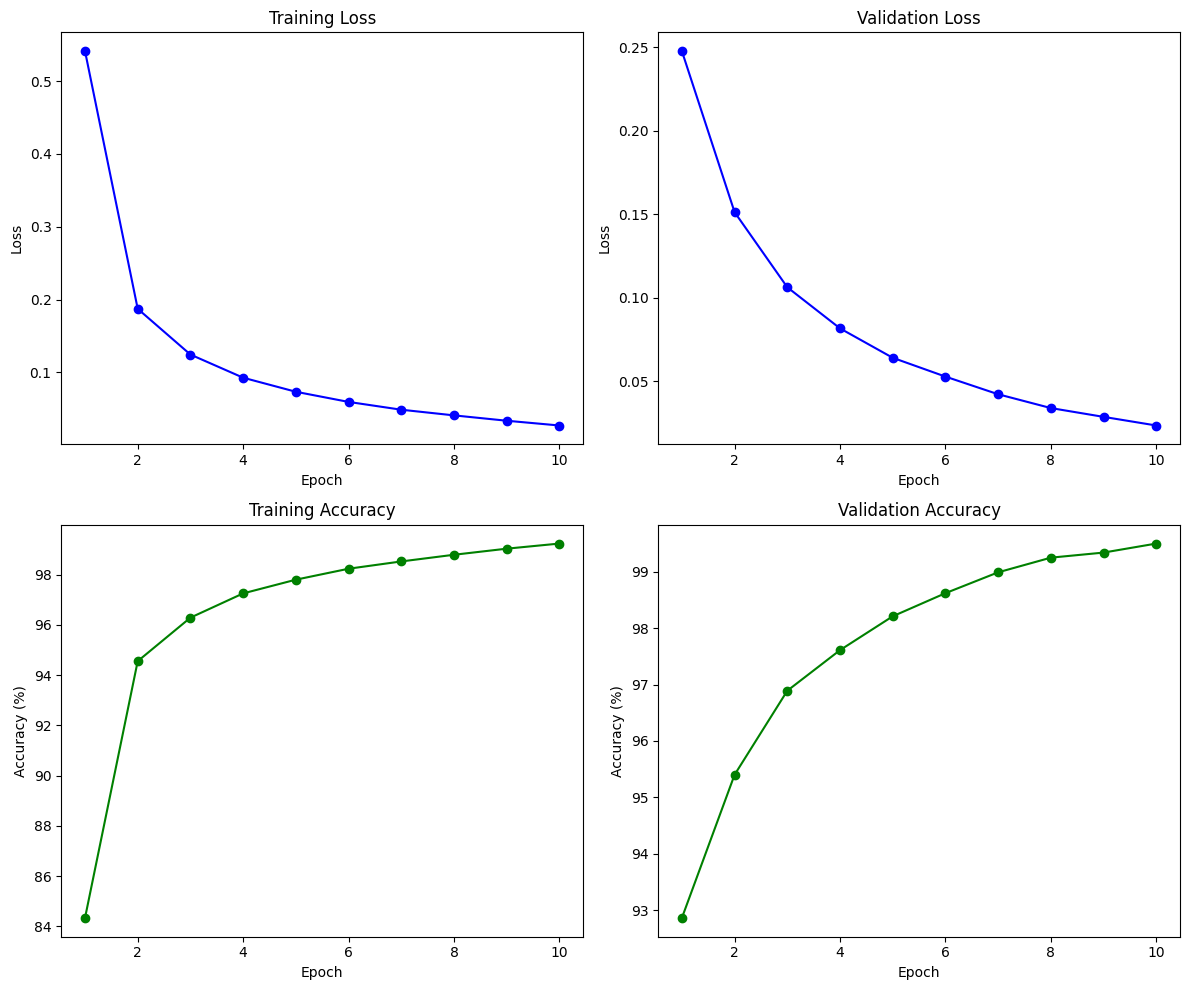

In [20]:
class FeedforwardNN_4(nn.Module):
    def __init__(self):
        super(FeedforwardNN_4, self).__init__()

        self.l1 = nn.Linear(784, 256)
        self.l2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


model_14 = FeedforwardNN_4()
loss_fn_14 = nn.CrossEntropyLoss()
optimizer_14 = optim.SGD(model_14.parameters(), lr=0.1)

train(model_14, train_loader, val_loader, loss_fn_14, optimizer_14, 10)

Test Accuracy: 97.96%


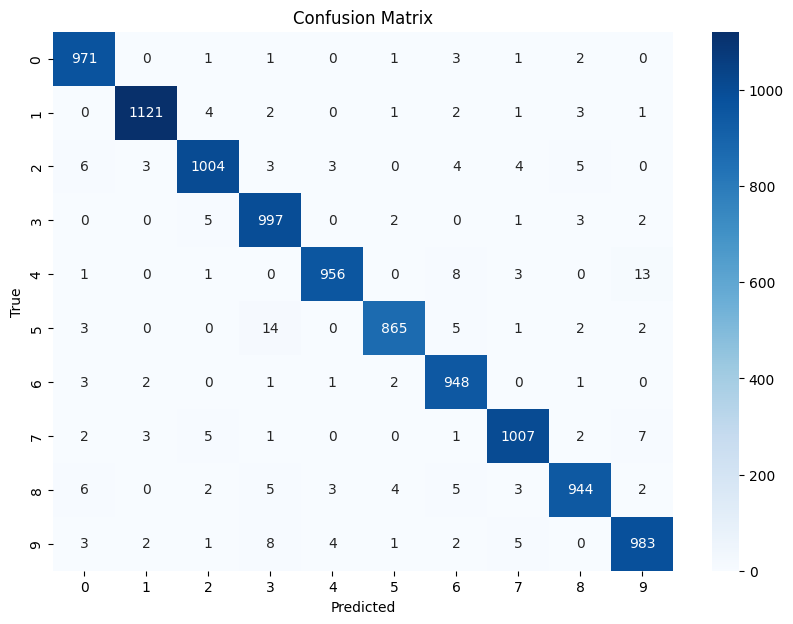

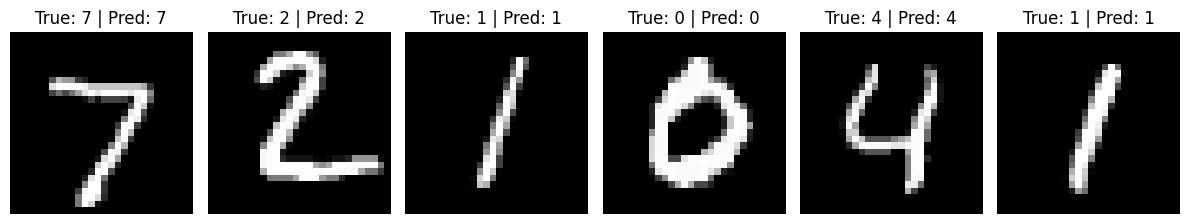

In [21]:
test(model_14, test_loader)

## Changing Layers Only
* Number of neurons per layer remains constant = 128 neurons

### **2 Layers**

Epoch [1/10]
Training Loss: 0.4762, Accuracy: 87.36%
Validation Loss: 0.2768, Accuracy: 92.03%
Epoch [2/10]
Training Loss: 0.2295, Accuracy: 93.43%
Validation Loss: 0.1976, Accuracy: 94.47%
Epoch [3/10]
Training Loss: 0.1718, Accuracy: 95.12%
Validation Loss: 0.1557, Accuracy: 95.72%
Epoch [4/10]
Training Loss: 0.1379, Accuracy: 96.01%
Validation Loss: 0.1292, Accuracy: 96.43%
Epoch [5/10]
Training Loss: 0.1155, Accuracy: 96.74%
Validation Loss: 0.1103, Accuracy: 96.94%
Epoch [6/10]
Training Loss: 0.0991, Accuracy: 97.14%
Validation Loss: 0.0959, Accuracy: 97.25%
Epoch [7/10]
Training Loss: 0.0871, Accuracy: 97.54%
Validation Loss: 0.0845, Accuracy: 97.59%
Epoch [8/10]
Training Loss: 0.0774, Accuracy: 97.83%
Validation Loss: 0.0749, Accuracy: 97.89%
Epoch [9/10]
Training Loss: 0.0688, Accuracy: 98.05%
Validation Loss: 0.0668, Accuracy: 98.15%
Epoch [10/10]
Training Loss: 0.0621, Accuracy: 98.27%
Validation Loss: 0.0606, Accuracy: 98.31%


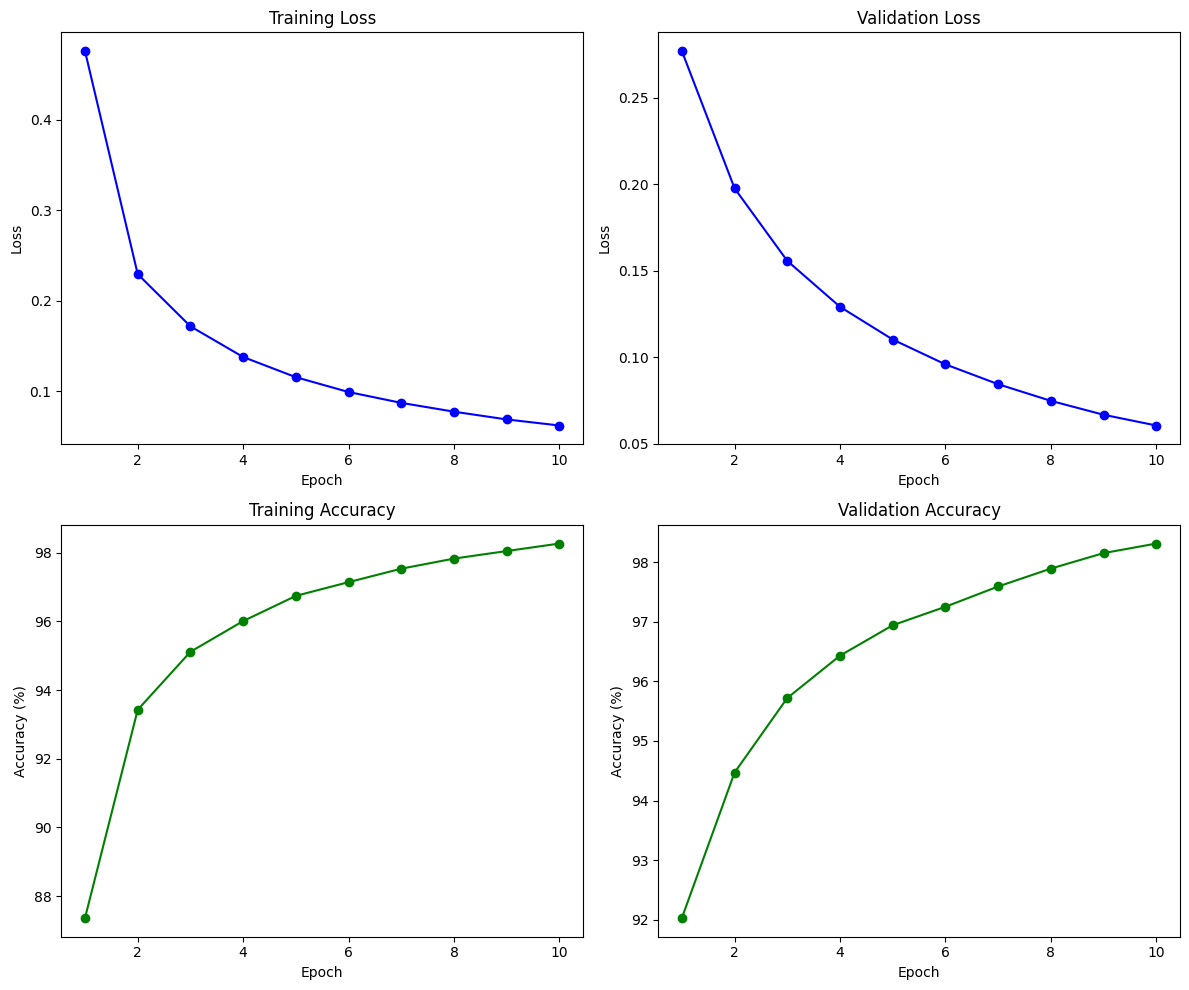

In [22]:
class FeedforwardNN_5(nn.Module):
    def __init__(self):
        super(FeedforwardNN_5, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.output(x)
        return x


model_15 = FeedforwardNN_5()
loss_fn_15 = nn.CrossEntropyLoss()
optimizer_15 = optim.SGD(model_15.parameters(), lr=0.1)

train(model_15, train_loader, val_loader, loss_fn_15, optimizer_15, 10)

Test Accuracy: 97.52%


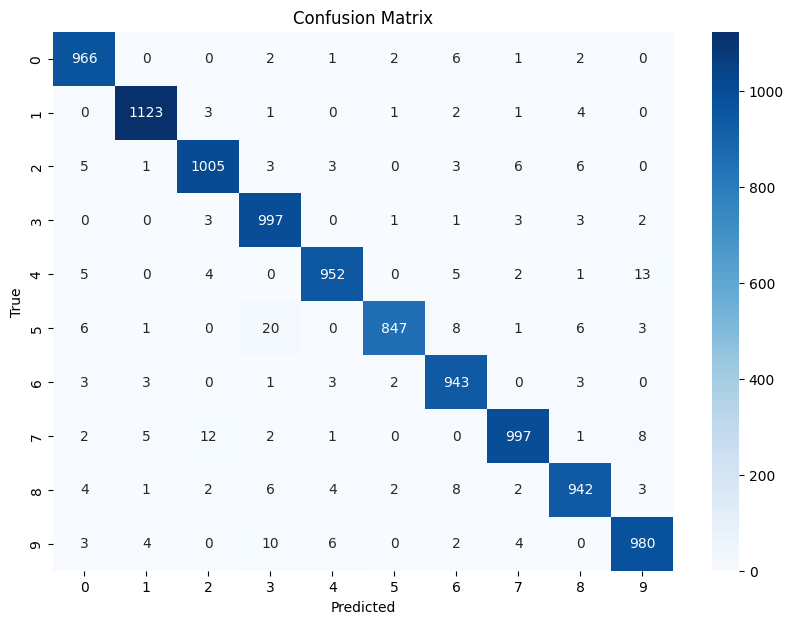

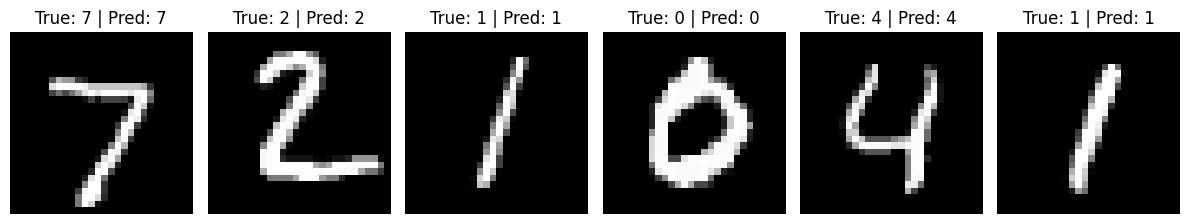

In [23]:
test(model_15, test_loader)

### **3 Layers**

Epoch [1/10]
Training Loss: 0.5478, Accuracy: 83.99%
Validation Loss: 0.2514, Accuracy: 92.59%
Epoch [2/10]
Training Loss: 0.1931, Accuracy: 94.26%
Validation Loss: 0.1587, Accuracy: 95.18%
Epoch [3/10]
Training Loss: 0.1332, Accuracy: 96.04%
Validation Loss: 0.1163, Accuracy: 96.57%
Epoch [4/10]
Training Loss: 0.1027, Accuracy: 96.90%
Validation Loss: 0.0903, Accuracy: 97.39%
Epoch [5/10]
Training Loss: 0.0825, Accuracy: 97.53%
Validation Loss: 0.0730, Accuracy: 97.89%
Epoch [6/10]
Training Loss: 0.0692, Accuracy: 97.99%
Validation Loss: 0.0598, Accuracy: 98.24%
Epoch [7/10]
Training Loss: 0.0578, Accuracy: 98.21%
Validation Loss: 0.0506, Accuracy: 98.53%
Epoch [8/10]
Training Loss: 0.0484, Accuracy: 98.51%
Validation Loss: 0.0419, Accuracy: 98.85%
Epoch [9/10]
Training Loss: 0.0419, Accuracy: 98.77%
Validation Loss: 0.0371, Accuracy: 99.05%
Epoch [10/10]
Training Loss: 0.0361, Accuracy: 98.96%
Validation Loss: 0.0306, Accuracy: 99.21%


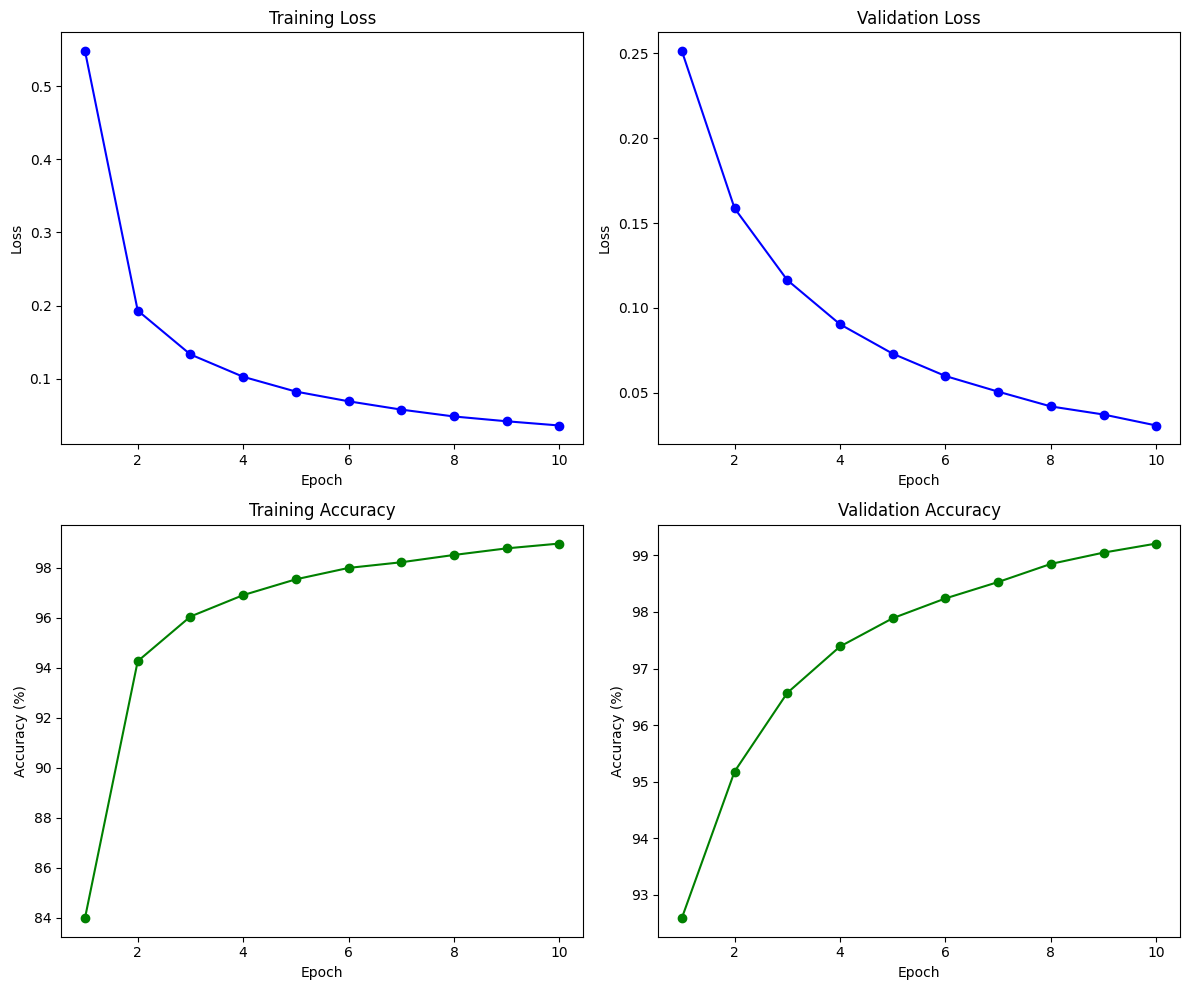

In [24]:
class FeedforwardNN_6(nn.Module):
    def __init__(self):
        super(FeedforwardNN_6, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


model_16 = FeedforwardNN_6()
loss_fn_16 = nn.CrossEntropyLoss()
optimizer_16 = optim.SGD(model_16.parameters(), lr=0.1)

train(model_16, train_loader, val_loader, loss_fn_16, optimizer_16, 10)

Test Accuracy: 97.74%


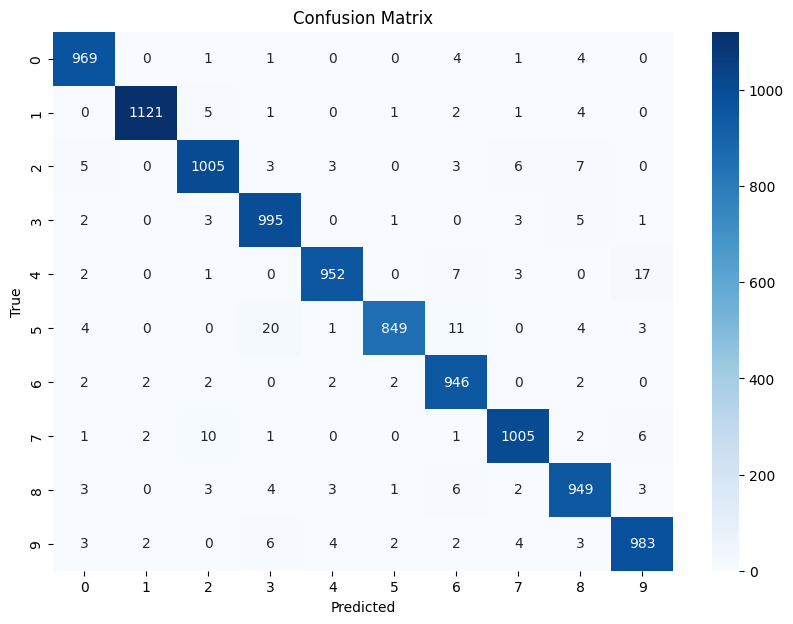

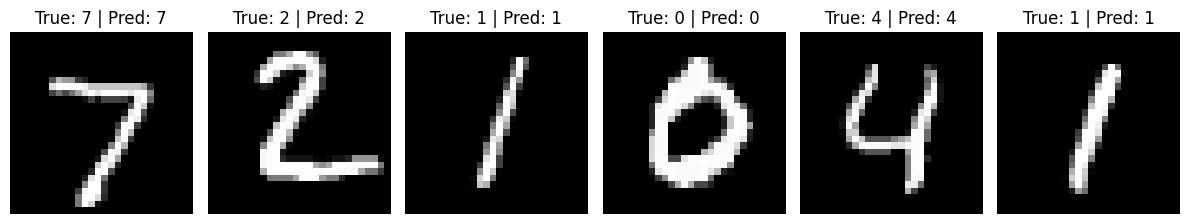

In [25]:
test(model_16, test_loader)

### **4 Layers**

Epoch [1/10]
Training Loss: 0.7199, Accuracy: 77.75%
Validation Loss: 0.2519, Accuracy: 92.39%
Epoch [2/10]
Training Loss: 0.1851, Accuracy: 94.49%
Validation Loss: 0.1483, Accuracy: 95.52%
Epoch [3/10]
Training Loss: 0.1228, Accuracy: 96.29%
Validation Loss: 0.1047, Accuracy: 96.71%
Epoch [4/10]
Training Loss: 0.0925, Accuracy: 97.14%
Validation Loss: 0.0768, Accuracy: 97.68%
Epoch [5/10]
Training Loss: 0.0726, Accuracy: 97.79%
Validation Loss: 0.0586, Accuracy: 98.32%
Epoch [6/10]
Training Loss: 0.0585, Accuracy: 98.14%
Validation Loss: 0.0479, Accuracy: 98.71%
Epoch [7/10]
Training Loss: 0.0485, Accuracy: 98.55%
Validation Loss: 0.0386, Accuracy: 98.97%
Epoch [8/10]
Training Loss: 0.0400, Accuracy: 98.71%
Validation Loss: 0.0312, Accuracy: 99.16%
Epoch [9/10]
Training Loss: 0.0341, Accuracy: 98.88%
Validation Loss: 0.0273, Accuracy: 99.32%
Epoch [10/10]
Training Loss: 0.0273, Accuracy: 99.14%
Validation Loss: 0.0212, Accuracy: 99.50%


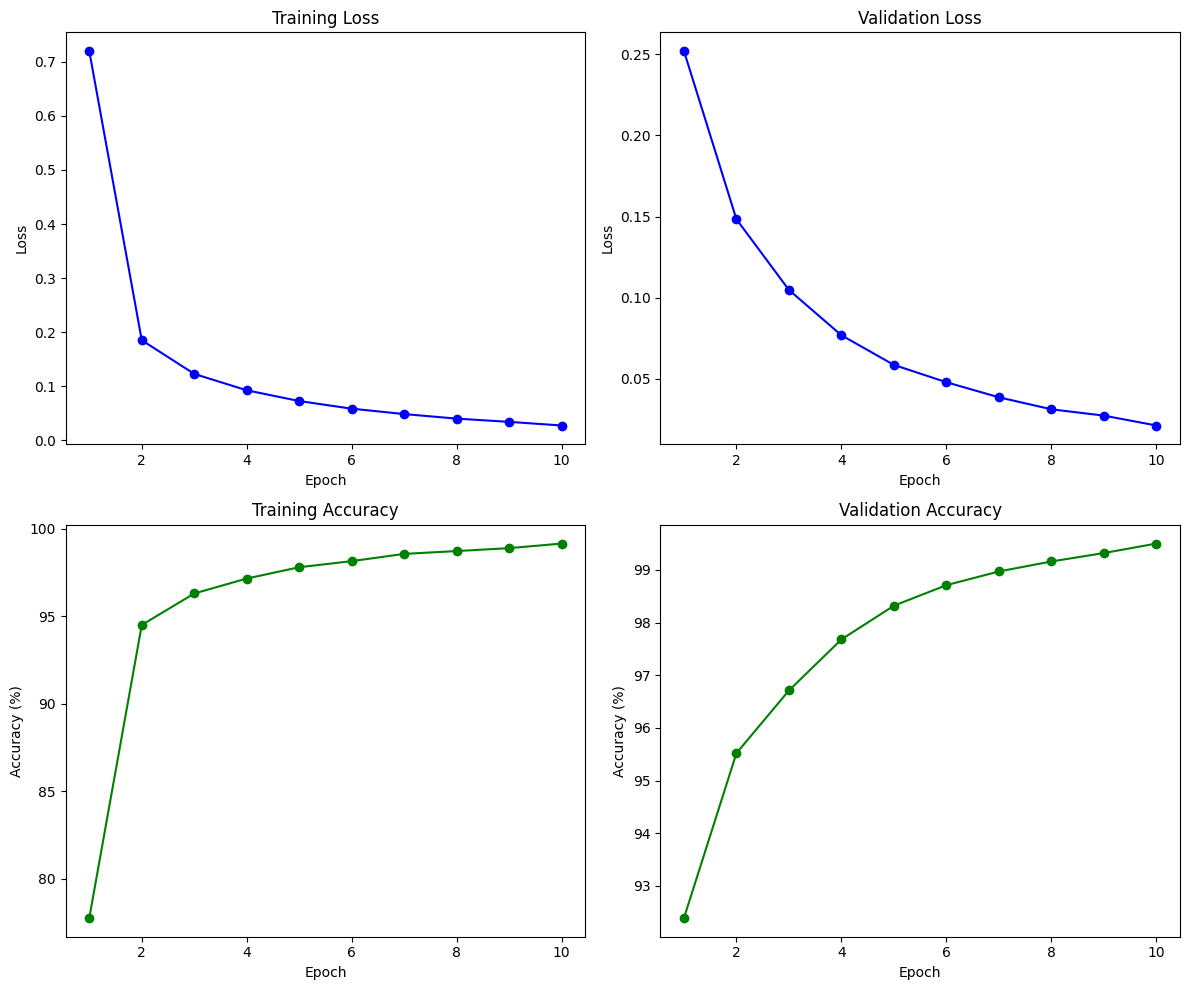

In [26]:
class FeedforwardNN_7(nn.Module):
    def __init__(self):
        super(FeedforwardNN_7, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.output(x)
        return x


model_17 = FeedforwardNN_7()
loss_fn_17 = nn.CrossEntropyLoss()
optimizer_17 = optim.SGD(model_17.parameters(), lr=0.1)

train(model_17, train_loader, val_loader, loss_fn_17, optimizer_17, 10)

Test Accuracy: 97.81%


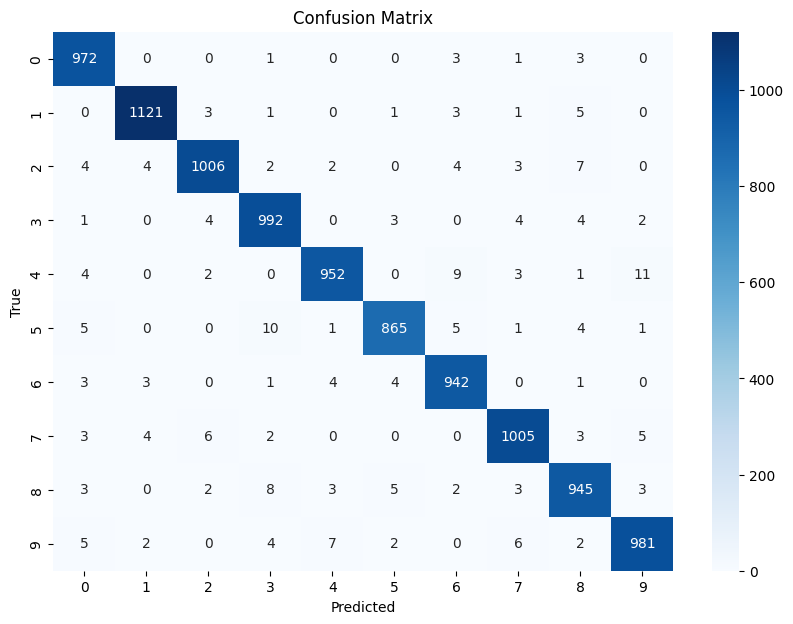

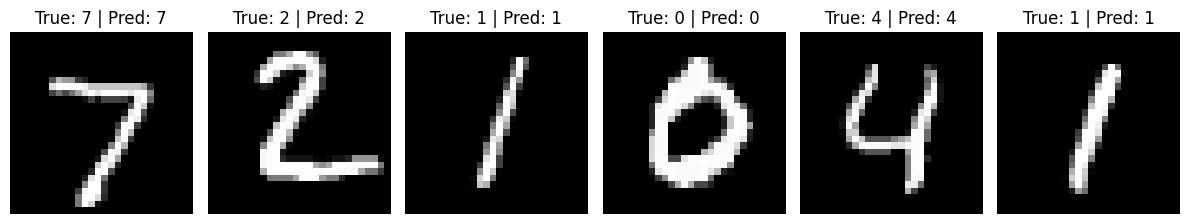

In [27]:
test(model_17, test_loader)

### **5 Layers**

Epoch [1/10]
Training Loss: 1.1677, Accuracy: 57.29%
Validation Loss: 0.3033, Accuracy: 90.89%
Epoch [2/10]
Training Loss: 0.2068, Accuracy: 93.97%
Validation Loss: 0.1501, Accuracy: 95.58%
Epoch [3/10]
Training Loss: 0.1325, Accuracy: 96.13%
Validation Loss: 0.0991, Accuracy: 97.20%
Epoch [4/10]
Training Loss: 0.0995, Accuracy: 97.00%
Validation Loss: 0.0755, Accuracy: 97.68%
Epoch [5/10]
Training Loss: 0.0797, Accuracy: 97.55%
Validation Loss: 0.0605, Accuracy: 98.23%
Epoch [6/10]
Training Loss: 0.0649, Accuracy: 98.01%
Validation Loss: 0.0484, Accuracy: 98.51%
Epoch [7/10]
Training Loss: 0.0535, Accuracy: 98.37%
Validation Loss: 0.0387, Accuracy: 98.79%
Epoch [8/10]
Training Loss: 0.0443, Accuracy: 98.55%
Validation Loss: 0.0362, Accuracy: 98.85%
Epoch [9/10]
Training Loss: 0.0405, Accuracy: 98.75%
Validation Loss: 0.0294, Accuracy: 99.12%
Epoch [10/10]
Training Loss: 0.0328, Accuracy: 98.99%
Validation Loss: 0.0249, Accuracy: 99.23%


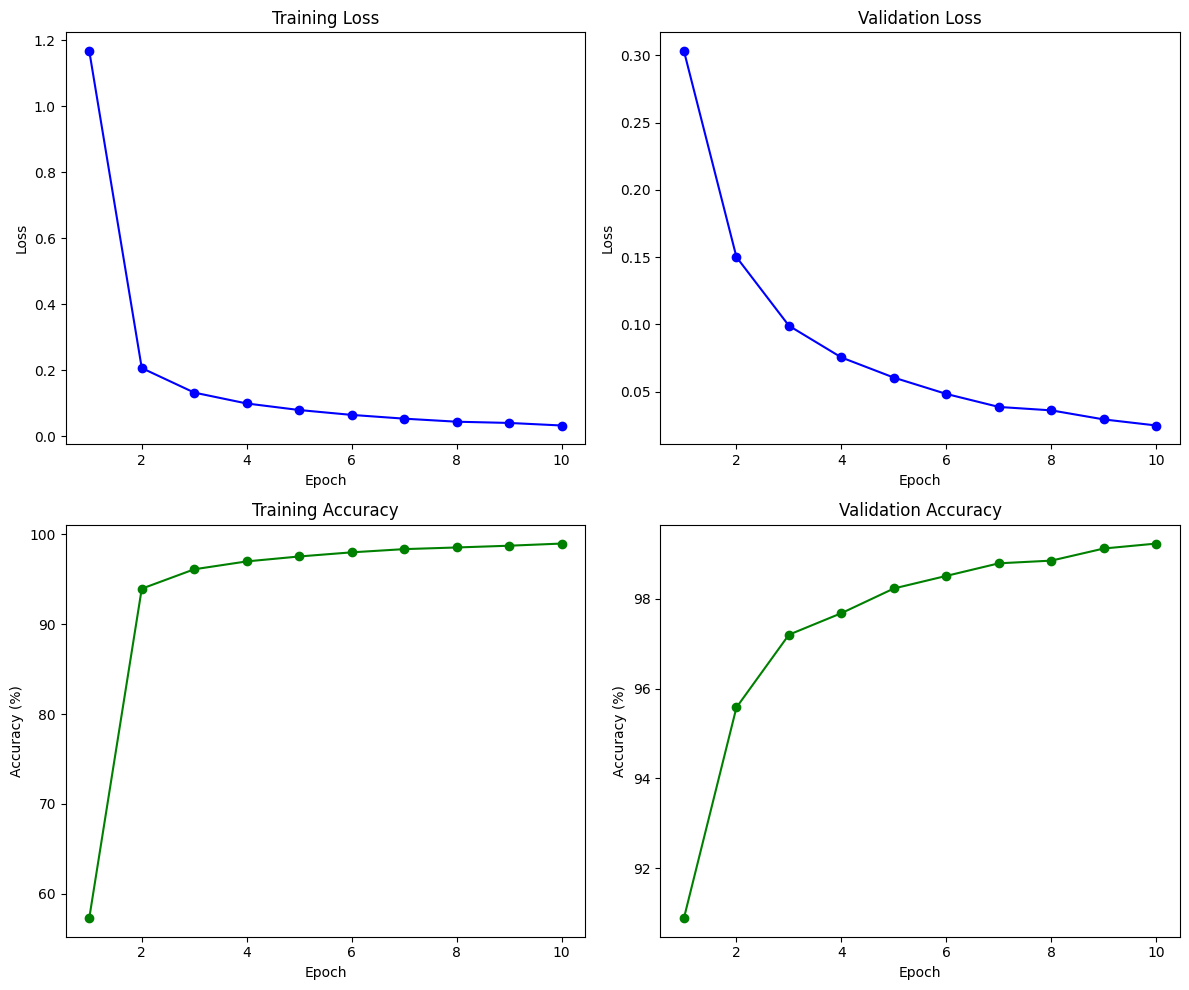

In [28]:
class FeedforwardNN_8(nn.Module):
    def __init__(self):
        super(FeedforwardNN_8, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 32)
        self.l4 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.activation_fn(self.l4(x))
        x = self.output(x)
        return x


model_18 = FeedforwardNN_8()
loss_fn_18 = nn.CrossEntropyLoss()
optimizer_18 = optim.SGD(model_18.parameters(), lr=0.1)

train(model_18, train_loader, val_loader, loss_fn_18, optimizer_18, 10)

Test Accuracy: 97.00%


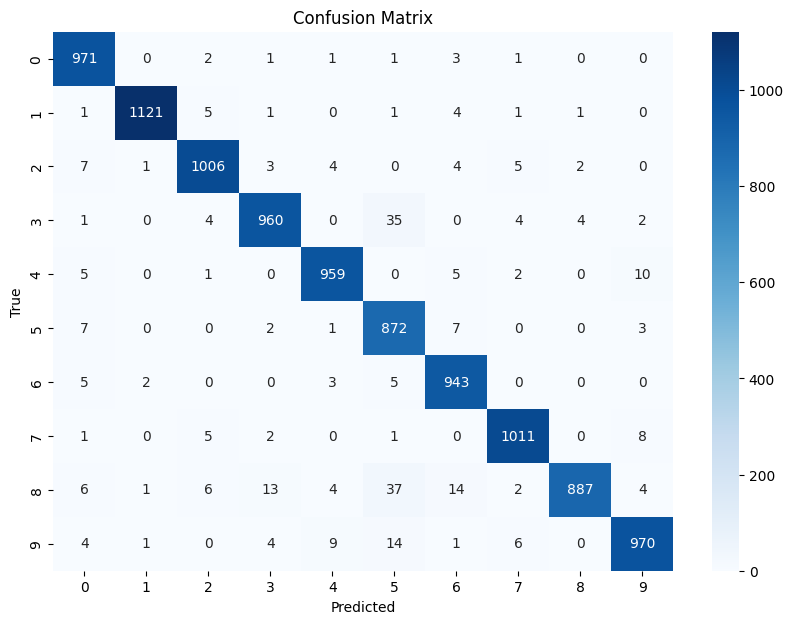

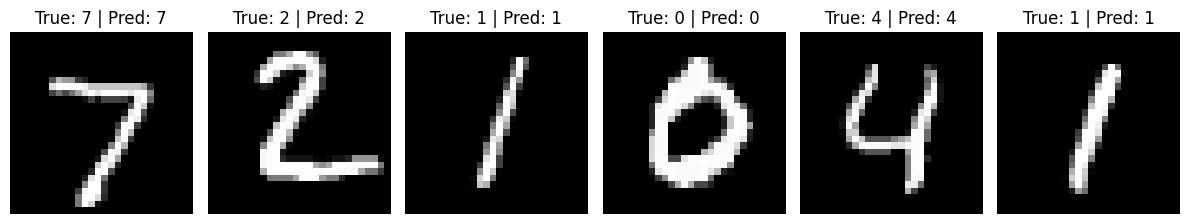

In [29]:
test(model_18, test_loader)

### Changing Number of Neurons - 3 layers
* At neurons - 64 and 32 --- Accuracy = **97.53%**
* At neurons - 512 and 256 --- Accuracy = **98.22%**
* At neurons - 128 and 128 --- Accuracy = **97.90%**
* At neurons - 256 and 128 --- Accuracy = **97.96%**

### Changing Number of Layers - 128 neurons
* At 2 layers --- Accuracy = **97.52%**
* At 3 layers --- Accuracy = **97.74%**
* At 4 layers --- Accuracy = **97.81%**
* At 5 layers --- Accuracy = **97.00%**

Then we choose at neurons - 512 and 256 which is model_12 as it gives the highest accuracy

# Test of best found model on the test set
* Learning Rate = 0.1
* Batch Size = 64
* At neurons - 512 and 256

Test Accuracy: 98.22%


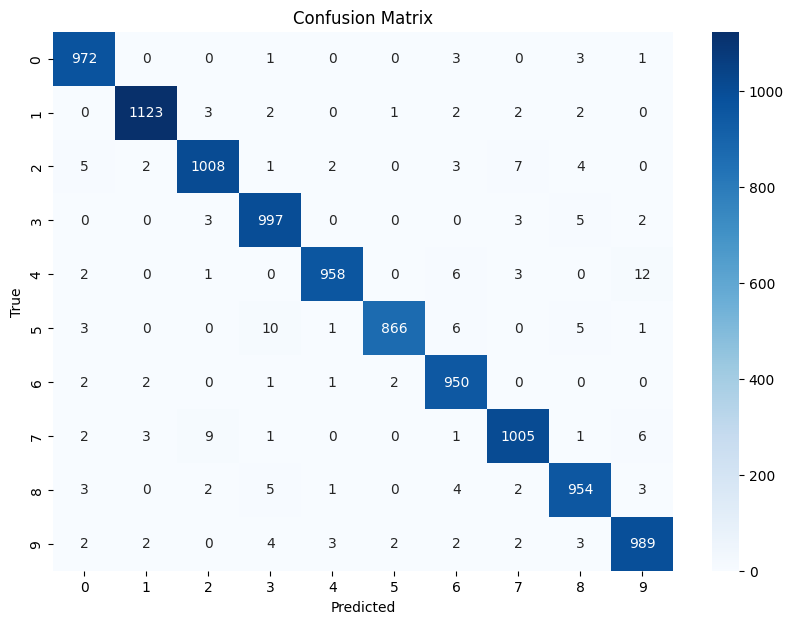

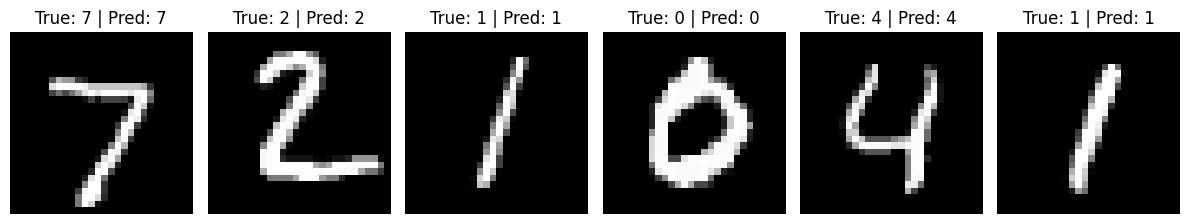

In [30]:
test(model_12, test_loader)

### **Preprocessing Data for CNN**

In [41]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).view(-1, 1, 28, 28)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### **Convolutional Network Design**
- **Input**: A 28x28 grayscale image.
- **Conv1**: 32 filters of size 3x3 with padding, followed by ReLU and Max Pooling.
- **Conv2**: 64 filters of size 3x3 with padding, followed by ReLU and Max Pooling.
- **Fully Connected Layers**: 128 neurons in the first fully connected layer, followed by 64 neurons in the second.
- **Output**: 10 neurons for classification.
- **Activation Functions**: ReLU in hidden layers and softmax in the output layer (via `CrossEntropyLoss`).

In [42]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers with Batch Normalization
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Convolutional layer 1
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after first convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Convolutional layer 2
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after second convolution

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After pooling, feature size is reduced to 7x7
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Output layer with 10 classes

        # Dropout Layers for Regularization
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability for fully connected layers

        # Activation Function
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        # Apply first convolution + BatchNorm + ReLU + MaxPool
        x = self.pool(self.activation_fn(self.bn1(self.conv1(x))))

        # Apply second convolution + BatchNorm + ReLU + MaxPool
        x = self.pool(self.activation_fn(self.bn2(self.conv2(x))))

        # Flatten the output for fully connected layers
        x = x.view(-1, 64 * 7 * 7)

        # Fully Connected Layers with Dropout and ReLU activation
        x = self.dropout(self.activation_fn(self.fc1(x)))  # First fully connected layer with dropout
        x = self.dropout(self.activation_fn(self.fc2(x)))  # Second fully connected layer with dropout
        x = self.fc3(x)  # Output layer

        return x


- Loss function: Cross-Entropy Loss
- Optimization technique: Stochastic Gradient Descent (SGD)
- Learning Rate: 0.01

In [43]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.01)

### **Training the CNN model**

In [44]:
def train_cnn(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    # Lists to track the losses and accuracies
    train_losses = []
    train_accuracies = []
    
    val_losses = []
    val_accuracies = []
    
    # Iterate over each epoch
    for epoch in range(epochs):

        # Training Loss and Accuracy
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        
        for inputs, labels in train_loader:
            
            
            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  

            
            loss = loss_fn(outputs, labels)
            loss.backward()  
            optimizer.step()  
            
            running_loss += loss.item()

            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        
        for inputs, labels in val_loader:
           
            optimizer.zero_grad()  
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()  
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

    
    plt.figure(figsize=(12, 10))

    # Plot Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epochs + 1), val_losses, marker='o', color='blue')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Training Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='green')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    # Plot Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    
    plt.tight_layout()
    plt.show()


Epoch [1/10]
Training Loss: 0.6081, Accuracy: 81.02%
Validation Loss: 0.1045, Accuracy: 97.01%
Epoch [2/10]
Training Loss: 0.1910, Accuracy: 94.81%
Validation Loss: 0.0716, Accuracy: 97.87%
Epoch [3/10]
Training Loss: 0.1389, Accuracy: 96.29%
Validation Loss: 0.0696, Accuracy: 97.89%
Epoch [4/10]
Training Loss: 0.1149, Accuracy: 97.00%
Validation Loss: 0.0531, Accuracy: 98.43%
Epoch [5/10]
Training Loss: 0.1011, Accuracy: 97.31%
Validation Loss: 0.0550, Accuracy: 98.28%
Epoch [6/10]
Training Loss: 0.0878, Accuracy: 97.73%
Validation Loss: 0.0495, Accuracy: 98.69%
Epoch [7/10]
Training Loss: 0.0816, Accuracy: 97.82%
Validation Loss: 0.0495, Accuracy: 98.65%
Epoch [8/10]
Training Loss: 0.0711, Accuracy: 98.04%
Validation Loss: 0.0422, Accuracy: 98.98%
Epoch [9/10]
Training Loss: 0.0715, Accuracy: 98.13%
Validation Loss: 0.0520, Accuracy: 98.63%
Epoch [10/10]
Training Loss: 0.0620, Accuracy: 98.32%
Validation Loss: 0.0419, Accuracy: 98.98%


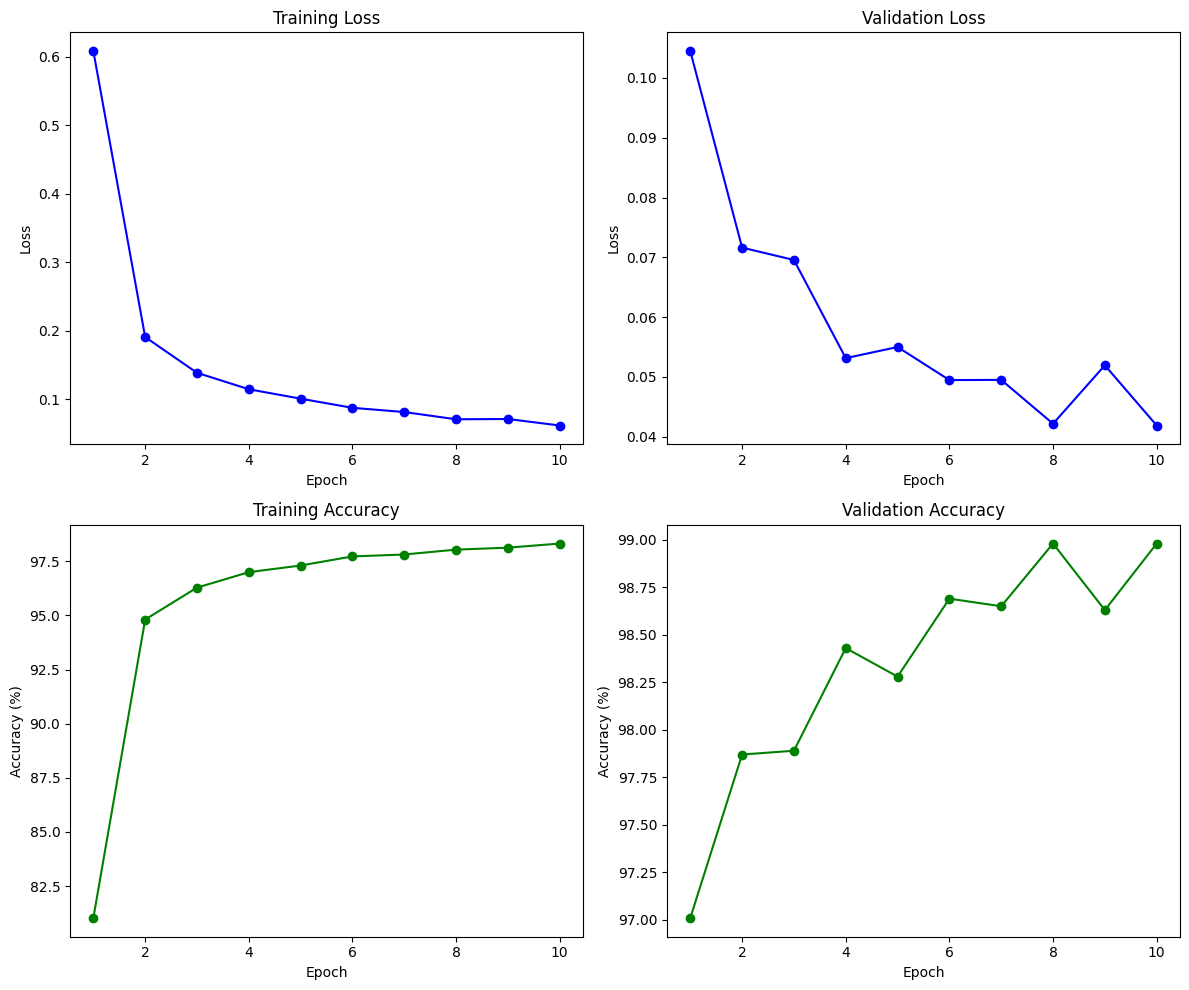

In [45]:
train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

### **Testing the CNN Model**

In [46]:
def test_cnn(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # Storing all predictions and true labels
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient tracking for inference
        for inputs, labels in test_loader:
            
            # Forward pass through the CNN model
            outputs = model(inputs)

            # Get predicted labels (max probability)
            _, predicted = torch.max(outputs, dim=1)

            # Update accuracy metrics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    ################################

    # Visualize multiple sample predictions
    sample_indices = [0, 1, 2, 3, 4, 5]  # Sample indices for visualization

    num_samples = len(sample_indices)
    plt.figure(figsize=(12, 3 * num_samples))

    for i, index in enumerate(sample_indices):
        sample_image = X_test[index]  # Assuming X_test is the test set images
        true_label = y_test[index]  # Assuming y_test is the true labels of the test set

        # Prepare the sample image for the CNN (reshape to [1, 1, 28, 28] for grayscale image)
        sample_image = torch.tensor(sample_image).float().view(1, 1, 28, 28)

        with torch.no_grad():
            output = model(sample_image)  # Get the output from the model
            _, predicted_label = torch.max(output, 1)  # Get predicted label

        # Plot the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(sample_image.squeeze(), cmap='gray')  # Remove extra dimensions and display
        plt.title(f"True: {true_label} | Pred: {predicted_label.item()}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Test Accuracy: 99.10%


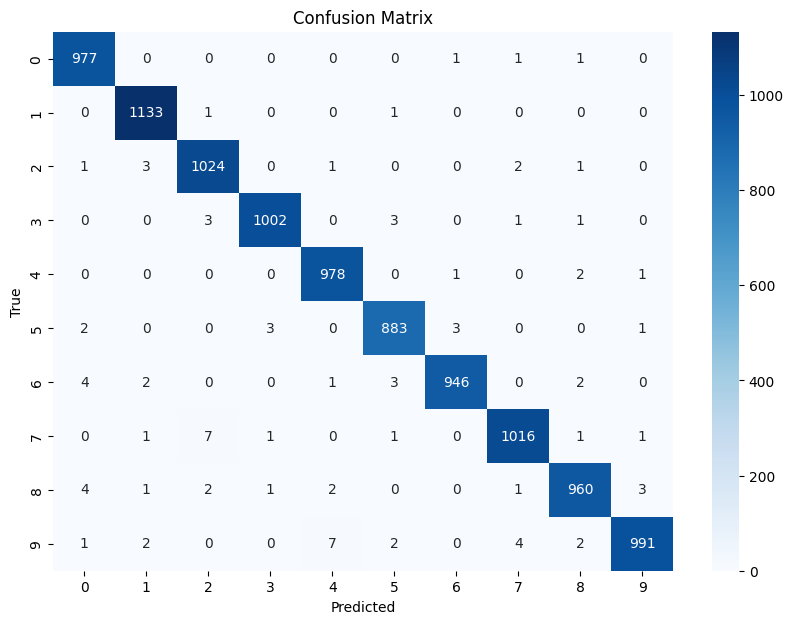

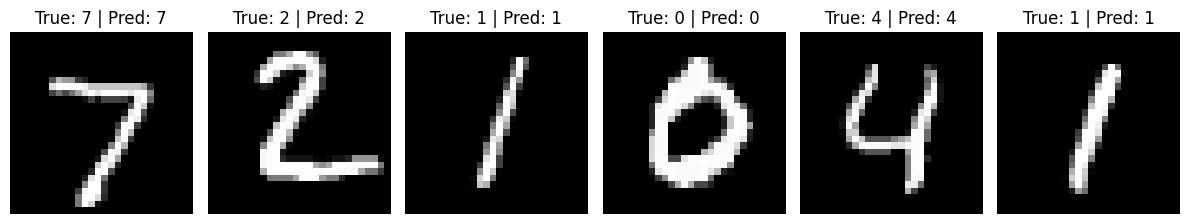

In [47]:
test_cnn(modelCNN, test_loader)

### **Analysis**
# Change Learning Rate [ 0.1,0.05, 0.001, 0.0001]
* Learning Rate=0.1
* Batch size = 32


Epoch [1/10]
Training Loss: 0.4654, Accuracy: 85.63%
Validation Loss: 0.0989, Accuracy: 97.31%
Epoch [2/10]
Training Loss: 0.1873, Accuracy: 94.84%
Validation Loss: 0.0774, Accuracy: 98.08%
Epoch [3/10]
Training Loss: 0.1320, Accuracy: 96.52%
Validation Loss: 0.0618, Accuracy: 98.35%
Epoch [4/10]
Training Loss: 0.1067, Accuracy: 97.22%
Validation Loss: 0.0677, Accuracy: 98.32%
Epoch [5/10]
Training Loss: 0.0943, Accuracy: 97.52%
Validation Loss: 0.0527, Accuracy: 98.78%
Epoch [6/10]
Training Loss: 0.0787, Accuracy: 97.87%
Validation Loss: 0.0468, Accuracy: 98.80%
Epoch [7/10]
Training Loss: 0.0725, Accuracy: 98.13%
Validation Loss: 0.0520, Accuracy: 98.85%
Epoch [8/10]
Training Loss: 0.0617, Accuracy: 98.39%
Validation Loss: 0.0513, Accuracy: 98.82%
Epoch [9/10]
Training Loss: 0.0525, Accuracy: 98.61%
Validation Loss: 0.0492, Accuracy: 98.96%
Epoch [10/10]
Training Loss: 0.0521, Accuracy: 98.60%
Validation Loss: 0.0458, Accuracy: 98.97%


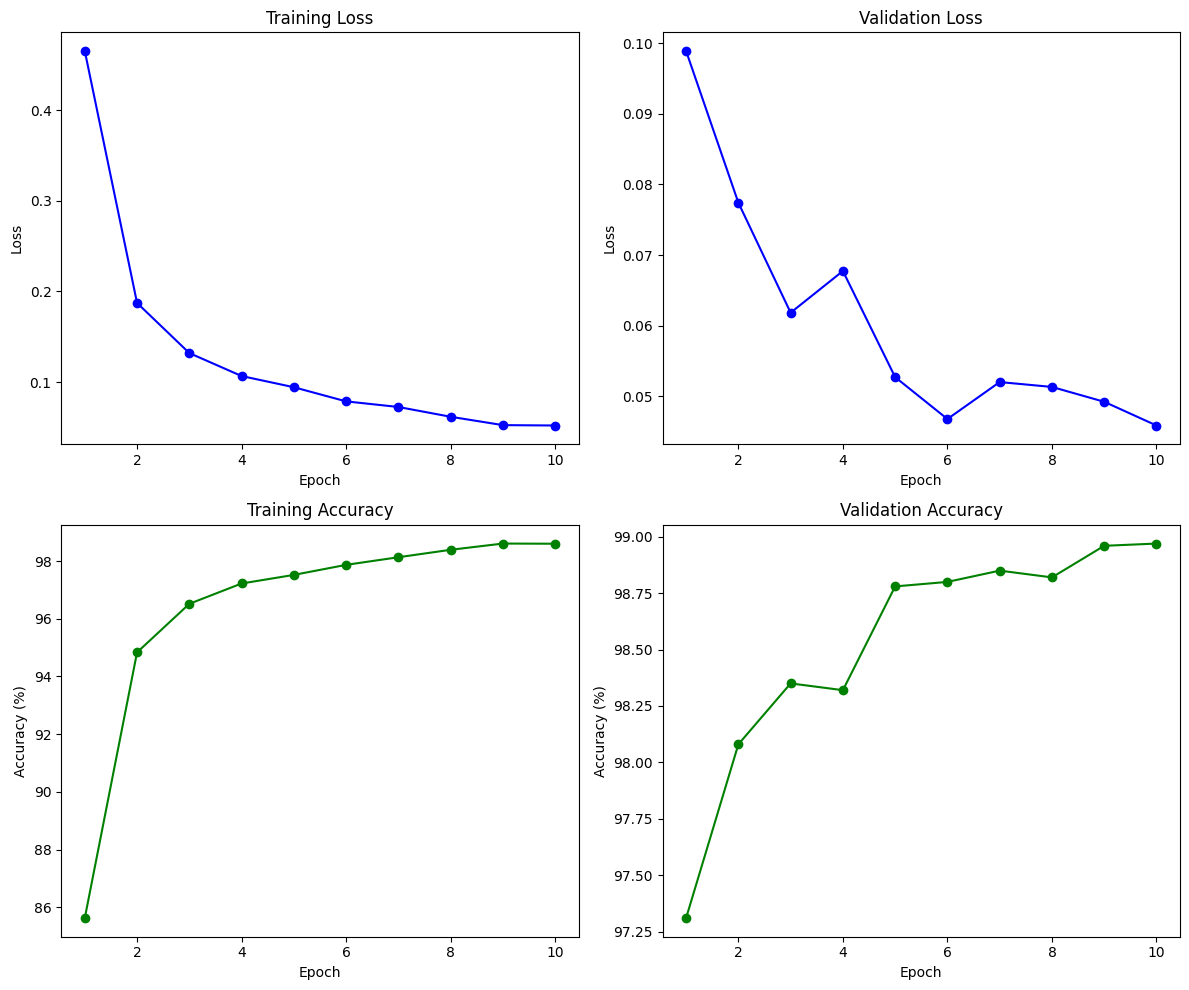

In [48]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.1)

train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

Test Accuracy: 99.28%


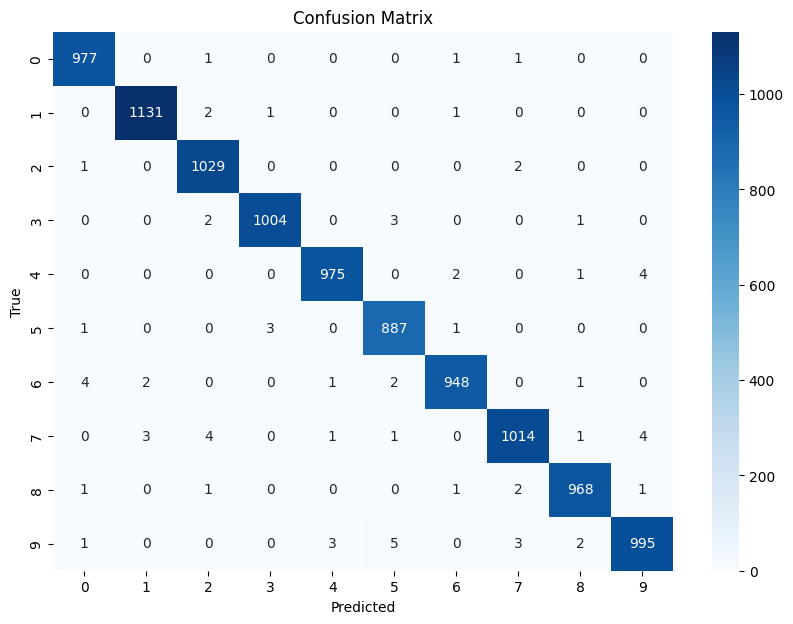

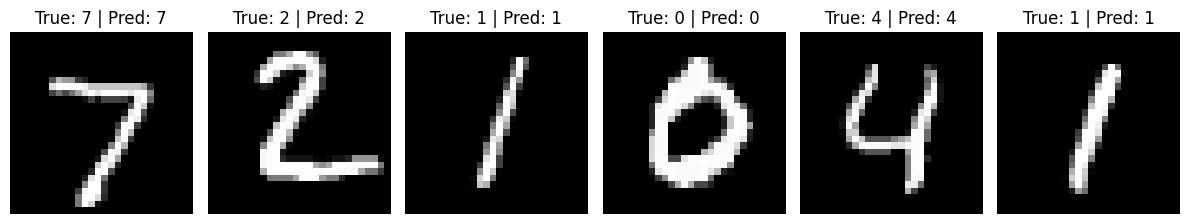

In [49]:
test_cnn(modelCNN, test_loader)

* Learning Rate=0.05
* Batch size = 32

Epoch [1/10]
Training Loss: 0.4077, Accuracy: 87.31%
Validation Loss: 0.0986, Accuracy: 97.19%
Epoch [2/10]
Training Loss: 0.1603, Accuracy: 95.64%
Validation Loss: 0.0678, Accuracy: 98.19%
Epoch [3/10]
Training Loss: 0.1273, Accuracy: 96.68%
Validation Loss: 0.0699, Accuracy: 98.29%
Epoch [4/10]
Training Loss: 0.1027, Accuracy: 97.30%
Validation Loss: 0.0571, Accuracy: 98.62%
Epoch [5/10]
Training Loss: 0.0886, Accuracy: 97.69%
Validation Loss: 0.0504, Accuracy: 98.76%
Epoch [6/10]
Training Loss: 0.0767, Accuracy: 97.94%
Validation Loss: 0.0615, Accuracy: 98.70%
Epoch [7/10]
Training Loss: 0.0686, Accuracy: 98.26%
Validation Loss: 0.0457, Accuracy: 98.84%
Epoch [8/10]
Training Loss: 0.0635, Accuracy: 98.30%
Validation Loss: 0.0501, Accuracy: 98.80%
Epoch [9/10]
Training Loss: 0.0558, Accuracy: 98.54%
Validation Loss: 0.0480, Accuracy: 98.94%
Epoch [10/10]
Training Loss: 0.0521, Accuracy: 98.63%
Validation Loss: 0.0548, Accuracy: 98.74%


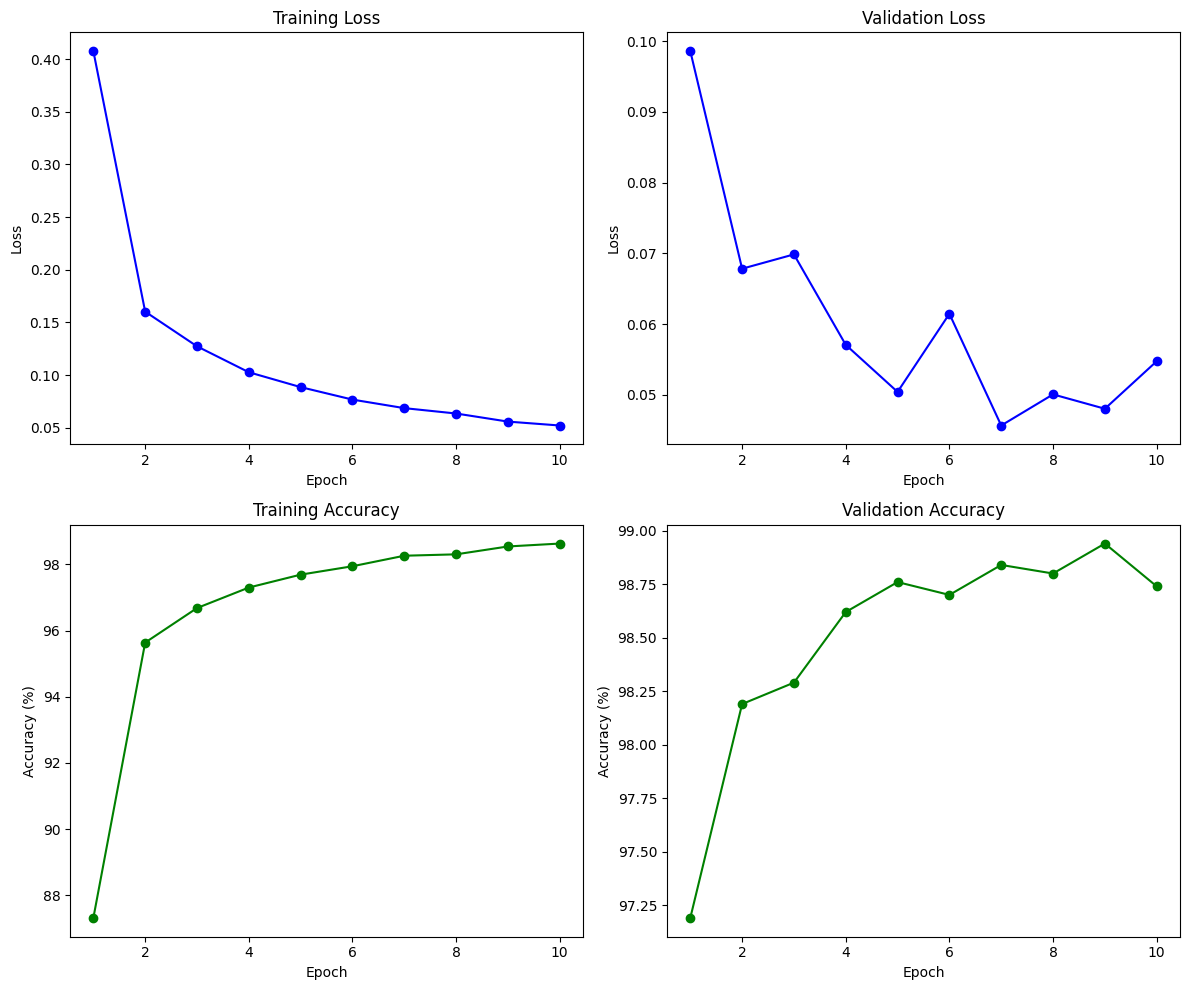

In [51]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.05)

train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

Test Accuracy: 99.17%


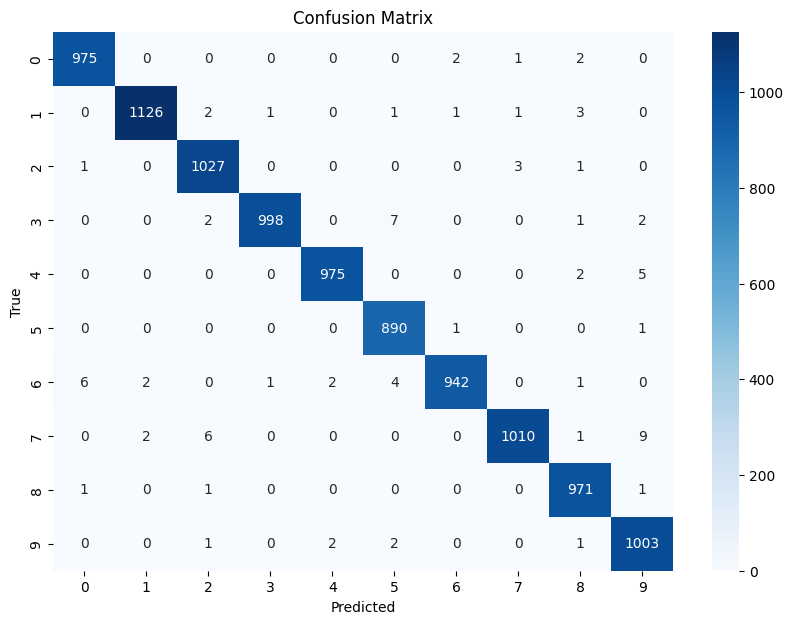

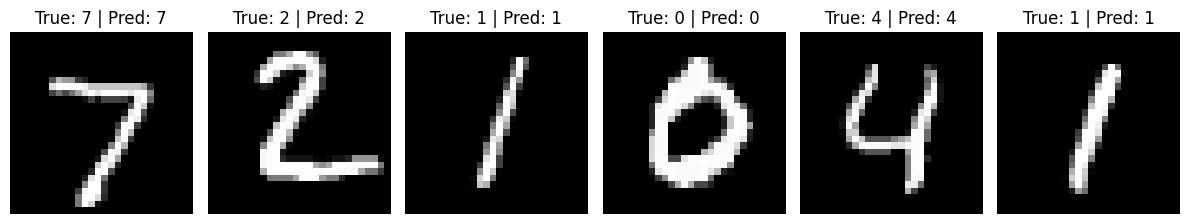

In [52]:
test_cnn(modelCNN, test_loader)

* Learning Rate=0.001
* Batch size = 32

Epoch [1/10]
Training Loss: 1.7784, Accuracy: 40.92%
Validation Loss: 0.8719, Accuracy: 85.91%
Epoch [2/10]
Training Loss: 0.9130, Accuracy: 71.62%
Validation Loss: 0.3723, Accuracy: 92.64%
Epoch [3/10]
Training Loss: 0.5919, Accuracy: 82.21%
Validation Loss: 0.2318, Accuracy: 94.33%
Epoch [4/10]
Training Loss: 0.4502, Accuracy: 87.07%
Validation Loss: 0.1771, Accuracy: 95.37%
Epoch [5/10]
Training Loss: 0.3678, Accuracy: 89.78%
Validation Loss: 0.1461, Accuracy: 95.98%
Epoch [6/10]
Training Loss: 0.3160, Accuracy: 91.17%
Validation Loss: 0.1266, Accuracy: 96.43%
Epoch [7/10]
Training Loss: 0.2805, Accuracy: 92.48%
Validation Loss: 0.1134, Accuracy: 96.63%
Epoch [8/10]
Training Loss: 0.2536, Accuracy: 93.12%
Validation Loss: 0.1015, Accuracy: 97.01%
Epoch [9/10]
Training Loss: 0.2333, Accuracy: 93.71%
Validation Loss: 0.0945, Accuracy: 97.14%
Epoch [10/10]
Training Loss: 0.2123, Accuracy: 94.23%
Validation Loss: 0.0894, Accuracy: 97.29%


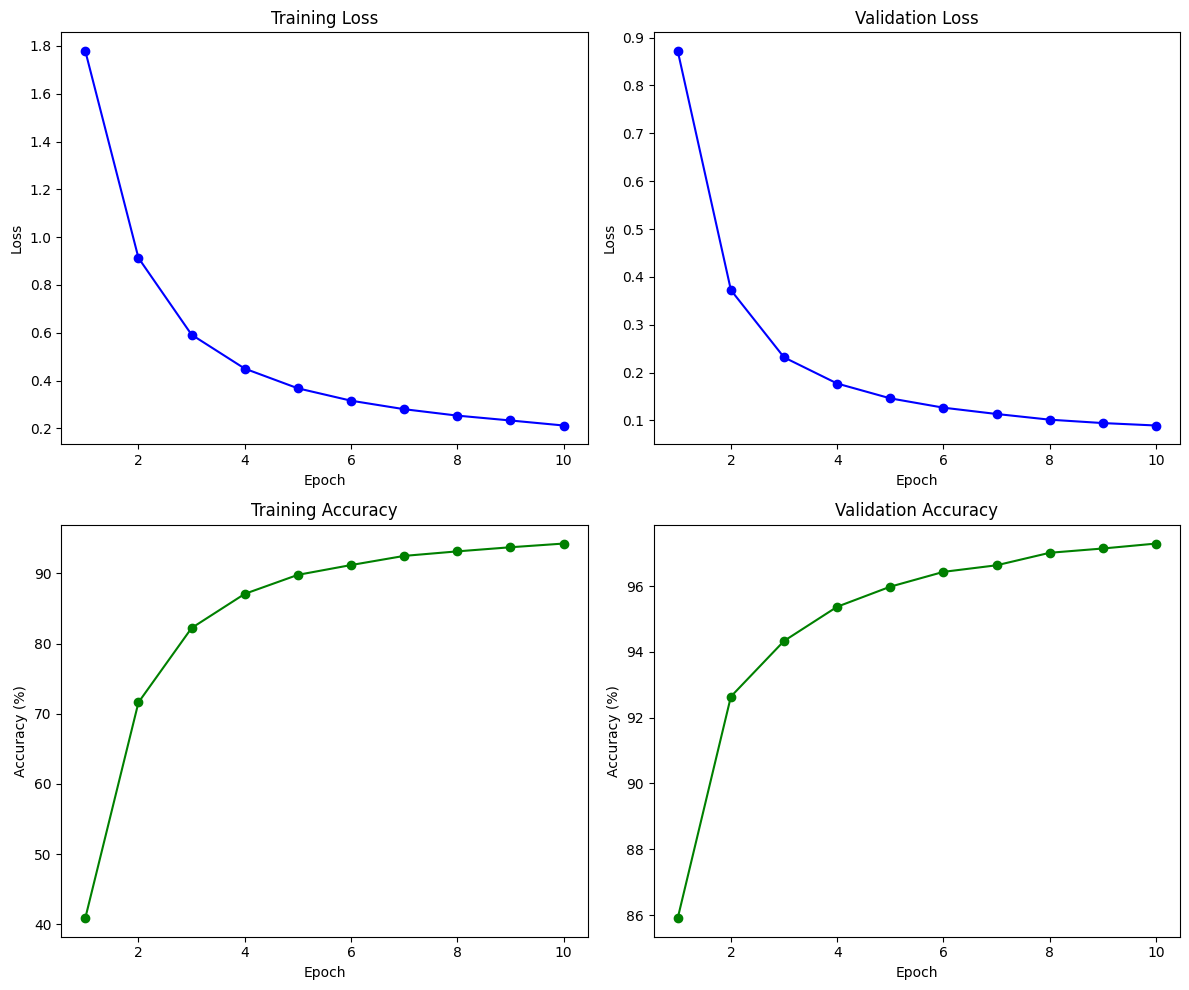

In [53]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.001)

train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

Test Accuracy: 97.75%


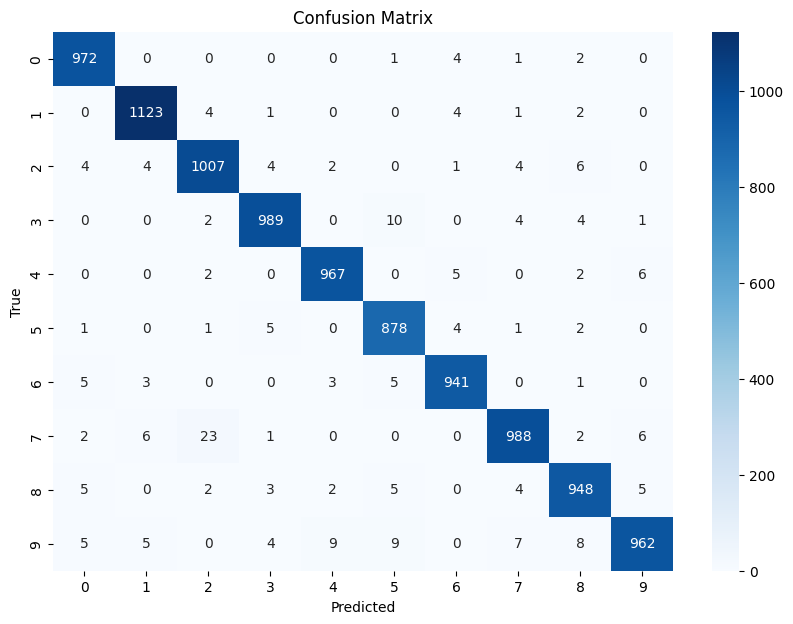

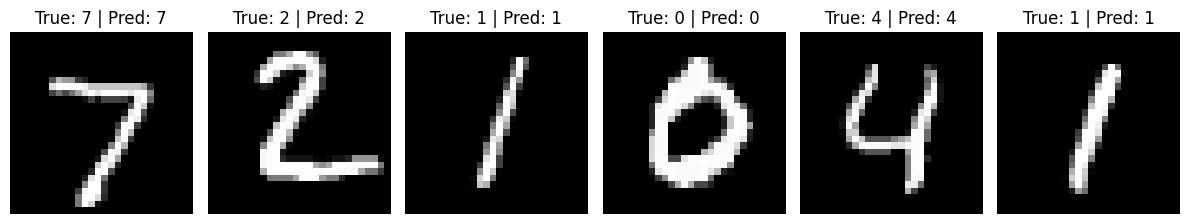

In [54]:
test_cnn(modelCNN, test_loader)

* Learning Rate=0.0001
* Batch size = 32

Epoch [1/10]
Training Loss: 2.2685, Accuracy: 14.54%
Validation Loss: 2.1885, Accuracy: 28.95%
Epoch [2/10]
Training Loss: 2.1767, Accuracy: 23.11%
Validation Loss: 2.0764, Accuracy: 51.57%
Epoch [3/10]
Training Loss: 2.0775, Accuracy: 31.27%
Validation Loss: 1.9378, Accuracy: 62.63%
Epoch [4/10]
Training Loss: 1.9620, Accuracy: 37.43%
Validation Loss: 1.7817, Accuracy: 68.78%
Epoch [5/10]
Training Loss: 1.8337, Accuracy: 43.32%
Validation Loss: 1.6004, Accuracy: 72.21%
Epoch [6/10]
Training Loss: 1.7000, Accuracy: 47.94%
Validation Loss: 1.4260, Accuracy: 75.47%
Epoch [7/10]
Training Loss: 1.5673, Accuracy: 52.20%
Validation Loss: 1.2575, Accuracy: 77.93%
Epoch [8/10]
Training Loss: 1.4518, Accuracy: 55.38%
Validation Loss: 1.1127, Accuracy: 80.33%
Epoch [9/10]
Training Loss: 1.3436, Accuracy: 58.64%
Validation Loss: 0.9891, Accuracy: 82.33%
Epoch [10/10]
Training Loss: 1.2500, Accuracy: 61.35%
Validation Loss: 0.8852, Accuracy: 84.51%


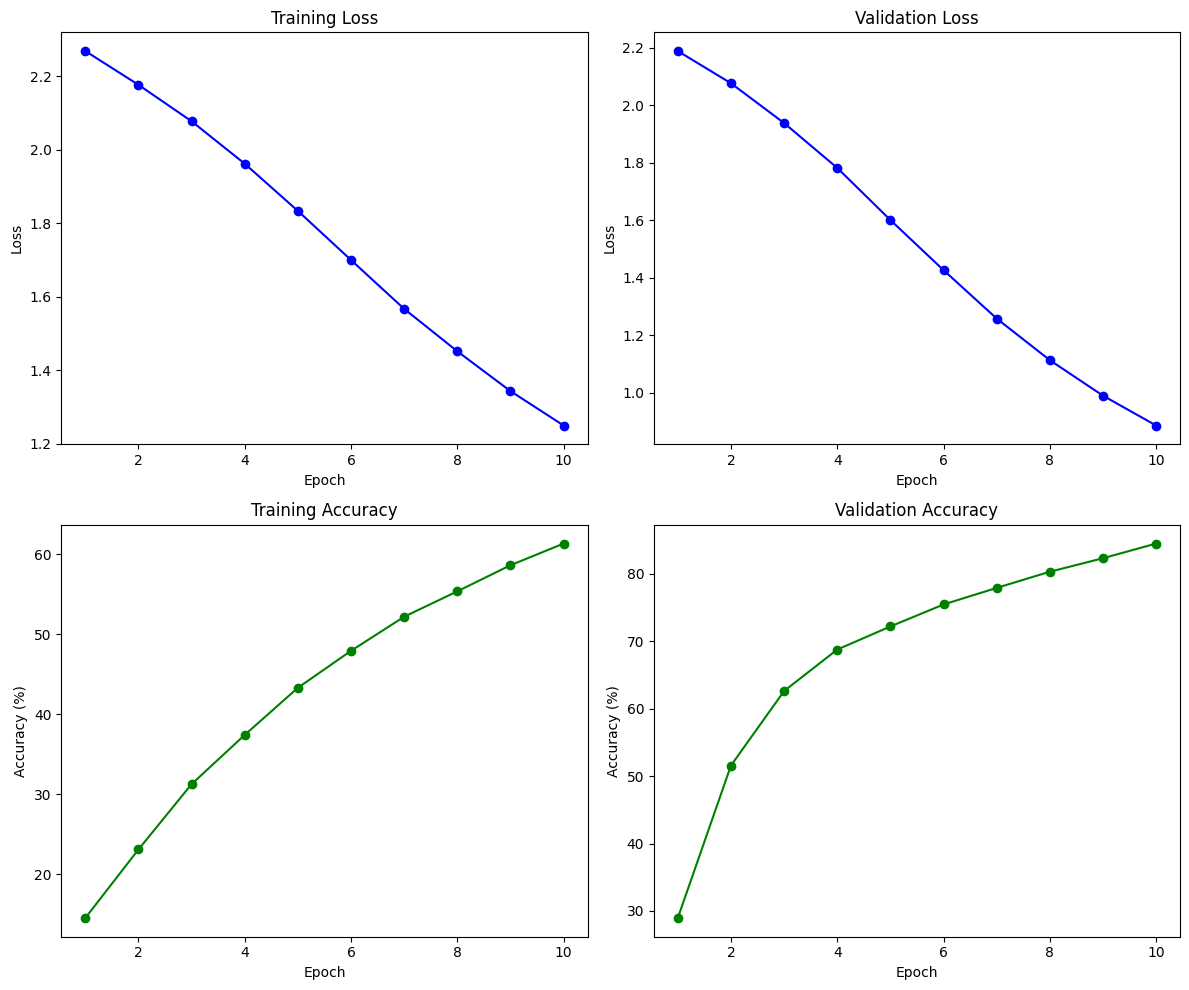

In [55]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.0001)

train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

Test Accuracy: 85.51%


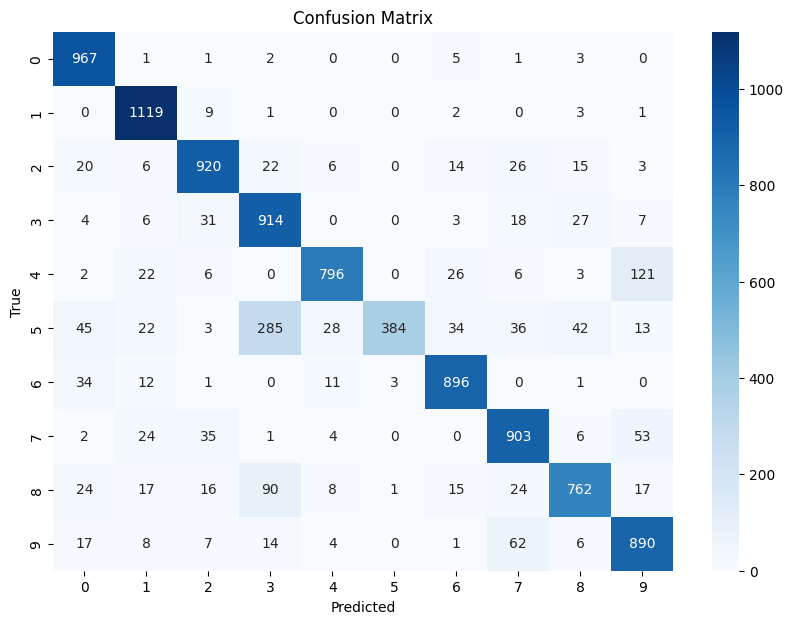

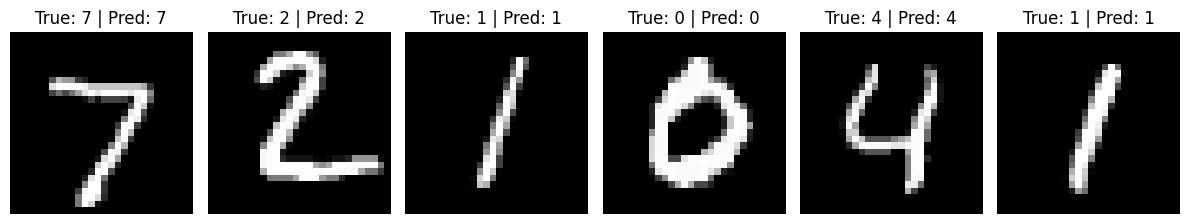

In [56]:
test_cnn(modelCNN, test_loader)

## **Trying Different Batch Sizes [64,128,256,512]**


Testing with Batch Size: 64
Epoch [1/10]
Training Loss: 0.8442, Accuracy: 73.24%
Validation Loss: 0.1557, Accuracy: 95.53%
Epoch [2/10]
Training Loss: 0.2727, Accuracy: 92.41%
Validation Loss: 0.1005, Accuracy: 97.04%
Epoch [3/10]
Training Loss: 0.1898, Accuracy: 94.91%
Validation Loss: 0.0829, Accuracy: 97.47%
Epoch [4/10]
Training Loss: 0.1538, Accuracy: 95.81%
Validation Loss: 0.0665, Accuracy: 98.16%
Epoch [5/10]
Training Loss: 0.1317, Accuracy: 96.45%
Validation Loss: 0.0596, Accuracy: 98.30%
Epoch [6/10]
Training Loss: 0.1135, Accuracy: 97.04%
Validation Loss: 0.0576, Accuracy: 98.33%
Epoch [7/10]
Training Loss: 0.1047, Accuracy: 97.20%
Validation Loss: 0.0668, Accuracy: 97.96%
Epoch [8/10]
Training Loss: 0.0938, Accuracy: 97.55%
Validation Loss: 0.0614, Accuracy: 98.27%
Epoch [9/10]
Training Loss: 0.0903, Accuracy: 97.66%
Validation Loss: 0.0491, Accuracy: 98.69%
Epoch [10/10]
Training Loss: 0.0787, Accuracy: 97.92%
Validation Loss: 0.0489, Accuracy: 98.70%


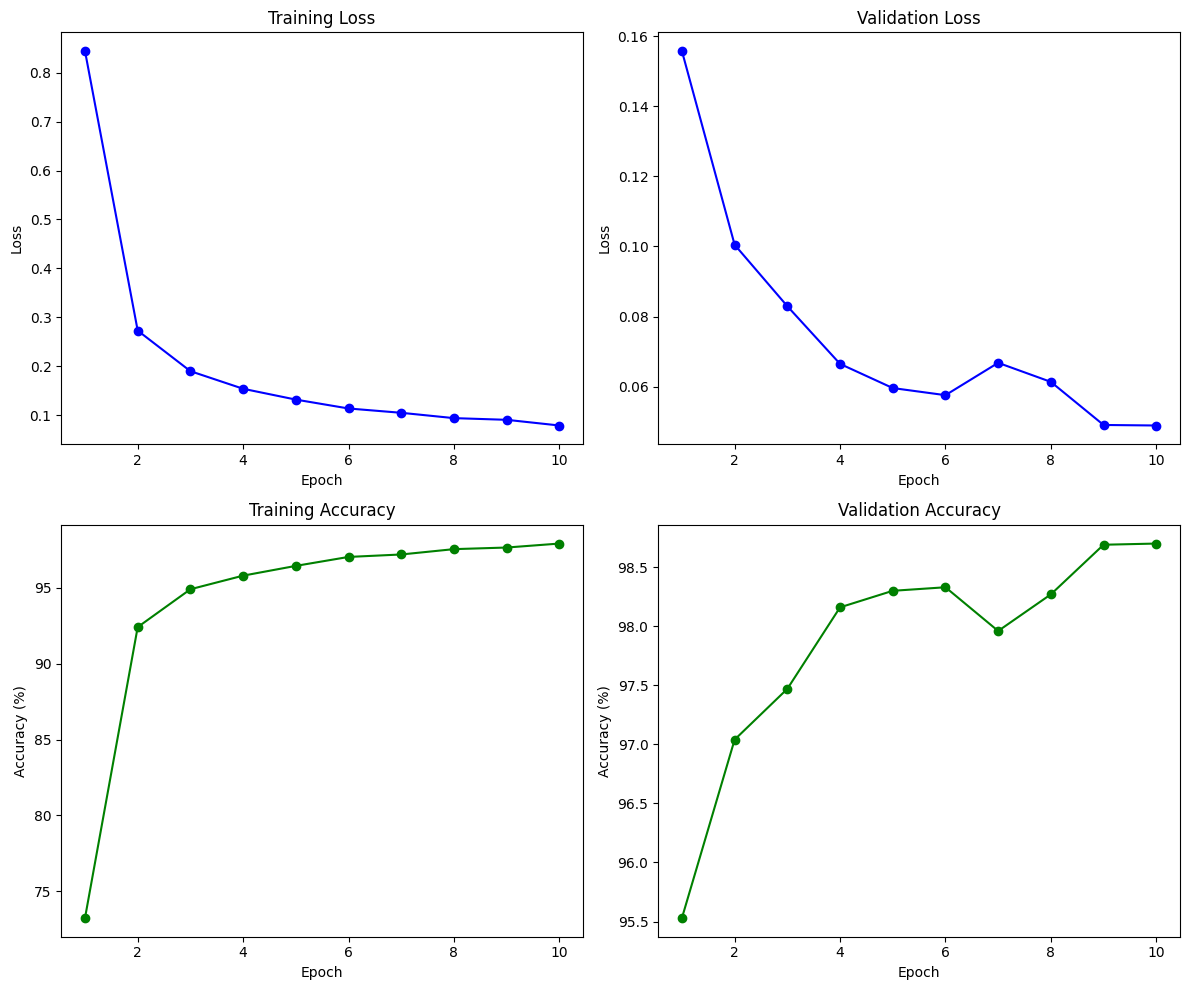

Test Accuracy: 98.88%


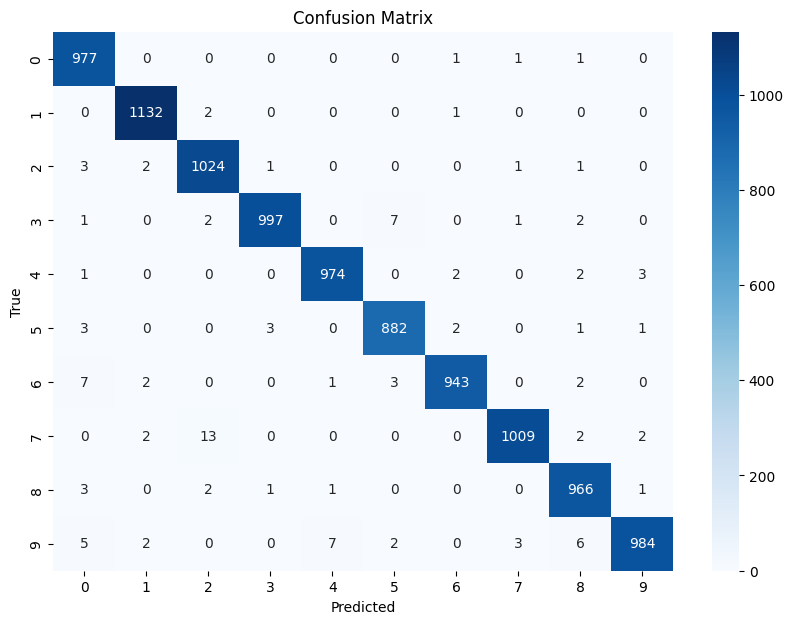

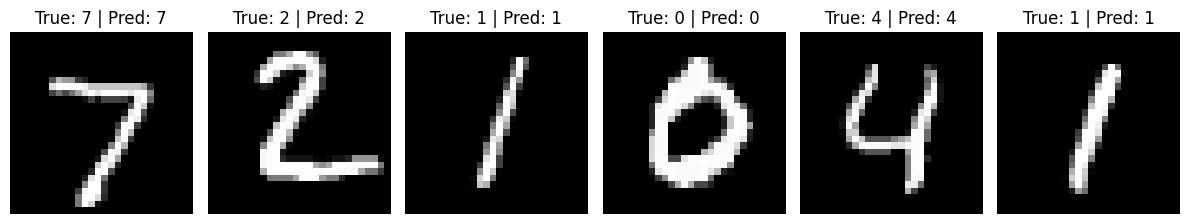


Testing with Batch Size: 128
Epoch [1/10]
Training Loss: 1.2472, Accuracy: 59.39%
Validation Loss: 0.3037, Accuracy: 93.34%
Epoch [2/10]
Training Loss: 0.4599, Accuracy: 86.34%
Validation Loss: 0.1472, Accuracy: 95.94%
Epoch [3/10]
Training Loss: 0.3099, Accuracy: 91.29%
Validation Loss: 0.1107, Accuracy: 96.77%
Epoch [4/10]
Training Loss: 0.2391, Accuracy: 93.40%
Validation Loss: 0.0898, Accuracy: 97.41%
Epoch [5/10]
Training Loss: 0.1986, Accuracy: 94.54%
Validation Loss: 0.0759, Accuracy: 97.79%
Epoch [6/10]
Training Loss: 0.1709, Accuracy: 95.39%
Validation Loss: 0.0735, Accuracy: 97.87%
Epoch [7/10]
Training Loss: 0.1509, Accuracy: 95.94%
Validation Loss: 0.0640, Accuracy: 98.13%
Epoch [8/10]
Training Loss: 0.1367, Accuracy: 96.39%
Validation Loss: 0.0583, Accuracy: 98.28%
Epoch [9/10]
Training Loss: 0.1289, Accuracy: 96.65%
Validation Loss: 0.0571, Accuracy: 98.39%
Epoch [10/10]
Training Loss: 0.1184, Accuracy: 96.90%
Validation Loss: 0.0552, Accuracy: 98.43%


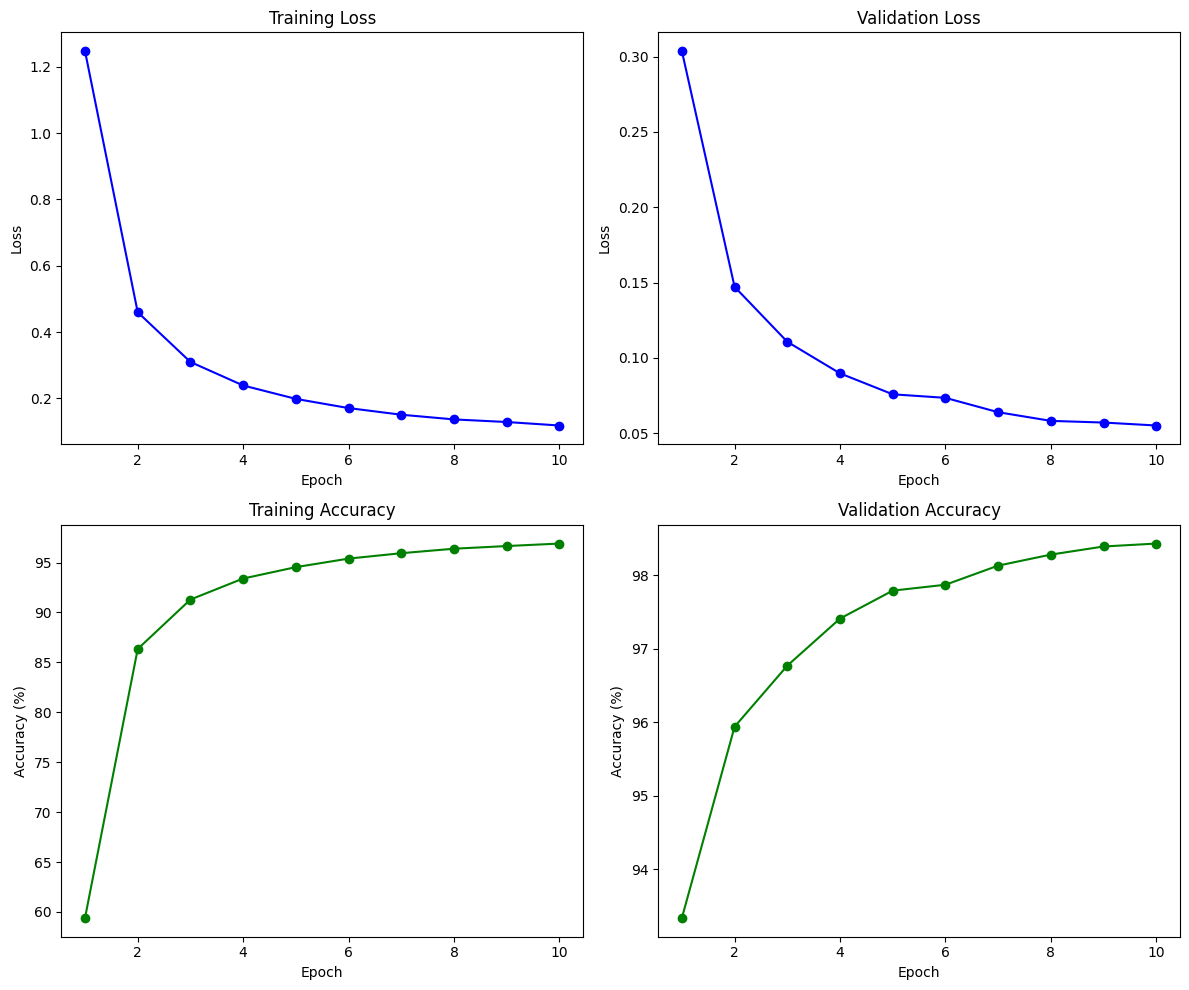

Test Accuracy: 98.59%


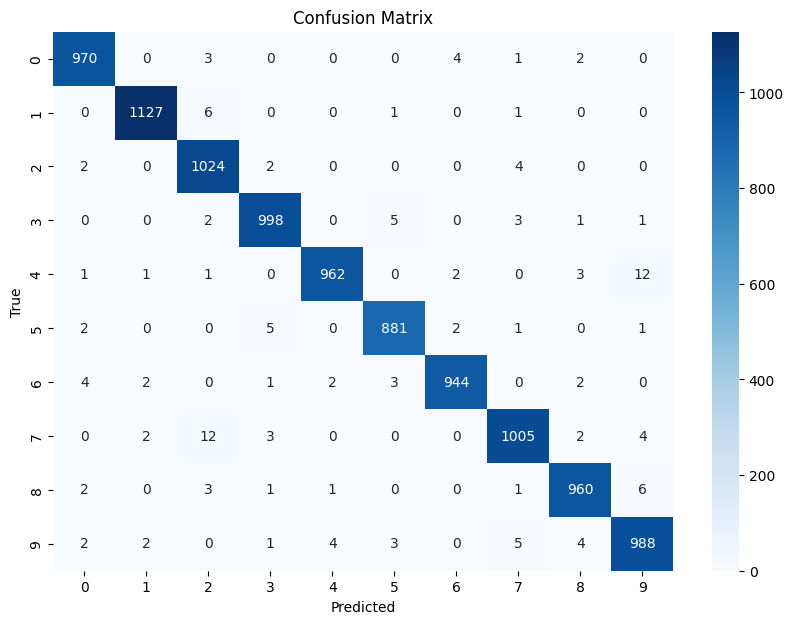

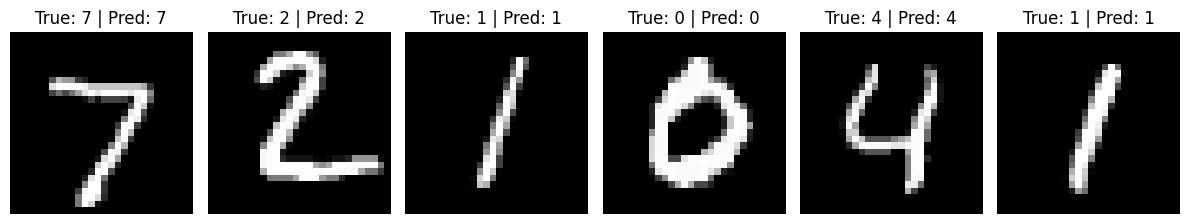


Testing with Batch Size: 256
Epoch [1/10]
Training Loss: 1.7093, Accuracy: 43.47%
Validation Loss: 0.7557, Accuracy: 87.22%
Epoch [2/10]
Training Loss: 0.8113, Accuracy: 74.65%
Validation Loss: 0.3146, Accuracy: 92.77%
Epoch [3/10]
Training Loss: 0.5205, Accuracy: 84.37%
Validation Loss: 0.1921, Accuracy: 94.92%
Epoch [4/10]
Training Loss: 0.3898, Accuracy: 88.65%
Validation Loss: 0.1434, Accuracy: 95.95%
Epoch [5/10]
Training Loss: 0.3140, Accuracy: 91.11%
Validation Loss: 0.1175, Accuracy: 96.59%
Epoch [6/10]
Training Loss: 0.2702, Accuracy: 92.61%
Validation Loss: 0.1038, Accuracy: 96.97%
Epoch [7/10]
Training Loss: 0.2386, Accuracy: 93.35%
Validation Loss: 0.0918, Accuracy: 97.34%
Epoch [8/10]
Training Loss: 0.2141, Accuracy: 94.05%
Validation Loss: 0.0843, Accuracy: 97.40%
Epoch [9/10]
Training Loss: 0.1940, Accuracy: 94.69%
Validation Loss: 0.0807, Accuracy: 97.58%
Epoch [10/10]
Training Loss: 0.1801, Accuracy: 95.15%
Validation Loss: 0.0708, Accuracy: 97.95%


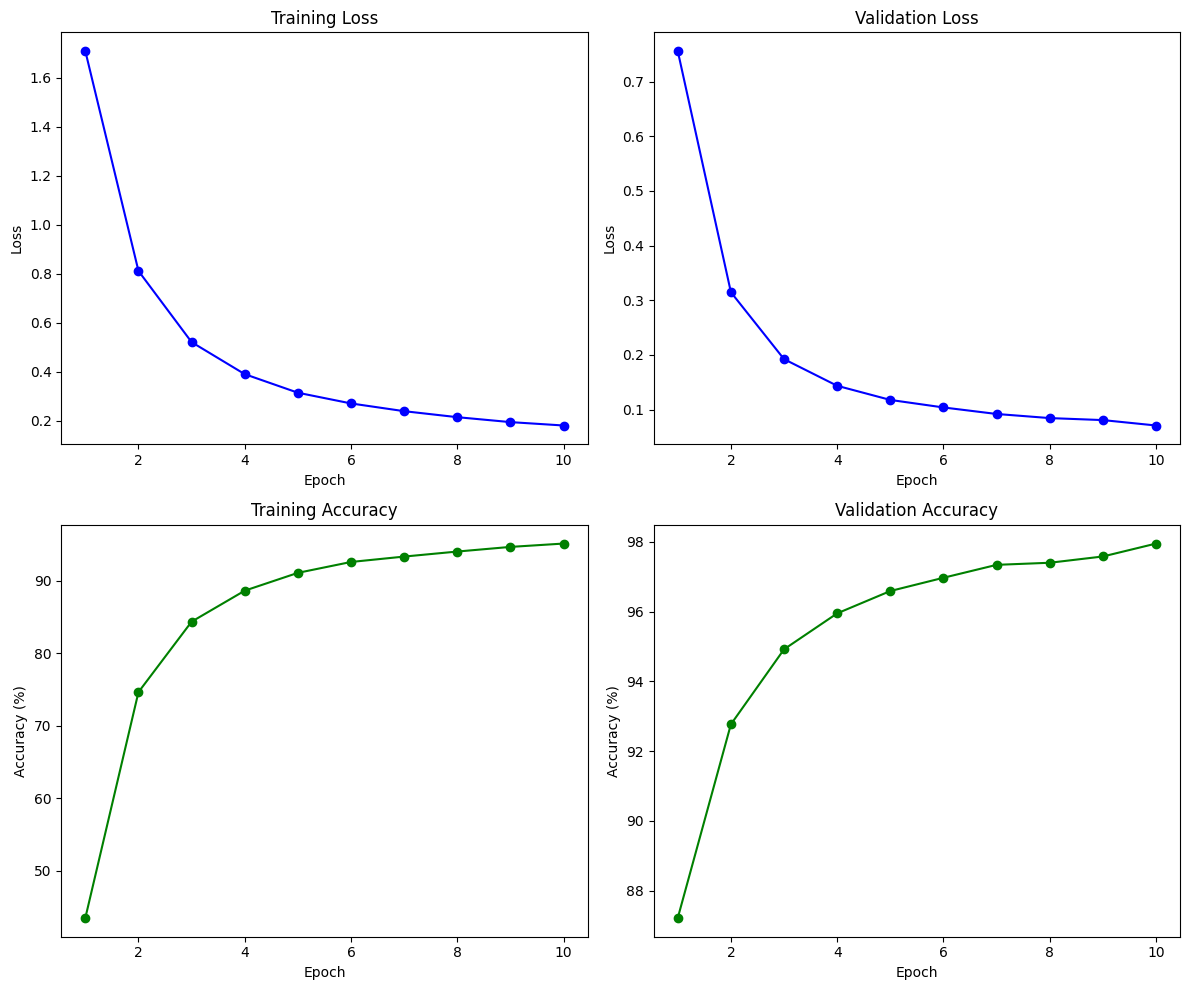

Test Accuracy: 98.13%


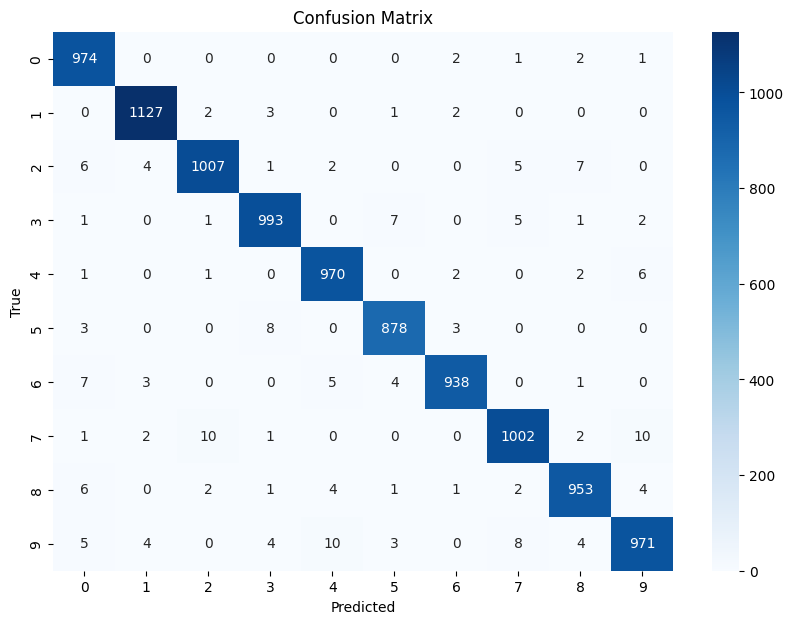

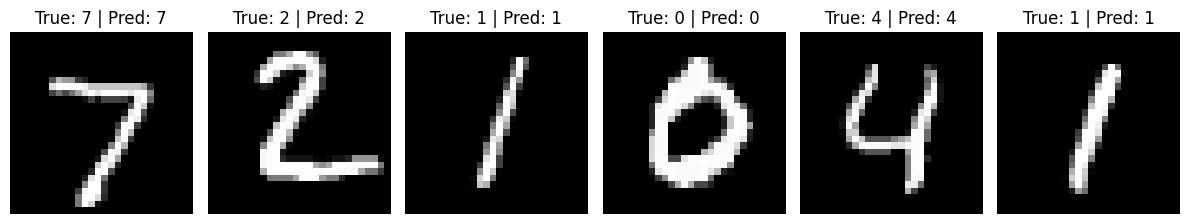


Testing with Batch Size: 512
Epoch [1/10]
Training Loss: 1.9865, Accuracy: 32.86%
Validation Loss: 1.3759, Accuracy: 78.85%
Epoch [2/10]
Training Loss: 1.2936, Accuracy: 59.57%
Validation Loss: 0.7022, Accuracy: 86.89%
Epoch [3/10]
Training Loss: 0.9048, Accuracy: 71.98%
Validation Loss: 0.4356, Accuracy: 91.39%
Epoch [4/10]
Training Loss: 0.6899, Accuracy: 79.06%
Validation Loss: 0.3052, Accuracy: 93.23%
Epoch [5/10]
Training Loss: 0.5591, Accuracy: 83.46%
Validation Loss: 0.2333, Accuracy: 94.26%
Epoch [6/10]
Training Loss: 0.4650, Accuracy: 86.35%
Validation Loss: 0.1914, Accuracy: 95.16%
Epoch [7/10]
Training Loss: 0.4047, Accuracy: 88.32%
Validation Loss: 0.1630, Accuracy: 95.81%
Epoch [8/10]
Training Loss: 0.3641, Accuracy: 89.62%
Validation Loss: 0.1424, Accuracy: 96.24%
Epoch [9/10]
Training Loss: 0.3184, Accuracy: 91.15%
Validation Loss: 0.1272, Accuracy: 96.40%
Epoch [10/10]
Training Loss: 0.2935, Accuracy: 91.79%
Validation Loss: 0.1159, Accuracy: 96.51%


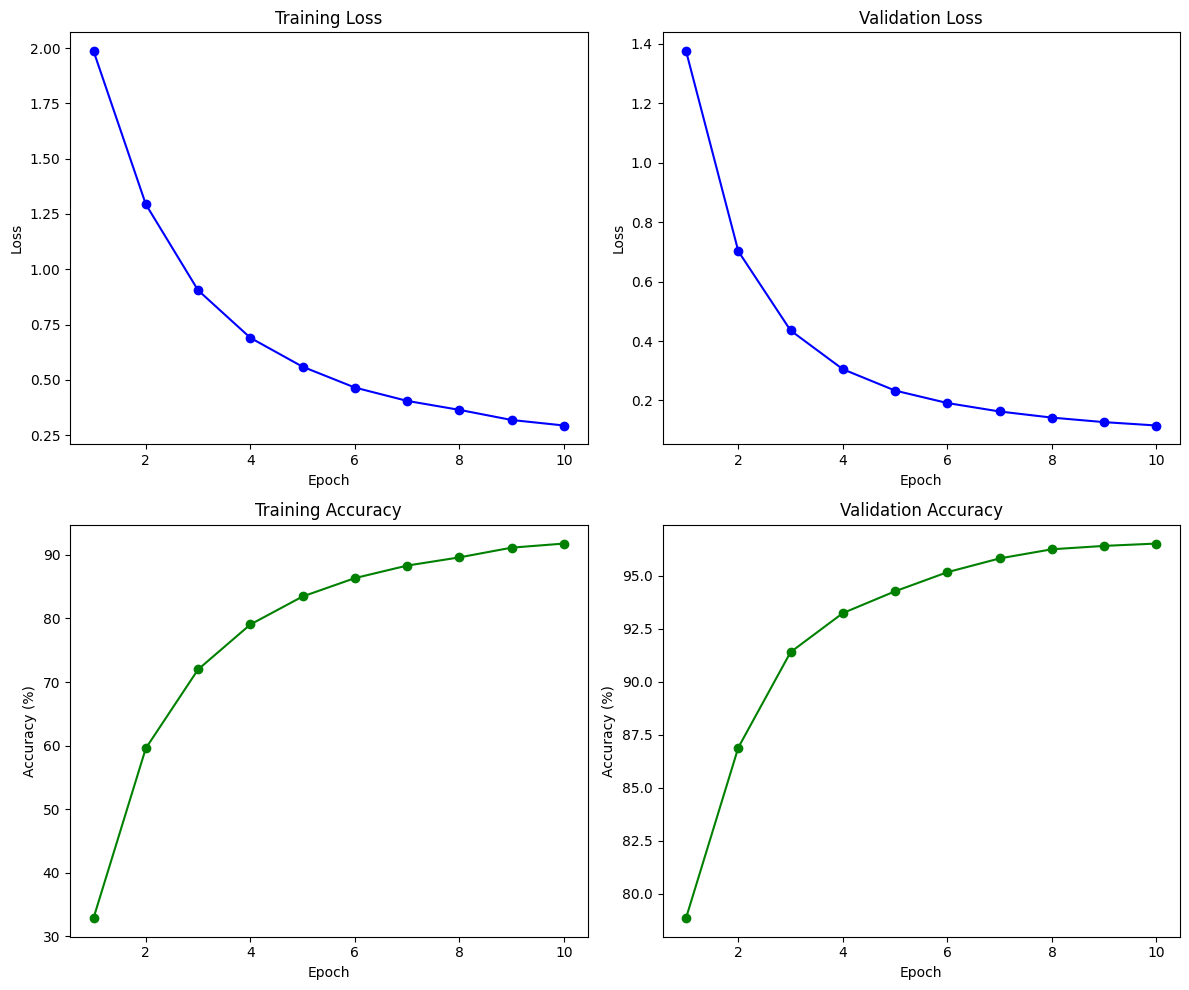

Test Accuracy: 96.91%


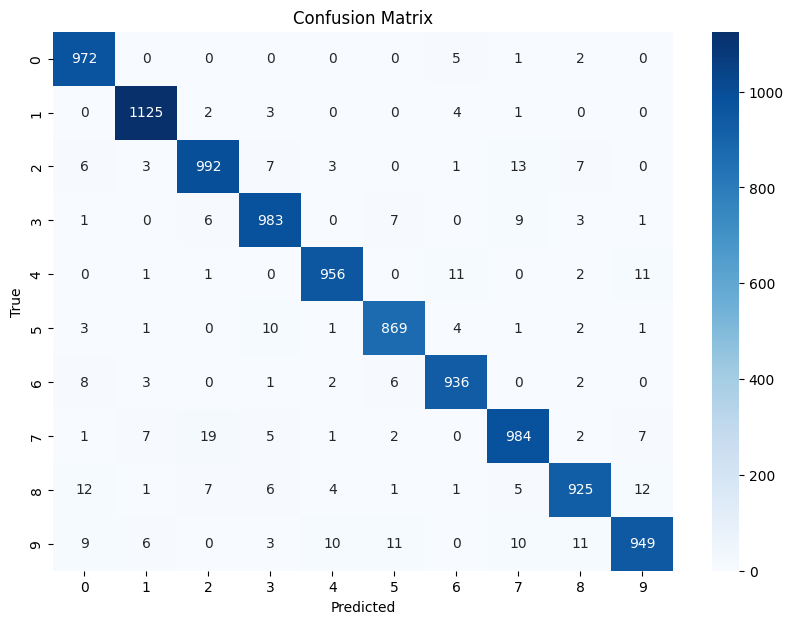

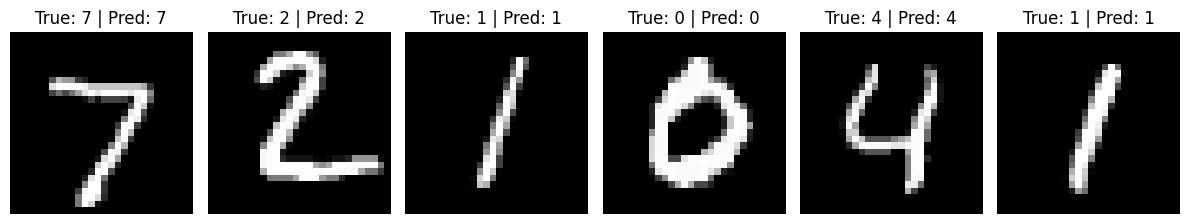

In [60]:
# Batch sizes to test
batch_sizes = [64, 128, 256, 512]




# Function to test different batch sizes
def Trying_batch_sizes():
    for batch_size in batch_sizes:
        print(f"\nTesting with Batch Size: {batch_size}")
        
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        
        model = CNN()
        optimizer =optim.SGD(model.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss()
        
        # Train the model
        train_cnn(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)
        
        
        test_cnn(model, test_loader)
        
        
      


Trying_batch_sizes()




# More Analysis
 
* Different Number of Convolution Layers 
* Different Number of Neurons in Convolutional Layers


In [74]:
class CNNConvLayers(nn.Module):
    def __init__(self, conv_layers, conv_neurons, fc_neurons):
        super(CNNConvLayers, self).__init__()

        # Activation Function
        self.activation_fn = nn.ReLU()

        # Dynamic Convolutional Layers and Batch Norm
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        in_channels = 1  # Starting channel for grayscale images
        for out_channels in conv_neurons:
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.bn_layers.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels

        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer

        # Compute the size of the flattened output dynamically
        dummy_input = torch.zeros(1, 1, 28, 28)  # Input shape for MNIST
        self.flattened_size = self._get_flattened_size(dummy_input)

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flattened_size, fc_neurons[0])
        self.fc2 = nn.Linear(fc_neurons[0], fc_neurons[1])
        self.fc3 = nn.Linear(fc_neurons[1], 10)

        # Dropout Layer
        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self, x):
        # Pass through conv layers to compute output size
        for conv, bn in zip(self.conv_layers, self.bn_layers):
            x = self.pool(self.activation_fn(bn(conv(x))))
        return x.view(-1).size(0)  # Return flattened size

    def forward(self, x):
        for conv, bn in zip(self.conv_layers, self.bn_layers):
            x = self.pool(self.activation_fn(bn(conv(x))))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.dropout(self.activation_fn(self.fc1(x)))
        x = self.dropout(self.activation_fn(self.fc2(x)))
        x = self.fc3(x)

        return x



In [75]:
class CNNConvNeurons(nn.Module):
    def __init__(self, conv_neurons=[32, 64], fc_neurons=[128, 64]):
        super(CNNConvNeurons, self).__init__()

        # Save conv_neurons as an instance variable
        self.conv_neurons = conv_neurons

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(1, conv_neurons[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(conv_neurons[0])

        self.conv2 = nn.Conv2d(conv_neurons[0], conv_neurons[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_neurons[1])

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(conv_neurons[1] * 7 * 7, fc_neurons[0])
        self.fc2 = nn.Linear(fc_neurons[0], fc_neurons[1])
        self.fc3 = nn.Linear(fc_neurons[1], 10)

        # Dropout and activation function
        self.dropout = nn.Dropout(0.5)
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        # First convolutional layer
        x = self.pool(self.activation_fn(self.bn1(self.conv1(x))))
        
        # Second convolutional layer
        x = self.pool(self.activation_fn(self.bn2(self.conv2(x))))

        # Flatten the feature map
        x = x.view(-1, self.conv_neurons[1] * 7 * 7)

        # Fully connected layers
        x = self.dropout(self.activation_fn(self.fc1(x)))
        x = self.dropout(self.activation_fn(self.fc2(x)))
        x = self.fc3(x)

        return x



## **experiment function**

In [ ]:
def experiment():
    # Configurations for convolutional layers (changing number of layers)
    conv_layer_configs = [
        
        [32, 64, 128],  # 3 conv layers 
        [32, 64, 128, 256],  # 4 conv layers 
         
    ]
    
    # Configurations for the number of neurons in the convolutional layers (changing number of filters)
    conv_neuron_configs = [
          
        [64, 128],  
        [128, 256],  
        [256, 512]  
    ]
    
    # Test different convolutional layer configurations
    
    for conv_neurons in conv_layer_configs:
        print(f"\nTesting with Conv Layers: {len(conv_neurons)}, Conv Neurons: {conv_neurons}")

        model = CNNConvLayers(conv_layers=len(conv_neurons), conv_neurons=conv_neurons, fc_neurons=[128, 64])
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss()

        # Train and test
        train_cnn(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)
        test_cnn(model, test_loader)
    
    

    # Test different convolutional neuron configurations
    for conv_neurons in conv_neuron_configs:
        print(f"\nTesting with Conv Neurons: {conv_neurons}, FC Neurons: [128, 64]")

        model = CNNConvNeurons(conv_neurons=conv_neurons, fc_neurons=[128, 64])
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss()

        # Train and test
        train_cnn(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)
        test_cnn(model, test_loader)

experiment()      



### Testing with Conv Layers: 3, Conv Neurons: [32, 64, 128]

#### Epoch Results:
1. **Epoch [1/10]:**
   - Training Loss: 0.6973, Accuracy: 77.37%
   - Validation Loss: 0.0890, Accuracy: 97.42%
2. **Epoch [2/10]:**
   - Training Loss: 0.1736, Accuracy: 95.20%
   - Validation Loss: 0.0587, Accuracy: 98.38%
3. **Epoch [3/10]:**
   - Training Loss: 0.1212, Accuracy: 96.72%
   - Validation Loss: 0.0556, Accuracy: 98.43%
4. **Epoch [4/10]:**
   - Training Loss: 0.0977, Accuracy: 97.42%
   - Validation Loss: 0.0454, Accuracy: 98.75%
5. **Epoch [5/10]:**
   - Training Loss: 0.0790, Accuracy: 97.95%
   - Validation Loss: 0.0447, Accuracy: 98.71%
6. **Epoch [6/10]:**
   - Training Loss: 0.0683, Accuracy: 98.16%
   - Validation Loss: 0.0376, Accuracy: 99.02%
7. **Epoch [7/10]:**
   - Training Loss: 0.0608, Accuracy: 98.41%
   - Validation Loss: 0.0552, Accuracy: 98.58%
8. **Epoch [8/10]:**
   - Training Loss: 0.0534, Accuracy: 98.59%
   - Validation Loss: 0.0378, Accuracy: 99.03%
9. **Epoch [9/10]:**
   - Training Loss: 0.0460, Accuracy: 98.77%
   - Validation Loss: 0.0395, Accuracy: 99.07%
10. **Epoch [10/10]:**
    - Training Loss: 0.0440, Accuracy: 98.91%
    - Validation Loss: 0.0435, Accuracy: 98.89%

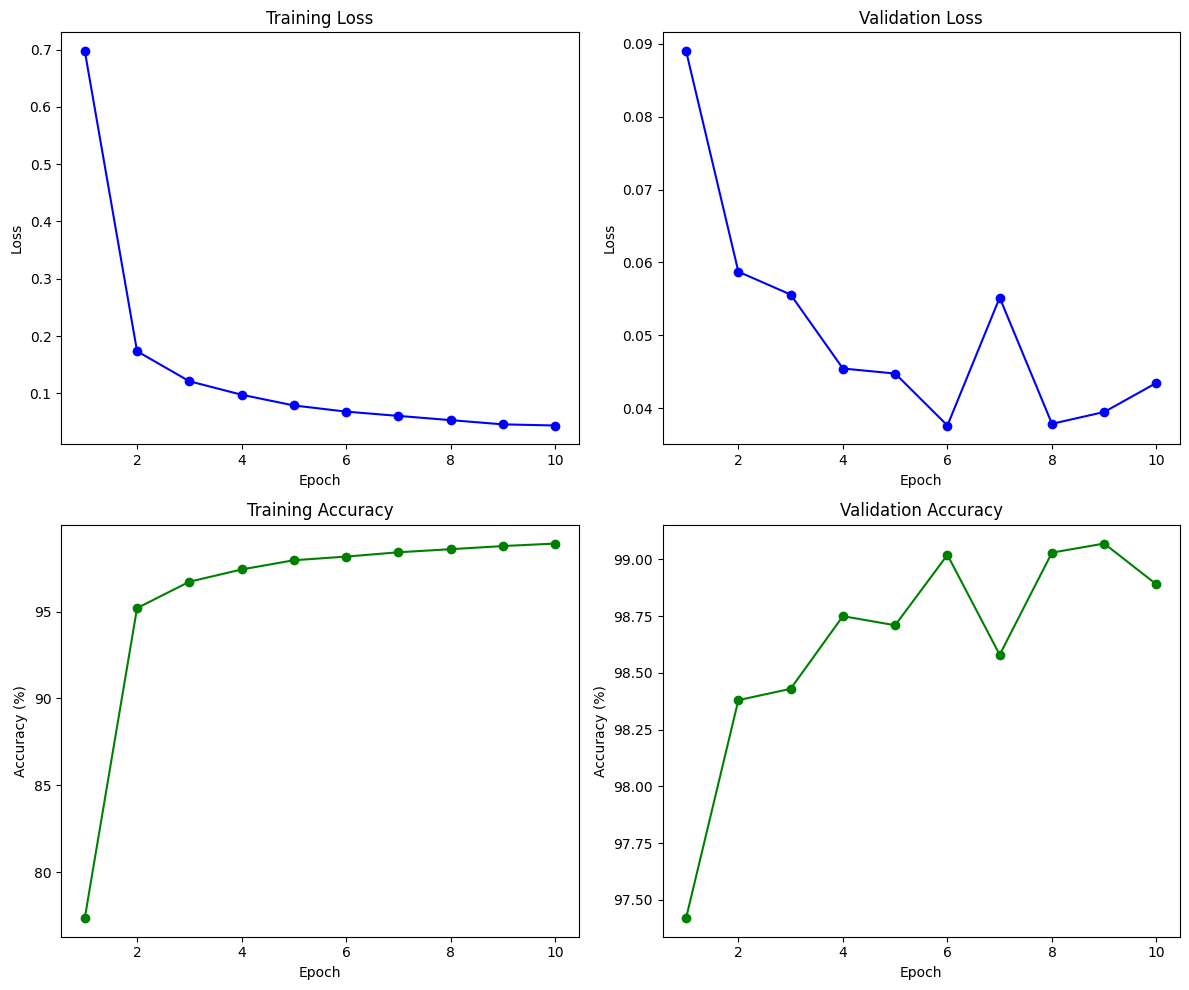

- Test Accuracy: 99.12%

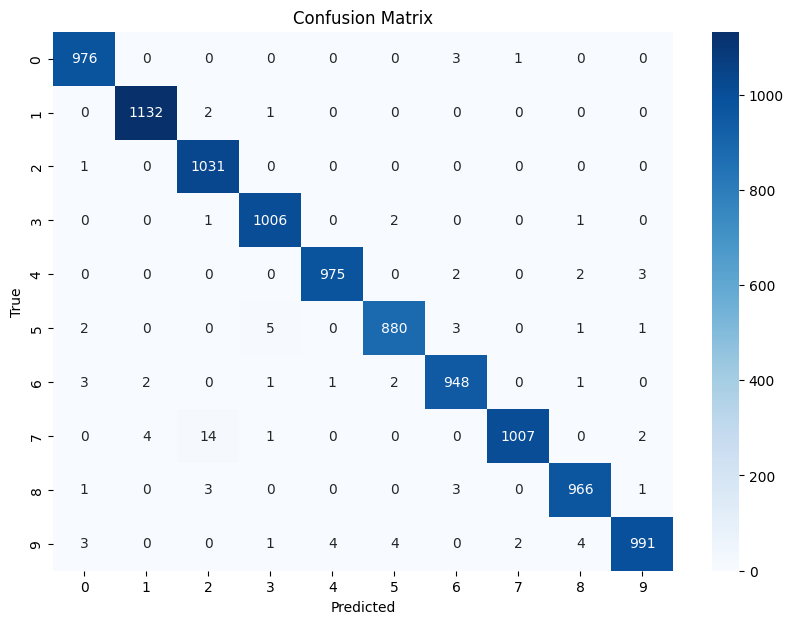
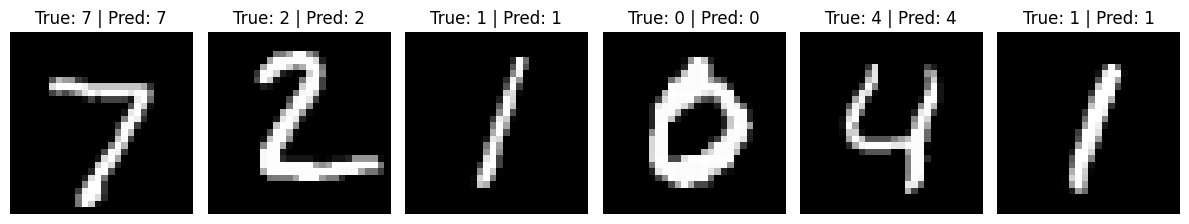


### Testing with Conv Layers: 4, Conv Neurons: [32, 64, 128, 256]

#### Epoch Results:
1. **Epoch [1/10]:**
   - Training Loss: 0.6184, Accuracy: 80.80%
   - Validation Loss: 0.0886, Accuracy: 97.65%
2. **Epoch [2/10]:**
   - Training Loss: 0.1349, Accuracy: 96.57%
   - Validation Loss: 0.1047, Accuracy: 96.82%
3. **Epoch [3/10]:**
   - Training Loss: 0.0869, Accuracy: 97.87%
   - Validation Loss: 0.0554, Accuracy: 98.59%
4. **Epoch [4/10]:**
   - Training Loss: 0.0665, Accuracy: 98.32%
   - Validation Loss: 0.0388, Accuracy: 98.99%
5. **Epoch [5/10]:**
   - Training Loss: 0.0519, Accuracy: 98.70%
   - Validation Loss: 0.0459, Accuracy: 98.91%
6. **Epoch [6/10]:**
   - Training Loss: 0.0457, Accuracy: 98.85%
   - Validation Loss: 0.0563, Accuracy: 98.69%
7. **Epoch [7/10]:**
   - Training Loss: 0.0400, Accuracy: 99.05%
   - Validation Loss: 0.0440, Accuracy: 98.93%
8. **Epoch [8/10]:**
   - Training Loss: 0.0339, Accuracy: 99.17%
   - Validation Loss: 0.0452, Accuracy: 98.98%
9. **Epoch [9/10]:**
   - Training Loss: 0.0300, Accuracy: 99.30%
   - Validation Loss: 0.0472, Accuracy: 98.95%
10. **Epoch [10/10]:**
    - Training Loss: 0.0250, Accuracy: 99.39%
    - Validation Loss: 0.0474, Accuracy: 98.97%

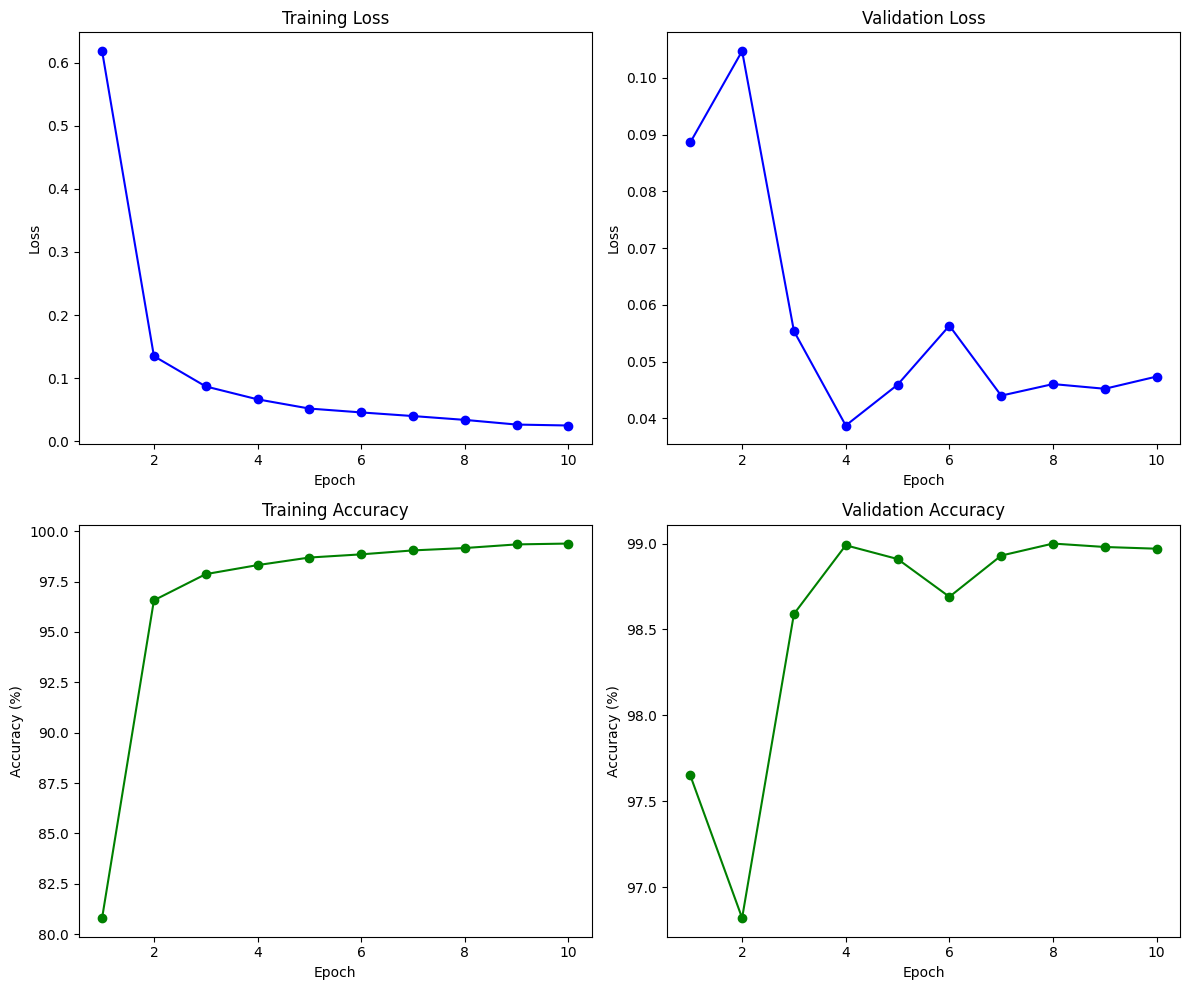

- Test Accuracy: 99.16%

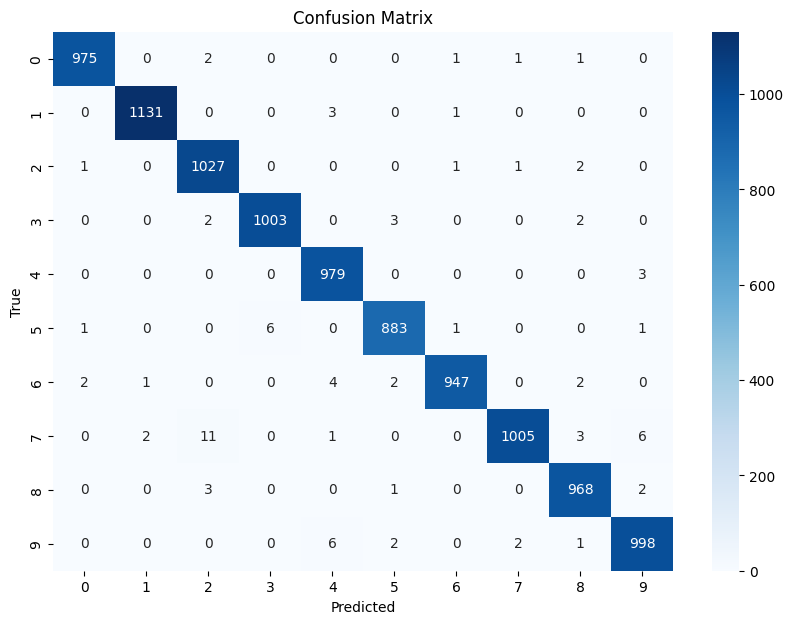
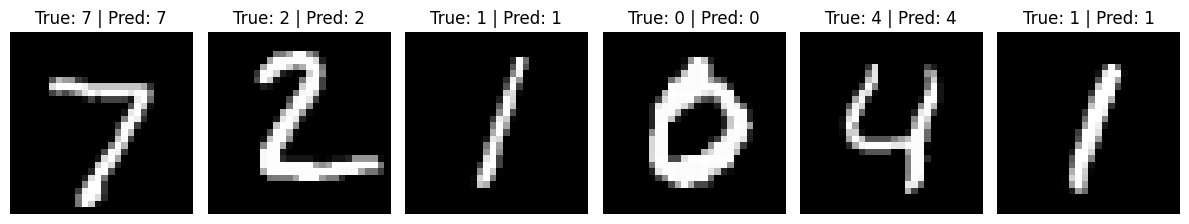